## Load Libraries

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, countDistinct, count, regexp_replace, mean, when, ceil,log, exp, year,lit,round
from pyspark.sql.functions import sum as psum
from operator import or_  
from functools import reduce  
from pyspark.sql.functions import col, mean, min, max, stddev, skewness, kurtosis, rank, F
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind
import scipy.stats as stats
from pyspark.sql.functions import monotonically_increasing_id, current_date, datediff, avg
import folium
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

In [47]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import statsmodels.api as sm

In [3]:
spark = SparkSession.builder \
    .appName("new5") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "4") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

# Set log level to ERROR to reduce verbosity
spark.sparkContext.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/02 12:21:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/02 12:21:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Data Loading

This step involves loading the three types of data—primary, temporal, and HPI—that are needed to create the AVM.

In [4]:
schema = StructType([
    StructField("address_hash", StringType(), nullable=True),
    StructField("lmk_key", StringType(), nullable=True),
    StructField("building_reference_number", StringType(), nullable=True),
    StructField("current_energy_rating", StringType(), nullable=True),
    StructField("potential_energy_rating", StringType(), nullable=True),
    StructField("current_energy_efficiency", FloatType(), nullable=True),
    StructField("potential_energy_efficiency", FloatType(), nullable=True),
    StructField("property_type", StringType(), nullable=True),
    StructField("build_form", StringType(), nullable=True),
    StructField("inspection_date", TimestampType(), nullable=True),#date
    StructField("local_authority", StringType(), nullable=True),
    StructField("constituency", StringType(), nullable=True),
    StructField("county", StringType(), nullable=True),
    StructField("lodgement_date", TimestampType(), nullable=True),#date
    StructField("transaction_type", StringType(), nullable=True),
    StructField("environment_impact_current", FloatType(), nullable=True),
    StructField("environment_impact_potential", FloatType(), nullable=True),
    StructField("energy_consumption_current", FloatType(), nullable=True),
    StructField("energy_consumption_potential", FloatType(), nullable=True),
    StructField("co2_emissions_current", FloatType(), nullable=True),
    StructField("co2_emiss_curr_per_floor_area", FloatType(), nullable=True),
    StructField("co2_emissions_potential", FloatType(), nullable=True),
    StructField("lighting_cost_current", FloatType(), nullable=True),
    StructField("lighting_cost_potential", FloatType(), nullable=True),
    StructField("heating_cost_current", FloatType(), nullable=True),
    StructField("heating_cost_potential", FloatType(), nullable=True),
    StructField("hot_water_cost_current", FloatType(), nullable=True),
    StructField("hot_water_cost_potential", FloatType(), nullable=True),
    StructField("total_floor_area", FloatType(), nullable=True),
    StructField("energy_tariff", StringType(), nullable=True),
    StructField("mains_gas_flag", StringType(), nullable=True),
    StructField("floor_level", StringType(), nullable=True),
    StructField("flat_top_storey", StringType(), nullable=True),
    StructField("flat_storey_count", FloatType(), nullable=True),
    StructField("main_heating_controls", StringType(), nullable=True),
    StructField("multi_glaze_proportion", FloatType(), nullable=True),
    StructField("glazed_type", StringType(), nullable=True),
    StructField("glazed_area", StringType(), nullable=True),
    StructField("extension_count", FloatType(), nullable=True),
    StructField("number_habitable_rooms", FloatType(), nullable=True),
    StructField("number_heated_rooms", FloatType(), nullable=True),
    StructField("low_energy_lighting", FloatType(), nullable=True),
    StructField("number_open_fireplaces", FloatType(), nullable=True),
    StructField("hotwater_description", StringType(), nullable=True),
    StructField("hot_water_energy_eff", StringType(), nullable=True),
    StructField("hot_water_env_eff", StringType(), nullable=True),
    StructField("floor_description", StringType(), nullable=True),
    StructField("floor_energy_eff", StringType(), nullable=True),
    StructField("floor_env_eff", StringType(), nullable=True),
    StructField("windows_description", StringType(), nullable=True),
    StructField("windows_energy_eff", StringType(), nullable=True),
    StructField("windows_env_eff", StringType(), nullable=True),
    StructField("walls_description", StringType(), nullable=True),
    StructField("walls_energy_eff", StringType(), nullable=True),
    StructField("walls_env_eff", StringType(), nullable=True),
    StructField("secondheat_description", StringType(), nullable=True),
    StructField("sheating_energy_eff", StringType(), nullable=True),
    StructField("sheating_env_eff", StringType(), nullable=True),
    StructField("roof_description", StringType(), nullable=True),
    StructField("roof_energy_eff", StringType(), nullable=True),
    StructField("roof_env_eff", StringType(), nullable=True),
    StructField("mainheat_description", StringType(), nullable=True),
    StructField("mainheat_energy_eff", StringType(), nullable=True),
    StructField("mainheat_env_eff", StringType(), nullable=True),
    StructField("mainheatcont_description", StringType(), nullable=True),
    StructField("mainheatc_energy_eff", StringType(), nullable=True),
    StructField("mainheatc_env_eff", StringType(), nullable=True),
    StructField("lighting_description", StringType(), nullable=True),
    StructField("lighting_energy_eff", StringType(), nullable=True),
    StructField("lighting_env_eff", StringType(), nullable=True),
    StructField("main_fuel", StringType(), nullable=True),
    StructField("wind_turbine_count", FloatType(), nullable=True),
    StructField("heat_loss_corridor", StringType(), nullable=True),
    StructField("unheated_corridor_length", FloatType(), nullable=True),
    StructField("floor_height", FloatType(), nullable=True),
    StructField("photo_supply", FloatType(), nullable=True),
    StructField("solar_water_heating_flag", StringType(), nullable=True),
    StructField("mechanical_ventilation", StringType(), nullable=True),
    StructField("epc_address", StringType(), nullable=True),
    StructField("local_authority_label", StringType(), nullable=True),
    StructField("constituency_label", StringType(), nullable=True),
    StructField("construction_age_band", StringType(), nullable=True),
    StructField("lodgement_datetime", TimestampType(), nullable=True),#date
    StructField("tenure", StringType(), nullable=True),
    StructField("fixed_lighting_outlets_count", FloatType(), nullable=True),
    StructField("low_energy_fixed_light_count", FloatType(), nullable=True),
    StructField("improvement_id", StringType(), nullable=True),
    StructField("improvement_item_id", StringType(), nullable=True),
    StructField("improvement_id_text", StringType(), nullable=True),
    StructField("min_indicative_cost", StringType(), nullable=True),
    StructField("max_indicative_cost", StringType(), nullable=True),
    StructField("typical_yearly_savings", StringType(), nullable=True),
    StructField("rating_after_improvement", StringType(), nullable=True),
    StructField("sap_after_improvement", StringType(), nullable=True),
    StructField("env_after_improvement", StringType(), nullable=True),
    StructField("envsap_after_improvement", StringType(), nullable=True),
    StructField("address_hash_1", StringType(), nullable=True),
    StructField("min_cost", FloatType(), nullable=True),
    StructField("mid_cost", FloatType(), nullable=True),
    StructField("max_cost", FloatType(), nullable=True),
    StructField("min_cost_incl_service_maintenance", FloatType(), nullable=True),
    StructField("mid_cost_incl_service_maintenance", FloatType(), nullable=True),
    StructField("max_cost_incl_service_maintenance", FloatType(), nullable=True),
    StructField("total_ltv_inflated", FloatType(), nullable=True),
    StructField("total_affordability", FloatType(), nullable=True),
    StructField("total_seg", FloatType(), nullable=True),
    StructField("green_val", FloatType(), nullable=True),
    StructField("net_present_value", FloatType(), nullable=True),
    StructField("postcode", StringType(), nullable=True),
    StructField("uprn", StringType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("lon", FloatType(), nullable=True),
    StructField("lad22nm", StringType(), nullable=True),
    StructField("lad22cd", StringType(), nullable=True),
    StructField("lsoa11cd", StringType(), nullable=True),
    StructField("uid", StringType(), nullable=True),
    StructField("price", IntegerType(), nullable=True),
    StructField("date_of_transfer", TimestampType(), nullable=True),
    StructField("price_paid_property_type", StringType(), nullable=True),
    StructField("old_new", BooleanType(), nullable=True),
    StructField("address_hash_2", StringType(), nullable=True),
    StructField("propertyIsBungalow", BooleanType(), nullable=True),
    StructField("propertyIsFlat", BooleanType(), nullable=True),
    StructField("propertyIsHouse", BooleanType(), nullable=True),
    StructField("propertyIsMaisonette", BooleanType(), nullable=True),
    StructField("propertyIsParkHome", BooleanType(), nullable=True),
    StructField("propertyIsDetached", BooleanType(), nullable=True),
    StructField("propertyIsEnclosedTerrace", BooleanType(), nullable=True),
    StructField("propertyIsEnclosedMidTerrace", BooleanType(), nullable=True),
    StructField("propertyIsEndTerrace", BooleanType(), nullable=True),
    StructField("propertyIsMidTerrace", BooleanType(), nullable=True),
    StructField("propertyIsSemiDetached", BooleanType(), nullable=True),
    StructField("propertyInEngland", BooleanType(), nullable=True),
    StructField("propertyInScotland", BooleanType(), nullable=True),
    StructField("propertyInWales", BooleanType(), nullable=True),
    StructField("propertyHasFlatRoof", IntegerType(), nullable=True),
    StructField("propertyHasPitchedRoof", IntegerType(), nullable=True),
    StructField("propertyIsNewBuildFlat", IntegerType(), nullable=True),
    StructField("propertyHasRoofInsulation", IntegerType(), nullable=True),
    StructField("propertyTotalFloorArea", IntegerType(), nullable=True),
    StructField("propertyBelowEPCE", BooleanType(), nullable=True),
    StructField("propertyAboveCommercialPremises", BooleanType(), nullable=True),
    StructField("propertyAboveFoodOutlets", BooleanType(), nullable=True),
    StructField("propertyIsCloseToCommercialOutlets", BooleanType(), nullable=True),
    StructField("propertyIsDualUse", BooleanType(), nullable=True),
    StructField("propertyIsHolidayHome", BooleanType(), nullable=True),
    StructField("propertyIsGradeIListed", BooleanType(), nullable=True),
    StructField("propertyIsGradeIIListed", BooleanType(), nullable=True),
    StructField("propertyIsGradeIIStarListed", BooleanType(), nullable=True),
    StructField("gradeListing", StringType(), nullable=True),
    StructField("conservationArea", BooleanType(), nullable=True),
    StructField("address_hash_3", StringType(), nullable=True),
    StructField("amenities_pub_bar_restaurant", IntegerType(), nullable=True),
    StructField("area_neighbours", FloatType(), nullable=True),
    StructField("education_facilities_higher", IntegerType(), nullable=True),
    StructField("education_facilities_pre_school", IntegerType(), nullable=True),
    StructField("education_facilities_school", IntegerType(), nullable=True),
    StructField("leisure_facilities_exercise", IntegerType(), nullable=True),
    StructField("leisure_facilities_parks", IntegerType(), nullable=True),
    StructField("public_transport_bus_tram", IntegerType(), nullable=True),
    StructField("public_transport_train_underground", IntegerType(), nullable=True),
    StructField("retail_services_banking", IntegerType(), nullable=True),
    StructField("retail_services_newsagent", IntegerType(), nullable=True),
    StructField("retail_services_post_office", IntegerType(), nullable=True),
    StructField("support_services_healthcare", IntegerType(), nullable=True),
    StructField("liabilities_flood_risk_category", FloatType(), nullable=True),
    StructField("liabilities_radon", FloatType(), nullable=True),
    StructField("liabilities_industrial_areas", IntegerType(), nullable=True),
    StructField("noise_roads", IntegerType(), nullable=True),
    StructField("liabilities_collapsibledeposits", FloatType(), nullable=True),
    StructField("liabilities_compressibleground", FloatType(), nullable=True),
    StructField("liabilities_landslides", FloatType(), nullable=True),
    StructField("liabilities_runningsand", FloatType(), nullable=True),
    StructField("liabilities_shrinkswell", FloatType(), nullable=True),
    StructField("liabilities_solublerocks", FloatType(), nullable=True),
    StructField("buildinguse", StringType(), nullable=True),
    StructField("connectivity", StringType(), nullable=True),
    StructField("constructionmaterial", StringType(), nullable=True),
    StructField("buildingage_year", FloatType(), nullable=True),
    StructField("lsoa11cd_1", StringType(), nullable=True),
    StructField("lsoa11nm", StringType(), nullable=True),
    StructField("lsoa11nmw", StringType(), nullable=True),
    StructField("st_areasha", FloatType(), nullable=True),
    StructField("st_lengths", FloatType(), nullable=True),
    StructField("imd_rank", IntegerType(), nullable=True),
    StructField("imd_decile", IntegerType(), nullable=True),
    StructField("lsoa01nm", StringType(), nullable=True),
    StructField("ladcd", StringType(), nullable=True),
    StructField("ladnm", StringType(), nullable=True),
    StructField("imdscore", FloatType(), nullable=True),
    StructField("imdrank0", IntegerType(), nullable=True),
    StructField("imddec0", IntegerType(), nullable=True),
    StructField("incscore", FloatType(), nullable=True),
    StructField("incrank", IntegerType(), nullable=True),
    StructField("incdec", IntegerType(), nullable=True),
    StructField("empscore", FloatType(), nullable=True),
    StructField("emprank", IntegerType(), nullable=True),
    StructField("empdec", IntegerType(), nullable=True),
    StructField("eduscore", FloatType(), nullable=True),
    StructField("edurank", IntegerType(), nullable=True),
    StructField("edudec", IntegerType(), nullable=True),
    StructField("hddscore", FloatType(), nullable=True),
    StructField("hddrank", IntegerType(), nullable=True),
    StructField("hdddec", IntegerType(), nullable=True),
    StructField("criscore", FloatType(), nullable=True),
    StructField("crirank", IntegerType(), nullable=True),
    StructField("cridec", IntegerType(), nullable=True),
    StructField("bhsscore", FloatType(), nullable=True),
    StructField("bhsrank", IntegerType(), nullable=True),
    StructField("bhsdec", IntegerType(), nullable=True),
    StructField("envscore", FloatType(), nullable=True),
    StructField("envrank", IntegerType(), nullable=True),
    StructField("envdec", IntegerType(), nullable=True),
    StructField("idcscore", FloatType(), nullable=True),
    StructField("idcrank", IntegerType(), nullable=True),
    StructField("idcdec", IntegerType(), nullable=True),
    StructField("idoscore", FloatType(), nullable=True),
    StructField("idorank", IntegerType(), nullable=True),
    StructField("idodec", IntegerType(), nullable=True),
    StructField("cypscore", FloatType(), nullable=True),
    StructField("cyprank", IntegerType(), nullable=True),
    StructField("cypdec", IntegerType(), nullable=True),
    StructField("asscore", FloatType(), nullable=True),
    StructField("asrank", IntegerType(), nullable=True),
    StructField("asdec", IntegerType(), nullable=True),
    StructField("gbscore", FloatType(), nullable=True),
    StructField("gbrank", IntegerType(), nullable=True),
    StructField("gbdec", IntegerType(), nullable=True),
    StructField("wbscore", FloatType(), nullable=True),
    StructField("wbrank", IntegerType(), nullable=True),
    StructField("wbdec", IntegerType(), nullable=True),
    StructField("indscore", FloatType(), nullable=True),
    StructField("indrank", IntegerType(), nullable=True),
    StructField("inddec", IntegerType(), nullable=True),
    StructField("outscore", FloatType(), nullable=True),
    StructField("outrank", IntegerType(), nullable=True),
    StructField("outdec", IntegerType(), nullable=True),
    StructField("totpop", IntegerType(), nullable=True),
    StructField("depchi", IntegerType(), nullable=True),
    StructField("pop16_59", IntegerType(), nullable=True),
    StructField("pop60", IntegerType(), nullable=True),
    StructField("workpop", FloatType(), nullable=True)]

)

In [5]:
#primary data
start_time =time.time()
df= spark.read.csv("/Users/riyamac/Desktop/data/data_students_combined_primary_data_dedup_full.csv",header=False,schema=schema,inferSchema=False,quote='"', escape='"')
end_time = time.time()
execution_time = end_time - start_time
num_rows = df.count()
num_columns = len(df.columns)

print("shape:{} rows and columns:{}".format(num_rows,num_columns))
print("execution time:", execution_time,"seconds")

shape:8854277 rows and columns:242
execution time: 1.2889068126678467 seconds


In [6]:
#HPI data
hpi_df = spark.read.csv('hpi.csv', header=True, inferSchema=True) 

In [7]:
# Temporal data
start_time =time.time()
hdf= spark.read.csv("/Users/riyamac/Desktop/data/data_students_combined_primary_data_full.csv",header=False,schema=schema,inferSchema=False,quote='"', escape='"')
end_time = time.time()
execution_time = end_time - start_time
num_rows = hdf.count()
num_columns = len(hdf.columns)

print("shape:{} rows and columns:{}".format(num_rows,num_columns))
print("execution time:", execution_time,"seconds")

shape:15042606 rows and columns:242
execution time: 0.04086184501647949 seconds


In [8]:
pd.options.display.max_columns = 242

In [9]:
df.limit(5).toPandas()

address_hash  \
0  aed599046a46ad631732600786c466d2   
1  b56b4b41c0beb20933cb98fe14a9b393   
2  5cefa7db15cad36902ee4981b75d82fd   
3  2ca67c3eca707b9f0beab269d4d0a778   
4  acbaee15d46402936272cdc033a2ceef   

                                             lmk_key  \
0                 1363504809022015091319583609798655   
1                 1389117889042015112512313343059718   
2                  429580909342010020113214576200598   
3                 1786420022542020022109422268902708   
4  2596dd7287d6c51d35a176fcc8ae82e2d5c6d2f316f8c2...   

  building_reference_number current_energy_rating potential_energy_rating  \
0                5008009378                     E                       D   
1                6067280478                     E                       C   
2                4377402768                     D                       C   
3                3577429678                     D                       B   
4               10000553242                     E                       C   

   current_energy_efficiency  potential_energy_efficiency property_type  \
0                       48.0                         62.0    Maisonette   
1                       51.0                         76.0         House   
2                       56.0                         73.0         House   
3                       66.0                         89.0         House   
4                       43.0                         77.0         House   

      build_form inspection_date local_authority constituency          county  \
0       Detached      2015-09-01       E07000222    E14001019    Warwickshire   
1  Semi-Detached      2015-11-19       E07000229    E14000682     West Sussex   
2  Semi-Detached      2010-02-01       E07000072    E14000693           Essex   
3    Mid-Terrace      2020-02-20       E07000239    E14001058  Worcestershire   
4       Detached      2021-03-01       E07000242    E14000744   Hertfordshire   

  lodgement_date transaction_type  environment_impact_current  \
0     2015-09-13   ECO assessment                        41.0   
1     2015-11-25             Sale                        51.0   
2     2010-02-01             Sale                        49.0   
3     2020-02-21             Sale                        63.0   
4     2021-04-01           Rental                        37.0   

   environment_impact_potential  energy_consumption_current  \
0                          55.0                       394.0   
1                          78.0                       303.0   
2                          68.0                       362.0   
3                          89.0                       244.0   
4                          64.0                       245.0   

   energy_consumption_potential  co2_emissions_current  \
0                         278.0                    6.3   
1                         131.0                    5.8   
2                         222.0                    4.8   
3                          66.0                    3.0   
4                          77.0                    8.8   

   co2_emiss_curr_per_floor_area  co2_emissions_potential  \
0                           69.0                      4.4   
1                           46.0                      2.3   
2                           61.0                      2.9   
3                           43.0                      0.9   
4                           64.0                      4.2   

   lighting_cost_current  lighting_cost_potential  heating_cost_current  \
0                  122.0                     61.0                1156.0   
1                  141.0                     70.0                1202.0   
2                   75.0                     39.0                 585.0   
3                   90.0                     57.0                 501.0   
4                   93.0                     94.0                1167.0   

   heating_cost_potential  hot_water_cost_current  hot_water_cost_potential  \
0                   832.0         

## Modifying the Target Variable

Here, we are transforming our target variable 'price' using House Price Index (HPI) for maintaining consistency and accurate comparisons

In [10]:
# Extract year from the 'date_of_transfer' column
newdf = df.withColumn('year', year(col('date_of_transfer')))

# Get the CPI for the base year (e.g., 2024)
base_year_hpi = hpi_df.filter(col('year') == 2024).select('average_hpi').first()[0]

# Join property data with CPI data on 'sale_year'
newdf = newdf.join(hpi_df, on='year', how='left')

# Adjust the prices by multiplying with the inflation factor
newdf = newdf.withColumn('hpi_adjusted_price', round((col('price') / col("average_hpi"))* base_year_hpi).cast('int'))

newdf = newdf.drop("year")

In [11]:
newdf.limit(5).toPandas()

address_hash  \
0  aed599046a46ad631732600786c466d2   
1  b56b4b41c0beb20933cb98fe14a9b393   
2  5cefa7db15cad36902ee4981b75d82fd   
3  2ca67c3eca707b9f0beab269d4d0a778   
4  acbaee15d46402936272cdc033a2ceef   

                                             lmk_key  \
0                 1363504809022015091319583609798655   
1                 1389117889042015112512313343059718   
2                  429580909342010020113214576200598   
3                 1786420022542020022109422268902708   
4  2596dd7287d6c51d35a176fcc8ae82e2d5c6d2f316f8c2...   

  building_reference_number current_energy_rating potential_energy_rating  \
0                5008009378                     E                       D   
1                6067280478                     E                       C   
2                4377402768                     D                       C   
3                3577429678                     D                       B   
4               10000553242                     E                       C   

   current_energy_efficiency  potential_energy_efficiency property_type  \
0                       48.0                         62.0    Maisonette   
1                       51.0                         76.0         House   
2                       56.0                         73.0         House   
3                       66.0                         89.0         House   
4                       43.0                         77.0         House   

      build_form inspection_date local_authority constituency          county  \
0       Detached      2015-09-01       E07000222    E14001019    Warwickshire   
1  Semi-Detached      2015-11-19       E07000229    E14000682     West Sussex   
2  Semi-Detached      2010-02-01       E07000072    E14000693           Essex   
3    Mid-Terrace      2020-02-20       E07000239    E14001058  Worcestershire   
4       Detached      2021-03-01       E07000242    E14000744   Hertfordshire   

  lodgement_date transaction_type  environment_impact_current  \
0     2015-09-13   ECO assessment                        41.0   
1     2015-11-25             Sale                        51.0   
2     2010-02-01             Sale                        49.0   
3     2020-02-21             Sale                        63.0   
4     2021-04-01           Rental                        37.0   

   environment_impact_potential  energy_consumption_current  \
0                          55.0                       394.0   
1                          78.0                       303.0   
2                          68.0                       362.0   
3                          89.0                       244.0   
4                          64.0                       245.0   

   energy_consumption_potential  co2_emissions_current  \
0                         278.0                    6.3   
1                         131.0                    5.8   
2                         222.0                    4.8   
3                          66.0                    3.0   
4                          77.0                    8.8   

   co2_emiss_curr_per_floor_area  co2_emissions_potential  \
0                           69.0                      4.4   
1                           46.0                      2.3   
2                           61.0                      2.9   
3                           43.0                      0.9   
4                           64.0                      4.2   

   lighting_cost_current  lighting_cost_potential  heating_cost_current  \
0                  122.0                     61.0                1156.0   
1                  141.0                     70.0                1202.0   
2                   75.0                     39.0                 585.0   
3                   90.0                     57.0                 501.0   
4                   93.0                     94.0                1167.0   

   heating_cost_potential  hot_water_cost_current  hot_water_cost_potential  \
0                   832.0         

# Data Exploration and Cleaning

In [12]:
newdf.printSchema()

root
 |-- address_hash: string (nullable = true)
 |-- lmk_key: string (nullable = true)
 |-- building_reference_number: string (nullable = true)
 |-- current_energy_rating: string (nullable = true)
 |-- potential_energy_rating: string (nullable = true)
 |-- current_energy_efficiency: float (nullable = true)
 |-- potential_energy_efficiency: float (nullable = true)
 |-- property_type: string (nullable = true)
 |-- build_form: string (nullable = true)
 |-- inspection_date: timestamp (nullable = true)
 |-- local_authority: string (nullable = true)
 |-- constituency: string (nullable = true)
 |-- county: string (nullable = true)
 |-- lodgement_date: timestamp (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- environment_impact_current: float (nullable = true)
 |-- environment_impact_potential: float (nullable = true)
 |-- energy_consumption_current: float (nullable = true)
 |-- energy_consumption_potential: float (nullable = true)
 |-- co2_emissions_current: float (nul

In [13]:
#Finding null values from each column
null_counts = newdf.select([psum(col(column).isNull().cast("int")).alias(column)for column in newdf.columns])
null_counts_df = null_counts.toPandas()
null_counts_df

address_hash  lmk_key  building_reference_number  current_energy_rating  \
0             0        0                          0                      0   

   potential_energy_rating  current_energy_efficiency  \
0                        0                          0   

   potential_energy_efficiency  property_type  build_form  inspection_date  \
0                            0              0       65605                0   

   local_authority  constituency   county  lodgement_date  transaction_type  \
0               55         12507  4306260               0            548907   

   environment_impact_current  environment_impact_potential  \
0                           0                             0   

   energy_consumption_current  energy_consumption_potential  \
0                           0                            78   

   co2_emissions_current  co2_emiss_curr_per_floor_area  \
0                      0                           2409   

   co2_emissions_potential  lighting_cost_current  lighting_cost_potential  \
0                        0                      2                        2   

   heating_cost_current  heating_cost_potential  hot_water_cost_current  \
0                     2                       2                       2   

   hot_water_cost_potential  total_floor_area  energy_tariff  mains_gas_flag  \
0                         2                 0         936036               0   

   floor_level  flat_top_storey  flat_storey_count  main_heating_controls  \
0      7494615                0            8853555                2690533   

   multi_glaze_proportion  glazed_type  glazed_area  extension_count  \
0                  735986      1051682       714601           714601   

   number_habitable_rooms  number_heated_rooms  low_energy_lighting  \
0                  714601               714601               306905   

   number_open_fireplaces  hotwater_description  hot_water_energy_eff  \
0                   90412                     8                     0   

   hot_water_env_eff  floor_description  floor_energy_eff  floor_env_eff  \
0                  0                152           3528279              0   

   windows_description  windows_energy_eff  windows_env_eff  \
0                  184                   0                0   

   walls_description  walls_energy_eff  walls_env_eff  secondheat_description  \
0                 79                 0              0                       1   

   sheating_energy_eff  sheating_env_eff  roof_description  roof_energy_eff  \
0              8854277           8854277              1091                0   

   roof_env_eff  mainheat_description  mainheat_energy_eff  mainheat_env_eff  \
0             0                     0                    0                 0   

   mainheatcont_description  mainheatc_energy_eff  mainheatc_env_eff  \
0                        19                     0                  0   

   lighting_description  lighting_energy_eff  lighting_env_eff  main_fuel  \
0                   597                    2                 0       9040   

   wind_turbine_count  heat_loss_corridor  unheated_corridor_length  \
0              594718             7515429                   8153038   

   floor_height  photo_supply  solar_water_heating_flag  \
0       5462547       4294962                   2846517   

   mechanical_ventilation  epc_address  local_authority_label  \
0                  714601            0                     55   

   constituency_label  construction_age_band  lodgement_datetime  tenure  \
0               12507                 734645                   0  710543   

   fixed_lighting_outlets_count  low_energy_fixed_light_count  improvement_id  \
0                       4046085                       5715759            3978   

   improvement_item_id  improvement_id_text  min_indicative_cost  \
0                 3978                 3978                 3978   

   max_indicative_cost  typical_yearly_savings  rating_after_improvement  

#### Removing columns with more than 50% null values

In [14]:
threshold = 0.5 * newdf.count()

#Collect the results into a dictionary
null_counts_dic = null_counts.collect()[0].asDict()

#Determine columns to drop
columns_to_drop = [column for column in newdf.columns if null_counts_df[column].values[0] > threshold]

#Print the names of columns that will be dropped
print("Columns to be dropped due to more than 50% null values:")
print(columns_to_drop)


Columns to be dropped due to more than 50% null values:
['floor_level', 'flat_storey_count', 'sheating_energy_eff', 'sheating_env_eff', 'heat_loss_corridor', 'unheated_corridor_length', 'floor_height', 'low_energy_fixed_light_count', 'propertyInScotland', 'propertyInWales', 'propertyHasFlatRoof', 'propertyHasPitchedRoof', 'propertyIsNewBuildFlat', 'propertyHasRoofInsulation', 'propertyAboveCommercialPremises', 'propertyAboveFoodOutlets', 'propertyIsCloseToCommercialOutlets', 'propertyIsDualUse', 'propertyIsHolidayHome', 'propertyIsGradeIListed', 'propertyIsGradeIIListed', 'propertyIsGradeIIStarListed', 'gradeListing', 'buildingage_year']


In [13]:
drcolumns_to_drop = ['floor_level', 'flat_storey_count', 'sheating_energy_eff', 'sheating_env_eff', 'heat_loss_corridor', 'unheated_corridor_length', 'floor_height', 'low_energy_fixed_light_count', 'propertyHasFlatRoof', 'propertyHasPitchedRoof', 'propertyIsNewBuildFlat', 'propertyHasRoofInsulation', 'propertyAboveCommercialPremises', 'propertyAboveFoodOutlets', 'propertyIsCloseToCommercialOutlets', 'propertyIsDualUse', 'propertyIsHolidayHome', 'propertyIsGradeIListed', 'propertyIsGradeIIListed', 'propertyIsGradeIIStarListed', 'gradeListing', 'buildingage_year','typical_yearly_savings', 'rating_after_improvement', 'sap_after_improvement', 'env_after_improvement', 'envsap_after_improvement']
newdf = newdf.drop(*drcolumns_to_drop)


#### Removing columns with unique entries

In [14]:
ucolumns_to_drop = ['address_hash','lmk_key','building_reference_number','epc_address','address_hash_1',
                    'postcode','uid','address_hash_2','address_hash_3']
newdf = newdf.drop(*ucolumns_to_drop)


#### Removing duplicate columns

In [15]:
dcolumns_to_drop = ['lad22cd','lad22nm','lsoa11cd_1','lsoa11nmw','lsoa01nm','ladcd','ladnm','propertyTotalFloorArea']
df_cleaned = newdf.drop(*dcolumns_to_drop)


### Dealing with numerical columns

In [16]:
# Function to get numeric columns
def get_numeric_columns(dataframe):
    numeric_types = ['int', 'float','double']
    numeric_columns = [col_name for col_name, dtype in dataframe.dtypes if dtype in numeric_types]
    return numeric_columns

# Get the list of numeric columns
numeric_columns = get_numeric_columns(df_cleaned)

# Print the list of numeric columns
print("Numeric columns:")
print(numeric_columns)



Numeric columns:
['current_energy_efficiency', 'potential_energy_efficiency', 'environment_impact_current', 'environment_impact_potential', 'energy_consumption_current', 'energy_consumption_potential', 'co2_emissions_current', 'co2_emiss_curr_per_floor_area', 'co2_emissions_potential', 'lighting_cost_current', 'lighting_cost_potential', 'heating_cost_current', 'heating_cost_potential', 'hot_water_cost_current', 'hot_water_cost_potential', 'total_floor_area', 'multi_glaze_proportion', 'extension_count', 'number_habitable_rooms', 'number_heated_rooms', 'low_energy_lighting', 'number_open_fireplaces', 'wind_turbine_count', 'photo_supply', 'fixed_lighting_outlets_count', 'min_cost', 'mid_cost', 'max_cost', 'min_cost_incl_service_maintenance', 'mid_cost_incl_service_maintenance', 'max_cost_incl_service_maintenance', 'total_ltv_inflated', 'total_affordability', 'total_seg', 'green_val', 'net_present_value', 'lat', 'lon', 'price', 'amenities_pub_bar_restaurant', 'area_neighbours', 'education_

#### Handling null values in numeric columns

In [17]:
# Compute the mean of each numeric column
means = df_cleaned.select([ceil(mean(col(c))).alias(c) for c in numeric_columns]).collect()[0].asDict()
# Fill null values with the mean of each column
df_filled = df_cleaned.fillna(means)

In [18]:
df_filled = df_filled.fillna(0, subset =["total_floor_area"])

#### EDA of numeric columns

In [19]:
#descriptive statistics

# Function to compute and print statistics for a given column
def compute_statistics(df_filled, column):
    mean_value = df_filled.select(mean(col(column)).alias("mean")).collect()[0]["mean"]
    min_value = df_filled.select(min(col(column)).alias("min")).collect()[0]["min"]
    max_value = df_filled.select(max(col(column)).alias("max")).collect()[0]["max"]
    stddev_value = df_filled.select(stddev(col(column)).alias("stddev")).collect()[0]["stddev"]
    skewness_value = df_filled.select(skewness(col(column)).alias("skewness")).collect()[0]["skewness"]
    kurtosis_value = df_filled.select(kurtosis(col(column)).alias("kurtosis")).collect()[0]["kurtosis"]
    median_value = df_filled.approxQuantile(column, [0.5], 0.01)[0]
    
    print(f"Statistics for {column}:")
    print(f"  Mean: {mean_value}")
    print(f"  Median: {median_value}")
    print(f"  Min: {min_value}")
    print(f"  Max: {max_value}")
    print(f"  Standard Deviation: {stddev_value}")
    print(f"  Skewness: {skewness_value}")
    print(f"  Kurtosis: {kurtosis_value}")
    print()

# Compute and print statistics for each numeric column
for column in numeric_columns:
    compute_statistics(df_filled, column)

Statistics for current_energy_efficiency:
  Mean: 64.07132609472235
  Median: 65.0
  Min: 1.0
  Max: 347.0
  Standard Deviation: 12.133219693796557
  Skewness: -0.8096358718290607
  Kurtosis: 1.9143920599995772



Statistics for potential_energy_efficiency:
  Mean: 81.033594047261
  Median: 82.0
  Min: 1.0
  Max: 394.0
  Standard Deviation: 8.50654795480046
  Skewness: -1.29991025219071
  Kurtosis: 6.64006388664739



Statistics for environment_impact_current:
  Mean: 60.655754049709536
  Median: 61.0
  Min: 1.0
  Max: 693.0
  Standard Deviation: 14.04421446076749
  Skewness: -0.28815334413471294
  Kurtosis: 0.6947671881657



Statistics for environment_impact_potential:
  Mean: 78.56981704999743
  Median: 80.0
  Min: 1.0
  Max: 696.0
  Standard Deviation: 10.587675753004666
  Skewness: -0.9262033139167039
  Kurtosis: 4.1587617928467715



Statistics for energy_consumption_current:
  Mean: 248.93710790841533
  Median: 234.0
  Min: -3214.0
  Max: 39160.0
  Standard Deviation: 109.80667017963704
  Skewness: 11.90971030786984
  Kurtosis: 3383.348872351435



Statistics for energy_consumption_potential:
  Mean: 126.93003403891701
  Median: 111.0
  Min: -13958.0
  Max: 29372.0
  Standard Deviation: 78.8988397207712
  Skewness: 10.654623422472952
  Kurtosis: 3166.023470821989



Statistics for co2_emissions_current:
  Mean: 4.183310024689103
  Median: 3.5999999046325684
  Min: -112.0999984741211
  Max: 305.0
  Standard Deviation: 2.6250191448967346
  Skewness: 4.969063790585306
  Kurtosis: 144.66994225354324



Statistics for co2_emiss_curr_per_floor_area:
  Mean: 44.87801951531446
  Median: 42.0
  Min: 0.0
  Max: 6620.0
  Standard Deviation: 19.731607251892232
  Skewness: 10.593948049248798
  Kurtosis: 2731.9321759763498



Statistics for co2_emissions_potential:
  Mean: 2.193621842185265
  Median: 1.7999999523162842
  Min: -112.69999694824219
  Max: 268.0
  Standard Deviation: 1.7151065583206506
  Skewness: 5.798939531263585
  Kurtosis: 227.31671957625835



Statistics for lighting_cost_current:
  Mean: 89.30579888115088
  Median: 81.0
  Min: -8.0
  Max: 2462.0
  Standard Deviation: 39.2501776619849
  Skewness: 2.555976577407501
  Kurtosis: 26.77918635950711



Statistics for lighting_cost_potential:
  Mean: 67.46273772550825
  Median: 61.0
  Min: -5.0
  Max: 2215.0
  Standard Deviation: 29.967442087868754
  Skewness: 2.9852180796091035
  Kurtosis: 28.452915835823898



Statistics for heating_cost_current:
  Mean: 754.6811717094462
  Median: 637.0
  Min: -342.0
  Max: 66695.0
  Standard Deviation: 527.9178659143859
  Skewness: 5.644839614882171
  Kurtosis: 171.31803459556792



Statistics for heating_cost_potential:
  Mean: 551.5241535813709
  Median: 475.0
  Min: -2487.0
  Max: 52278.0
  Standard Deviation: 346.07493735614946
  Skewness: 6.010033272438889
  Kurtosis: 227.44918469536248



Statistics for hot_water_cost_current:
  Mean: 144.81834857888452
  Median: 114.0
  Min: -31.0
  Max: 3364.0
  Standard Deviation: 84.28198148764446
  Skewness: 3.794030374425839
  Kurtosis: 38.441565790400844



Statistics for hot_water_cost_potential:
  Mean: 93.19839406424714
  Median: 78.0
  Min: -31.0
  Max: 2399.0
  Standard Deviation: 45.88886830706608
  Skewness: 3.0383594453118685
  Kurtosis: 18.720483046611832



Statistics for total_floor_area:
  Mean: 96.61619587912146
  Median: 85.0
  Min: 0.0
  Max: 5507.0
  Standard Deviation: 49.911796076516424
  Skewness: 6.378133889921813
  Kurtosis: 235.03107554164072



Statistics for multi_glaze_proportion:
  Mean: 93.31645813655932
  Median: 100.0
  Min: 0.0
  Max: 100.0
  Standard Deviation: 21.081847478440398
  Skewness: -3.639733145808725
  Kurtosis: 12.22902542816342



Statistics for extension_count:
  Mean: 0.615352896684845
  Median: 0.0
  Min: 0.0
  Max: 4.0
  Standard Deviation: 0.7786280336594414
  Skewness: 1.370084296055564
  Kurtosis: 2.1471167844210823



Statistics for number_habitable_rooms:
  Mean: 4.712650733651093
  Median: 5.0
  Min: 0.0
  Max: 100.0
  Standard Deviation: 1.6387126406897763
  Skewness: 2.6559402071691234
  Kurtosis: 72.6684238794651



Statistics for number_heated_rooms:
  Mean: 4.64400119851683
  Median: 5.0
  Min: 0.0
  Max: 100.0
  Standard Deviation: 1.6389978069154938
  Skewness: 1.2789918840146068
  Kurtosis: 24.68379797160778



Statistics for low_energy_lighting:
  Mean: 59.4100446597729
  Median: 61.0
  Min: -1.0
  Max: 100.0
  Standard Deviation: 35.16552930718406
  Skewness: -0.32384803619636854
  Kurtosis: -1.253333005418352



Statistics for number_open_fireplaces:
  Mean: 0.1413768735719472
  Median: 0.0
  Min: 0.0
  Max: 99.0
  Standard Deviation: 0.45714296324608217
  Skewness: 10.385310044771417
  Kurtosis: 992.3114273414989



Statistics for wind_turbine_count:
  Mean: 0.06739567781762418
  Median: 0.0
  Min: 0.0
  Max: 6.0
  Standard Deviation: 0.25072809101975485
  Skewness: 3.4535606571650126
  Kurtosis: 9.966968657129621



Statistics for photo_supply:
  Mean: 0.6907893213641272
  Median: 0.0
  Min: 0.0
  Max: 100.0
  Standard Deviation: 3.0172613098041805
  Skewness: 15.54679558818165
  Kurtosis: 274.63858462104594



Statistics for fixed_lighting_outlets_count:
  Mean: 12.912564628371126
  Median: 13.0
  Min: 0.0
  Max: 2218.0
  Standard Deviation: 6.357807951695954
  Skewness: 13.519674172432211
  Kurtosis: 2114.4702766095793



Statistics for min_cost:
  Mean: 9427.674505778394
  Median: 9150.0
  Min: 0.0
  Max: 45015.0
  Standard Deviation: 4942.856298783376
  Skewness: 0.6022686238426823
  Kurtosis: 2.1113702860364



Statistics for mid_cost:
  Mean: 13270.350082451678
  Median: 12900.0
  Min: 22.5
  Max: 64417.5
  Standard Deviation: 7046.9817292882
  Skewness: 0.7369228292518508
  Kurtosis: 1.7458815209002783



Statistics for max_cost:
  Mean: 16962.77275705289
  Median: 15800.0
  Min: 30.0
  Max: 83820.0
  Standard Deviation: 9483.081177569236
  Skewness: 0.7783327192971649
  Kurtosis: 1.3041167026532658



Statistics for min_cost_incl_service_maintenance:
  Mean: 10934.043701704837
  Median: 10695.0
  Min: 0.0
  Max: 49740.0
  Standard Deviation: 5587.085533612379
  Skewness: 0.4634242137894773
  Kurtosis: 1.776232485557511



Statistics for mid_cost_incl_service_maintenance:
  Mean: 14800.855336014449
  Median: 14801.0
  Min: 22.5
  Max: 69142.5
  Standard Deviation: 7587.029045723339
  Skewness: 0.6440304619531819
  Kurtosis: 1.6703332171060268



Statistics for max_cost_incl_service_maintenance:
  Mean: 18493.29378581673
  Median: 18100.0
  Min: 30.0
  Max: 88545.0
  Standard Deviation: 9971.972709908421
  Skewness: 0.7102129406036637
  Kurtosis: 1.3168099699409446



Statistics for total_ltv_inflated:
  Mean: 19269.771274945604
  Median: 18150.0
  Min: 100.0
  Max: 72762.0
  Standard Deviation: 10808.766292491759
  Skewness: 0.17870573327500752
  Kurtosis: -0.5573442200071828



Statistics for total_affordability:
  Mean: 3871.571690206672
  Median: 3753.0
  Min: 36.0
  Max: 16677.0
  Standard Deviation: 2259.651977372745
  Skewness: 0.3153608221996846
  Kurtosis: -0.5176051536454374



Statistics for total_seg:
  Mean: 4661.87498425902
  Median: 5675.0
  Min: 0.0
  Max: 22700.0
  Standard Deviation: 2173.275907832283
  Skewness: -1.6788262196724035
  Kurtosis: 0.8192766403319354



Statistics for green_val:
  Mean: 23931.646259204514
  Median: 23672.0
  Min: 100.0
  Max: 83764.0
  Standard Deviation: 12336.857380788044
  Skewness: -0.1879569370844074
  Kurtosis: -0.4895139065157066



Statistics for net_present_value:
  Mean: 9512.6647658126
  Median: 10025.0
  Min: -40280.0
  Max: 45392.0
  Standard Deviation: 7652.140520765384
  Skewness: -0.5760461930759083
  Kurtosis: 0.8976477405247838



Statistics for lat:
  Mean: 52.36310604678012
  Median: 52.18993377685547
  Min: 49.91181564331055
  Max: 55.789764404296875
  Standard Deviation: 1.1517300743694237
  Skewness: 0.3980495114681099
  Kurtosis: -0.7487804760800674



Statistics for lon:
  Mean: -1.2063702518294523
  Median: -1.2793835401535034
  Min: -6.359221458435059
  Max: 1.758205771446228
  Standard Deviation: 1.2308589038299143
  Skewness: -0.219559386020488
  Kurtosis: 0.0030384026965437627



Statistics for price:
  Mean: 252294.42394867475
  Median: 187000.0
  Min: 100
  Max: 300000000
  Standard Deviation: 447850.82681306434
  Skewness: 281.8040767601238
  Kurtosis: 169715.4690247505



Statistics for amenities_pub_bar_restaurant:
  Mean: 12.541287673742305
  Median: 4.0
  Min: 0
  Max: 717
  Standard Deviation: 32.97919534769708
  Skewness: 7.525028838295439
  Kurtosis: 79.90513179021143



Statistics for area_neighbours:
  Mean: 0.5182305882711518
  Median: 0.5
  Min: 0.0
  Max: 1.0
  Standard Deviation: 0.25693330551363874
  Skewness: 0.5065845827755551
  Kurtosis: -0.3828814846713122



Statistics for education_facilities_higher:
  Mean: 0.44627201069042677
  Median: 0.0
  Min: 0
  Max: 1
  Standard Deviation: 0.497104949757768
  Skewness: 0.21616357821328375
  Kurtosis: -1.9532733074540314



Statistics for education_facilities_pre_school:
  Mean: 0.34527968799711145
  Median: 0.0
  Min: 0
  Max: 1
  Standard Deviation: 0.4754594100289522
  Skewness: 0.6508245182507001
  Kurtosis: -1.5764274464437436



Statistics for education_facilities_school:
  Mean: 0.9740824688452824
  Median: 1.0
  Min: 0
  Max: 1
  Standard Deviation: 0.15888931866182338
  Skewness: -5.967455831637056
  Kurtosis: 33.61052910253884



Statistics for leisure_facilities_exercise:
  Mean: 0.48944560916718555
  Median: 0.0
  Min: 0
  Max: 1
  Standard Deviation: 0.49988862065115347
  Skewness: 0.0422269721406005
  Kurtosis: -1.998216882823837



Statistics for leisure_facilities_parks:
  Mean: 0.8814463337887442
  Median: 1.0
  Min: 0
  Max: 1
  Standard Deviation: 0.32326259641533817
  Skewness: -2.359978293553523
  Kurtosis: 3.5694975460437908



Statistics for public_transport_bus_tram:
  Mean: 0.9568212062938622
  Median: 1.0
  Min: 0
  Max: 1
  Standard Deviation: 0.20325941588585333
  Skewness: -4.494957639227359
  Kurtosis: 18.204644178448483



Statistics for public_transport_train_underground:
  Mean: 0.3240164047273425
  Median: 0.0
  Min: 0
  Max: 1
  Standard Deviation: 0.4680061953992536
  Skewness: 0.7520567331819243
  Kurtosis: -1.4344106700757324



Statistics for retail_services_banking:
  Mean: 0.5864859434598669
  Median: 1.0
  Min: 0
  Max: 1
  Standard Deviation: 0.49246340876661376
  Skewness: -0.35123806887632425
  Kurtosis: -1.876631818972032



Statistics for retail_services_newsagent:
  Mean: 0.7617826955266929
  Median: 1.0
  Min: 0
  Max: 1
  Standard Deviation: 0.42599277085173753
  Skewness: -1.229047665696857
  Kurtosis: -0.4894418354451071



Statistics for retail_services_post_office:
  Mean: 0.6190181310117133
  Median: 1.0
  Min: 0
  Max: 1
  Standard Deviation: 0.48562816138028564
  Skewness: -0.4901615976897724
  Kurtosis: -1.7597416081502093



Statistics for support_services_healthcare:
  Mean: 0.5430058264497485
  Median: 1.0
  Min: 0
  Max: 1
  Standard Deviation: 0.498147093655516
  Skewness: -0.17266317289014488
  Kurtosis: -1.9701874287275076



Statistics for liabilities_flood_risk_category:
  Mean: 0.9693679894083826
  Median: 1.0
  Min: 0.0
  Max: 1.0
  Standard Deviation: 0.1351666156139925
  Skewness: -5.2558297464048795
  Kurtosis: 28.55609492786927



Statistics for liabilities_radon:
  Mean: 0.8699951712066258
  Median: 1.0
  Min: 0.0
  Max: 1.0
  Standard Deviation: 0.23164727945196975
  Skewness: -2.093276652666532
  Kurtosis: 3.826923029722227



Statistics for liabilities_industrial_areas:
  Mean: 0.9307682603559839
  Median: 1.0
  Min: 0
  Max: 1
  Standard Deviation: 0.2538478149355883
  Skewness: -3.393909731235803
  Kurtosis: 9.518623263777139



Statistics for noise_roads:
  Mean: 0.9598195312841467
  Median: 1.0
  Min: 0
  Max: 1
  Standard Deviation: 0.19638228791126536
  Skewness: -4.6829025381135505
  Kurtosis: 19.92957618147029



Statistics for liabilities_collapsibledeposits:
  Mean: 0.970695348699843
  Median: 1.0
  Min: 0.0
  Max: 1.0
  Standard Deviation: 0.14987395072908904
  Skewness: -5.4445920624224655
  Kurtosis: 29.83754145305071



Statistics for liabilities_compressibleground:
  Mean: 0.9090093973793681
  Median: 1.0
  Min: 0.0
  Max: 1.0
  Standard Deviation: 0.28759576178512036
  Skewness: -2.844335521061527
  Kurtosis: 6.090244556372369



Statistics for liabilities_landslides:
  Mean: 0.8190341797529036
  Median: 1.0
  Min: 0.0
  Max: 1.0
  Standard Deviation: 0.29916298109173395
  Skewness: -1.4331802486450786
  Kurtosis: 0.9666992556331575



Statistics for liabilities_runningsand:
  Mean: 0.9146771102824093
  Median: 1.0
  Min: 0.0
  Max: 1.0
  Standard Deviation: 0.2373838570404536
  Skewness: -2.8212884270024783
  Kurtosis: 7.06709306602648



Statistics for liabilities_shrinkswell:
  Mean: 0.5428328591933593
  Median: 0.5
  Min: 0.0
  Max: 1.0
  Standard Deviation: 0.4047667115920143
  Skewness: -0.15717425149311712
  Kurtosis: -1.4577817736556031



Statistics for liabilities_solublerocks:
  Mean: 0.885340722907133
  Median: 1.0
  Min: 0.0
  Max: 1.0
  Standard Deviation: 0.3020517248157808
  Skewness: -2.4077808480350504
  Kurtosis: 4.072736985986931



Statistics for st_areasha:
  Mean: 3977950.562417997
  Median: 510490.125
  Min: 16901.712890625
  Max: 683784320.0
  Standard Deviation: 12674273.745217707
  Skewness: 11.569069194731686
  Kurtosis: 333.3609135527411



Statistics for st_lengths:
  Mean: 8305.614595951542
  Median: 4530.68505859375
  Min: 681.0451049804688
  Max: 169371.265625
  Standard Deviation: 10316.916989880548
  Skewness: 3.517941153843558
  Kurtosis: 17.20841332741731



Statistics for imd_rank:
  Mean: 17562.068249389533
  Median: 17880.0
  Min: 1
  Max: 32844
  Standard Deviation: 9171.364492836005
  Skewness: -0.13208388594517015
  Kurtosis: -1.1209022716750752



Statistics for imd_decile:
  Mean: 5.843799781732602
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.7824301943451704
  Skewness: -0.13496770972276356
  Kurtosis: -1.14273820951359



Statistics for imdscore:
  Mean: 19.686835898253886
  Median: 15.835000038146973
  Min: 0.5410000085830688
  Max: 92.73500061035156
  Standard Deviation: 14.034986941660897
  Skewness: 1.340137716223999
  Kurtosis: 1.814345290957763



Statistics for imdrank0:
  Mean: 17562.068249389533
  Median: 17880.0
  Min: 1
  Max: 32844
  Standard Deviation: 9171.364492836005
  Skewness: -0.13208388594517015
  Kurtosis: -1.1209022716750752



Statistics for imddec0:
  Mean: 5.843799781732602
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.7824301943451704
  Skewness: -0.13496770972276356
  Kurtosis: -1.14273820951359



Statistics for incscore:
  Mean: 0.11564402290802225
  Median: 0.09000000357627869
  Min: 0.003000000026077032
  Max: 0.609000027179718
  Standard Deviation: 0.08367332122595769
  Skewness: 1.3874953767450064
  Kurtosis: 1.8930049825929949



Statistics for incrank:
  Mean: 17495.290982651662
  Median: 17699.0
  Min: 1
  Max: 32844
  Standard Deviation: 9046.961923027828
  Skewness: -0.11496060809166685
  Kurtosis: -1.0954757268828157



Statistics for incdec:
  Mean: 5.821472492898065
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.7465566225822045
  Skewness: -0.11762914607397394
  Kurtosis: -1.118502274148916



Statistics for empscore:
  Mean: 0.09120565917209945
  Median: 0.0729999989271164
  Min: 0.0020000000949949026
  Max: 0.5339999794960022
  Standard Deviation: 0.060796113047969065
  Skewness: 1.5242520048342716
  Kurtosis: 2.813152114422781



Statistics for emprank:
  Mean: 17522.10347880465
  Median: 17784.0
  Min: 1
  Max: 32844
  Standard Deviation: 9135.188670188929
  Skewness: -0.12188276888929214
  Kurtosis: -1.1168232413847763



Statistics for empdec:
  Mean: 5.8308846673760035
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.771306030181111
  Skewness: -0.12578636161443868
  Kurtosis: -1.1380576144408823



Statistics for eduscore:
  Mean: 19.62837315549258
  Median: 14.564000129699707
  Min: 0.013000000268220901
  Max: 99.44599914550781
  Standard Deviation: 16.88885179422354
  Skewness: 1.3452011167734217
  Kurtosis: 1.655256043105461



Statistics for edurank:
  Mean: 17295.91429057392
  Median: 17479.0
  Min: 1
  Max: 32844
  Standard Deviation: 9166.442161399615
  Skewness: -0.08498969385191872
  Kurtosis: -1.1410853364258382



Statistics for edudec:
  Mean: 5.764203672417296
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.7811056631948397
  Skewness: -0.09023465297768532
  Kurtosis: -1.161887811728003



Statistics for hddscore:
  Mean: -0.08415231746334235
  Median: -0.11699999868869781
  Min: -3.2149999141693115
  Max: 3.546999931335449
  Standard Deviation: 0.8320203489634809
  Skewness: 0.13021695708152756
  Kurtosis: 0.0197468721635512



Statistics for hddrank:
  Mean: 17338.795729905447
  Median: 17606.0
  Min: 1
  Max: 32844
  Standard Deviation: 9286.49442625844
  Skewness: -0.10268770191759755
  Kurtosis: -1.1568076681378021



Statistics for hdddec:
  Mean: 5.774863153705266
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.814841991631287
  Skewness: -0.10613614368752443
  Kurtosis: -1.179344029743151



Statistics for criscore:
  Mean: -0.04933679981006928
  Median: -0.05999999865889549
  Min: -3.4590001106262207
  Max: 3.3499999046325684
  Standard Deviation: 0.8025712887833024
  Skewness: 0.058871270552521886
  Kurtosis: -0.10808812664119305



Statistics for crirank:
  Mean: 17050.192403851834
  Median: 17288.0
  Min: 1
  Max: 32844
  Standard Deviation: 9379.522602370855
  Skewness: -0.0951427520254179
  Kurtosis: -1.1686764535633596



Statistics for cridec:
  Mean: 5.690836078428538
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.8425667102987147
  Skewness: -0.09376748790038768
  Kurtosis: -1.1921554065263602



Statistics for bhsscore:
  Mean: 21.172137362624984
  Median: 19.677000045776367
  Min: 0.4830000102519989
  Max: 70.45600128173828
  Standard Deviation: 10.376144836134022
  Skewness: 0.6243452336248875
  Kurtosis: 0.08772582064573209



Statistics for bhsrank:
  Mean: 16810.860972160684
  Median: 16729.0
  Min: 1
  Max: 32844
  Standard Deviation: 9362.726188262332
  Skewness: -0.026338421626444352
  Kurtosis: -1.1831024597585869



Statistics for bhsdec:
  Mean: 5.616118063620553
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.838357224245273
  Skewness: -0.028774705752313556
  Kurtosis: -1.2060314048188436



Statistics for envscore:
  Mean: 21.56490773218211
  Median: 17.916000366210938
  Min: 0.12600000202655792
  Max: 91.60199737548828
  Standard Deviation: 15.471493457727048
  Skewness: 0.8935902276248172
  Kurtosis: 0.2555484468243452



Statistics for envrank:
  Mean: 16594.998962083522
  Median: 16620.0
  Min: 1
  Max: 32844
  Standard Deviation: 9609.384534331366
  Skewness: -0.03018001181226933
  Kurtosis: -1.2216929313075624



Statistics for envdec:
  Mean: 5.553335297732384
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.9097912149800456
  Skewness: -0.029982736984215795
  Kurtosis: -1.2462150277232114



Statistics for idcscore:
  Mean: 0.1447064462465021
  Median: 0.11400000005960464
  Min: 0.004000000189989805
  Max: 0.8980000019073486
  Standard Deviation: 0.10686303087074277
  Skewness: 1.227121237465741
  Kurtosis: 1.4918934620777025



Statistics for idcrank:
  Mean: 17364.946822874415
  Median: 17553.0
  Min: 1
  Max: 32844
  Standard Deviation: 9082.568762353056
  Skewness: -0.10293563528006623
  Kurtosis: -1.1050433623281253



Statistics for idcdec:
  Mean: 5.784258838976915
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.7565948821309183
  Skewness: -0.10498731231955881
  Kurtosis: -1.1285561180576233



Statistics for idoscore:
  Mean: 0.14999051417328044
  Median: 0.11599999666213989
  Min: 0.006000000052154064
  Max: 0.9879999756813049
  Standard Deviation: 0.10973086440713077
  Skewness: 1.5839314127810669
  Kurtosis: 3.215795245556329



Statistics for idorank:
  Mean: 17444.814416016125
  Median: 17604.0
  Min: 1
  Max: 32844
  Standard Deviation: 9065.400680718465
  Skewness: -0.1073568845787486
  Kurtosis: -1.1024580853693073



Statistics for idodec:
  Mean: 5.808155425903211
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.7511386679835104
  Skewness: -0.11018835172830724
  Kurtosis: -1.1252657244893889



Statistics for cypscore:
  Mean: -0.04891289122583906
  Median: -0.0689999982714653
  Min: -2.7869999408721924
  Max: 3.3989999294281006
  Standard Deviation: 0.7682528412542582
  Skewness: 0.06509087812472227
  Kurtosis: -0.13819868948031733



Statistics for cyprank:
  Mean: 16974.715916387075
  Median: 16998.0
  Min: 1
  Max: 32844
  Standard Deviation: 9247.822857528497
  Skewness: -0.049107465395227715
  Kurtosis: -1.1582360147695272



Statistics for cypdec:
  Mean: 5.665555301692052
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.8043482831106608
  Skewness: -0.052510550436143
  Kurtosis: -1.1796642854176391



Statistics for asscore:
  Mean: 0.2928763926434687
  Median: 0.28299999237060547
  Min: 0.03099999949336052
  Max: 0.7540000081062317
  Standard Deviation: 0.10623093583404318
  Skewness: 0.3955390431230321
  Kurtosis: -0.042049560468323754



Statistics for asrank:
  Mean: 17508.230670443223
  Median: 17739.0
  Min: 1
  Max: 32844
  Standard Deviation: 9139.675298930651
  Skewness: -0.1093161845046543
  Kurtosis: -1.127871918638712



Statistics for asdec:
  Mean: 5.826910091021548
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.7739173109644844
  Skewness: -0.11538006091619837
  Kurtosis: -1.1489645231250296



Statistics for gbscore:
  Mean: 0.037885497391127024
  Median: -0.0010000000474974513
  Min: -2.75600004196167
  Max: 3.255000114440918
  Standard Deviation: 0.7797454170423335
  Skewness: 0.22607273378385492
  Kurtosis: 0.10217942830158311



Statistics for gbrank:
  Mean: 15884.27705186996
  Median: 15377.0
  Min: 1
  Max: 32844
  Standard Deviation: 9431.65449501978
  Skewness: 0.08337136915177992
  Kurtosis: -1.2042811432324105



Statistics for gbdec:
  Mean: 5.3362902470749445
  Median: 5.0
  Min: 1
  Max: 10
  Standard Deviation: 2.863008871302252
  Skewness: 0.08018338598916985
  Kurtosis: -1.2226278068794552



Statistics for wbscore:
  Mean: -0.2113316342460812
  Median: -0.46299999952316284
  Min: -8.449999809265137
  Max: 7.658999919891357
  Standard Deviation: 2.389982235952531
  Skewness: 0.3095216684809188
  Kurtosis: -0.11192347644314005



Statistics for wbrank:
  Mean: 17187.259172939812
  Median: 17347.0
  Min: 1
  Max: 32844
  Standard Deviation: 9273.648932895136
  Skewness: -0.0825644975233432
  Kurtosis: -1.1615070085258445



Statistics for wbdec:
  Mean: 5.729850556968119
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.812478312163967
  Skewness: -0.0865641966216948
  Kurtosis: -1.1830802297642569



Statistics for indscore:
  Mean: 0.016719630661560837
  Median: 0.017000000923871994
  Min: -3.3559999465942383
  Max: 2.9579999446868896
  Standard Deviation: 0.851085589810433
  Skewness: -0.12025675568069259
  Kurtosis: -0.15203421570979225



Statistics for indrank:
  Mean: 16195.263203873112
  Median: 15933.0
  Min: 1
  Max: 32844
  Standard Deviation: 9622.159079322179
  Skewness: 0.03603401115814506
  Kurtosis: -1.230478608296054



Statistics for inddec:
  Mean: 5.429926237907398
  Median: 5.0
  Min: 1
  Max: 10
  Standard Deviation: 2.9133809358661646
  Skewness: 0.034508724088815605
  Kurtosis: -1.2536640089830904



Statistics for outscore:
  Mean: -0.06331102754908653
  Median: -0.12700000405311584
  Min: -3.749000072479248
  Max: 3.309999942779541
  Standard Deviation: 0.7958098018901902
  Skewness: 0.35762598029010956
  Kurtosis: -0.04161728656350361



Statistics for outrank:
  Mean: 17100.288467257124
  Median: 17178.0
  Min: 1
  Max: 32844
  Standard Deviation: 9340.404713755714
  Skewness: -0.06496651724371541
  Kurtosis: -1.1743931609918195



Statistics for outdec:
  Mean: 5.7032383332936165
  Median: 6.0
  Min: 1
  Max: 10
  Standard Deviation: 2.8321673947627968
  Skewness: -0.07045974723691183
  Kurtosis: -1.1964613389336476



Statistics for totpop:
  Mean: 1736.5065886237803
  Median: 1639.0
  Min: 523
  Max: 9551
  Standard Deviation: 414.5635582580777
  Skewness: 2.4851316780689774
  Kurtosis: 17.479845176971356



Statistics for depchi:
  Mean: 326.56876253137324
  Median: 303.0
  Min: 17
  Max: 1632
  Standard Deviation: 130.63055779525627
  Skewness: 1.6531265818601244
  Kurtosis: 5.564025659425729



Statistics for pop16_59:
  Mean: 1009.4851366181564
  Median: 935.0
  Min: 310
  Max: 8608
  Standard Deviation: 335.9190610508473
  Skewness: 3.2021391257885683
  Kurtosis: 30.074601023037133



Statistics for pop60:
  Mean: 400.4526894742507
  Median: 381.0
  Min: 15
  Max: 1372
  Standard Deviation: 163.04164480784092
  Skewness: 0.8164005855287858
  Kurtosis: 1.3578827930324708



Statistics for workpop:
  Mean: 1017.2853865990413
  Median: 941.5
  Min: 329.25
  Max: 8588.75
  Standard Deviation: 334.4910615207397
  Skewness: 3.344055478953457
  Kurtosis: 32.4945233102057



Statistics for average_hpi:
  Mean: 99.47198162536807
  Median: 103.79
  Min: 29.34
  Max: 147.16
  Standard Deviation: 25.613921350400883
  Skewness: -0.9274104192858279
  Kurtosis: 0.4006921806445063



Statistics for hpi_adjusted_price:
  Mean: 369777.6901555034
  Median: 284776.0
  Min: 109
  Max: 379831209
  Standard Deviation: 585569.3221100101
  Skewness: 255.21899864162134
  Kurtosis: 148106.24768313926



In [20]:
#spearman Correlation

# DataFrame is named df_filled and target variable is 'hpi_adjusted_price'
target_variable = 'hpi_adjusted_price'

# Get the list of numeric columns
numeric_columns = get_numeric_columns(df_filled)

# Remove the target variable from the list of numeric columns if present
numeric_columns = [col for col in numeric_columns if col != target_variable]

# Function to calculate Spearman correlation with the target variable
def calculate_spearman_correlation(df, target_col, numeric_cols):
    spearman_corr = []
    
    for col_name in numeric_cols:
        # Rank the columns
        df = df.withColumn(f'{col_name}_rank', rank().over(Window.orderBy(col(col_name).cast(DoubleType()))))
        df = df.withColumn(f'{target_col}_rank', rank().over(Window.orderBy(col(target_col).cast(DoubleType()))))
        
        # Calculate Pearson correlation of ranks
        corr = df.stat.corr(f'{col_name}_rank', f'{target_col}_rank')
        spearman_corr.append((col_name, corr))
        
        # Drop the rank columns to save space
        df = df.drop(f'{col_name}_rank').drop(f'{target_col}_rank')
    
    return spearman_corr

# Calculate Spearman correlation
spearman_correlations = calculate_spearman_correlation(df_filled, target_variable, numeric_columns)

# Print the Spearman correlations
for col_name, corr in spearman_correlations:
    print(f"Spearman correlation between {target_variable} and {col_name}: {corr}")

Spearman correlation between hpi_adjusted_price and current_energy_efficiency: 0.025072742214445377
Spearman correlation between hpi_adjusted_price and potential_energy_efficiency: -0.11939414719391644
Spearman correlation between hpi_adjusted_price and environment_impact_current: -0.007425137075563922
Spearman correlation between hpi_adjusted_price and environment_impact_potential: -0.1262357193972041
Spearman correlation between hpi_adjusted_price and energy_consumption_current: -0.22979049547016422
Spearman correlation between hpi_adjusted_price and energy_consumption_potential: -0.09464802368404845
Spearman correlation between hpi_adjusted_price and co2_emissions_current: 0.2348486643660685
Spearman correlation between hpi_adjusted_price and co2_emiss_curr_per_floor_area: -0.21033412985139827
Spearman correlation between hpi_adjusted_price and co2_emissions_potential: 0.2574005461329736
Spearman correlation between hpi_adjusted_price and lighting_cost_current: 0.3811347264936785
Sp

#### Dropping columns to remove multicolinearity

In [21]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('totpop', 'depchi', 'pop16_59','pop60').toPandas()

# Calculate VIF for each feature
X = pandas_df[['totpop', 'depchi', 'pop16_59','pop60']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


/Users/riyamac/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


    Feature  VIF
0    totpop  inf
1    depchi  inf
2  pop16_59  inf
3     pop60  inf


In [22]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('imdscore', 'imd_rank', 'imd_decile').toPandas()

# Calculate VIF for each feature
X = pandas_df[['imdscore', 'imd_rank', 'imd_decile']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


      Feature         VIF
0    imdscore    2.253139
1    imd_rank  482.317145
2  imd_decile  503.313502


In [23]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('incscore', 'incrank', 'incdec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['incscore', 'incrank', 'incdec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


    Feature         VIF
0  incscore    2.207612
1   incrank  476.971683
2    incdec  497.306237


In [24]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('empscore', 'emprank', 'empdec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['empscore', 'emprank', 'empdec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


    Feature         VIF
0  empscore    2.340807
1   emprank  478.796642
2    empdec  501.440970


In [25]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('eduscore', 'edurank', 'edudec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['eduscore', 'edurank', 'edudec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


    Feature         VIF
0  eduscore    2.047462
1   edurank  467.603597
2    edudec  483.882038


In [26]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('hddscore', 'hddrank', 'hdddec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['hddscore', 'hddrank', 'hdddec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


    Feature         VIF
0  hddscore    2.722624
1   hddrank  555.212688
2    hdddec  526.720939


In [27]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('criscore', 'crirank', 'cridec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['criscore', 'crirank', 'cridec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


    Feature         VIF
0  criscore    2.709674
1   crirank  548.144953
2    cridec  520.764322


In [28]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('bhsscore', 'bhsrank', 'bhsdec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['bhsscore', 'bhsrank', 'bhsdec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


    Feature         VIF
0  bhsscore    2.833544
1   bhsrank  459.229742
2    bhsdec  488.571529


In [29]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('envscore', 'envrank', 'envdec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['envscore', 'envrank', 'envdec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


    Feature         VIF
0  envscore    2.380033
1   envrank  461.729700
2    envdec  482.259514


In [30]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('idcscore', 'idcrank', 'idcdec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['idcscore', 'idcrank', 'idcdec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


    Feature         VIF
0  idcscore    2.204986
1   idcrank  472.147965
2    idcdec  491.968309


In [31]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('idoscore', 'idorank', 'idodec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['idoscore', 'idorank', 'idodec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


    Feature         VIF
0  idoscore    2.215575
1   idorank  471.871975
2    idodec  492.129550


In [32]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('cypscore', 'cyprank', 'cypdec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['cypscore', 'cyprank', 'cypdec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


    Feature         VIF
0  cypscore    2.638476
1   cyprank  533.362427
2    cypdec  507.084008


In [33]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('asscore', 'asrank', 'asdec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['asscore', 'asrank', 'asdec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


   Feature         VIF
0  asscore    3.332927
1   asrank  477.651901
2    asdec  514.286701


In [34]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('gbscore', 'gbrank', 'gbdec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['gbscore', 'gbrank', 'gbdec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


   Feature         VIF
0  gbscore    2.510225
1   gbrank  483.992860
2    gbdec  462.690902


In [35]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('wbscore', 'wbrank', 'wbdec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['wbscore', 'wbrank', 'wbdec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


   Feature         VIF
0  wbscore    2.647086
1   wbrank  535.537533
2    wbdec  508.584147


In [36]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('indscore', 'indrank', 'inddec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['indscore', 'indrank', 'inddec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


    Feature         VIF
0  indscore    2.723448
1   indrank  517.488379
2    inddec  492.458902


In [37]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select('outscore', 'outrank', 'outdec').toPandas()

# Calculate VIF for each feature
X = pandas_df[['outscore', 'outrank', 'outdec']]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


    Feature         VIF
0  outscore    2.658071
1   outrank  534.200077
2    outdec  507.292994


In [19]:
mcolumns_to_drop = [ 'imd_rank','imd_decile','imdrank0', 'imddec0', 'incrank',
                    'incdec',  'emprank', 'empdec',  'edurank', 'edudec', 
                    'hddrank', 'hdddec',  'crirank', 'cridec', 
                    'bhsrank', 'bhsdec',  'envrank', 'envdec',  'idcrank', 
                    'idcdec',  'idorank', 'idodec', 'cyprank', 'cypdec', 
                     'asrank', 'asdec', 'gbrank', 'gbdec',  'wbrank',
                    'wbdec', 'indrank', 'inddec', 'outrank', 'outdec','totpop','depchi','pop16_59']
df_filled = df_filled.drop(*mcolumns_to_drop)

#### Density plot

univariate analysis of few most correlated numerical features

/Users/riyamac/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


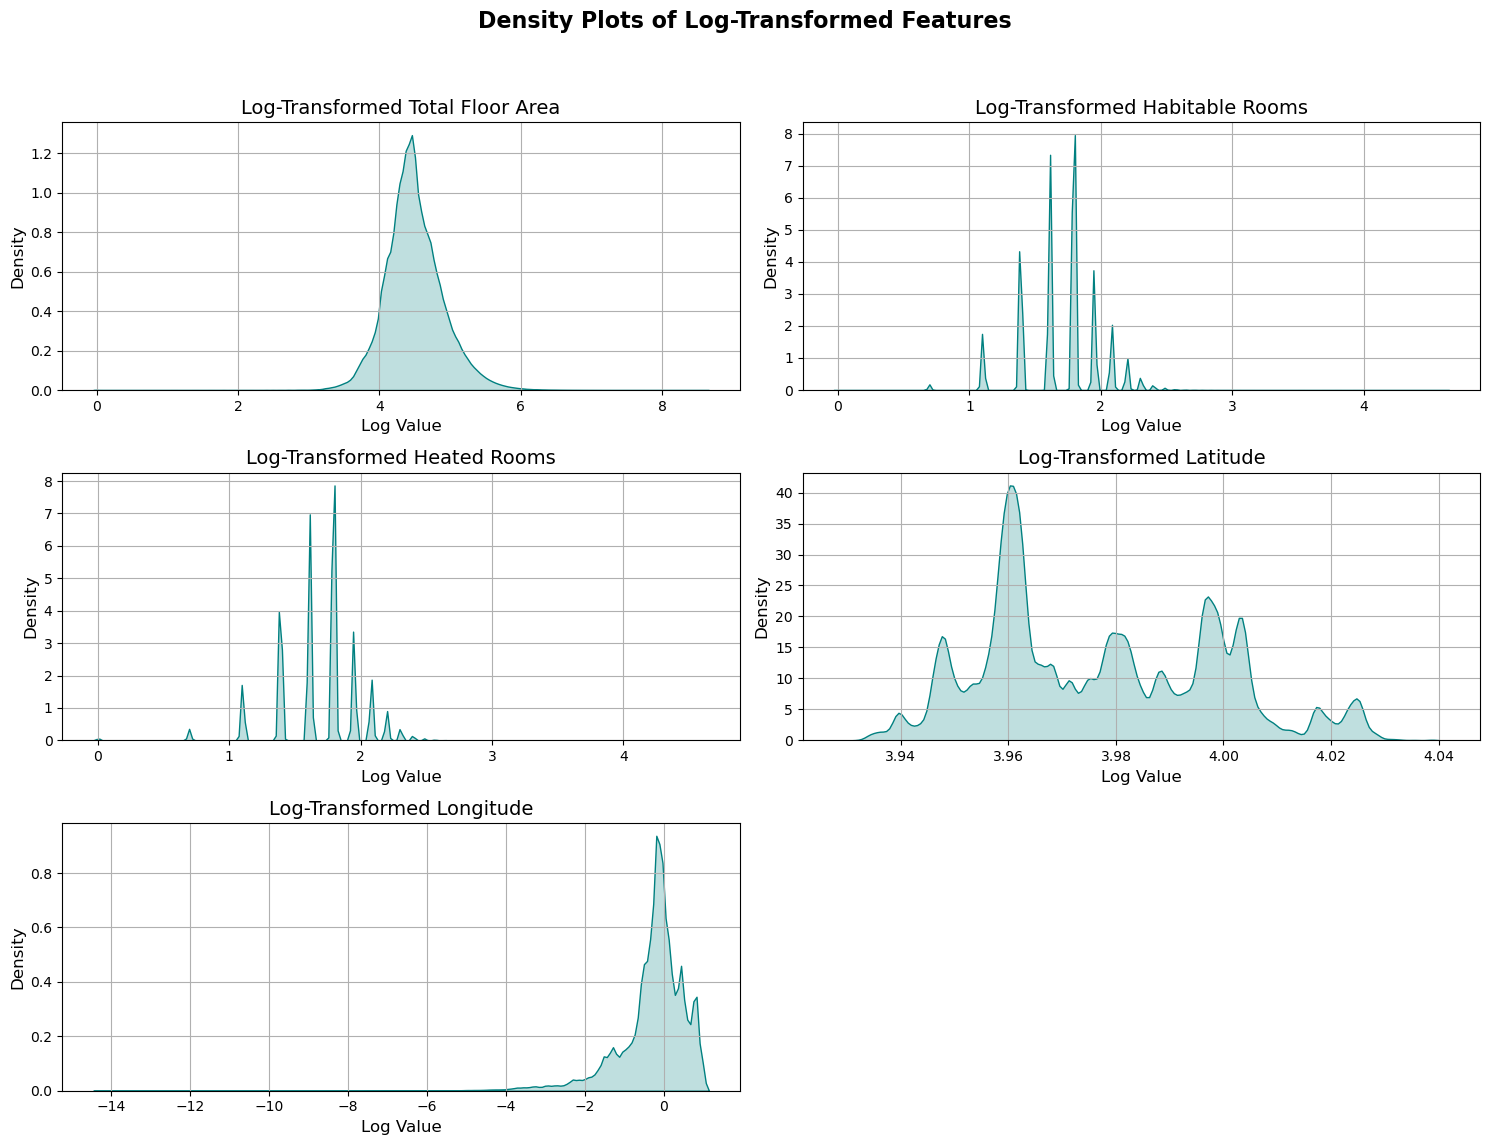

In [22]:
# Convert the relevant columns to a Pandas DataFrame
pandas_df = df_filled.select("total_floor_area", "number_habitable_rooms", "number_heated_rooms", "lat", "lon").toPandas()

# Apply log transformation to each column
pandas_df['log_total_floor_area'] = np.log(pandas_df['total_floor_area'] + 1)
pandas_df['log_number_habitable_rooms'] = np.log(pandas_df['number_habitable_rooms'] + 1)
pandas_df['log_number_heated_rooms'] = np.log(pandas_df['number_heated_rooms'] + 1)
pandas_df['log_lat'] = np.log(pandas_df['lat'] + 1)
pandas_df['log_lon'] = np.log(pandas_df['lon'] + 1)

# Set up the figure with a 3x2 layout
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Density Plots of Log-Transformed Features', fontsize=16, weight='bold')

# List of data and titles
plot_data = [
    (pandas_df['log_total_floor_area'], 'Log-Transformed Total Floor Area'),
    (pandas_df['log_number_habitable_rooms'], 'Log-Transformed Habitable Rooms'),
    (pandas_df['log_number_heated_rooms'], 'Log-Transformed Heated Rooms'),
    (pandas_df['log_lat'], 'Log-Transformed Latitude'),
    (pandas_df['log_lon'], 'Log-Transformed Longitude')
]

# Plot each subplot
for i, (data, title) in enumerate(plot_data):
    row, col = divmod(i, 2)
    sns.kdeplot(data, ax=axes[row, col], color='teal', fill=True)
    axes[row, col].set_title(title, fontsize=14)
    axes[row, col].set_xlabel('Log Value', fontsize=12)
    axes[row, col].set_ylabel('Density', fontsize=12)
    axes[row, col].grid(True)

# Hide the empty subplot
fig.delaxes(axes[2, 1])

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#### Scatter Plot

Bi-variate analysis of few most correlated features with target variable

/Users/riyamac/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


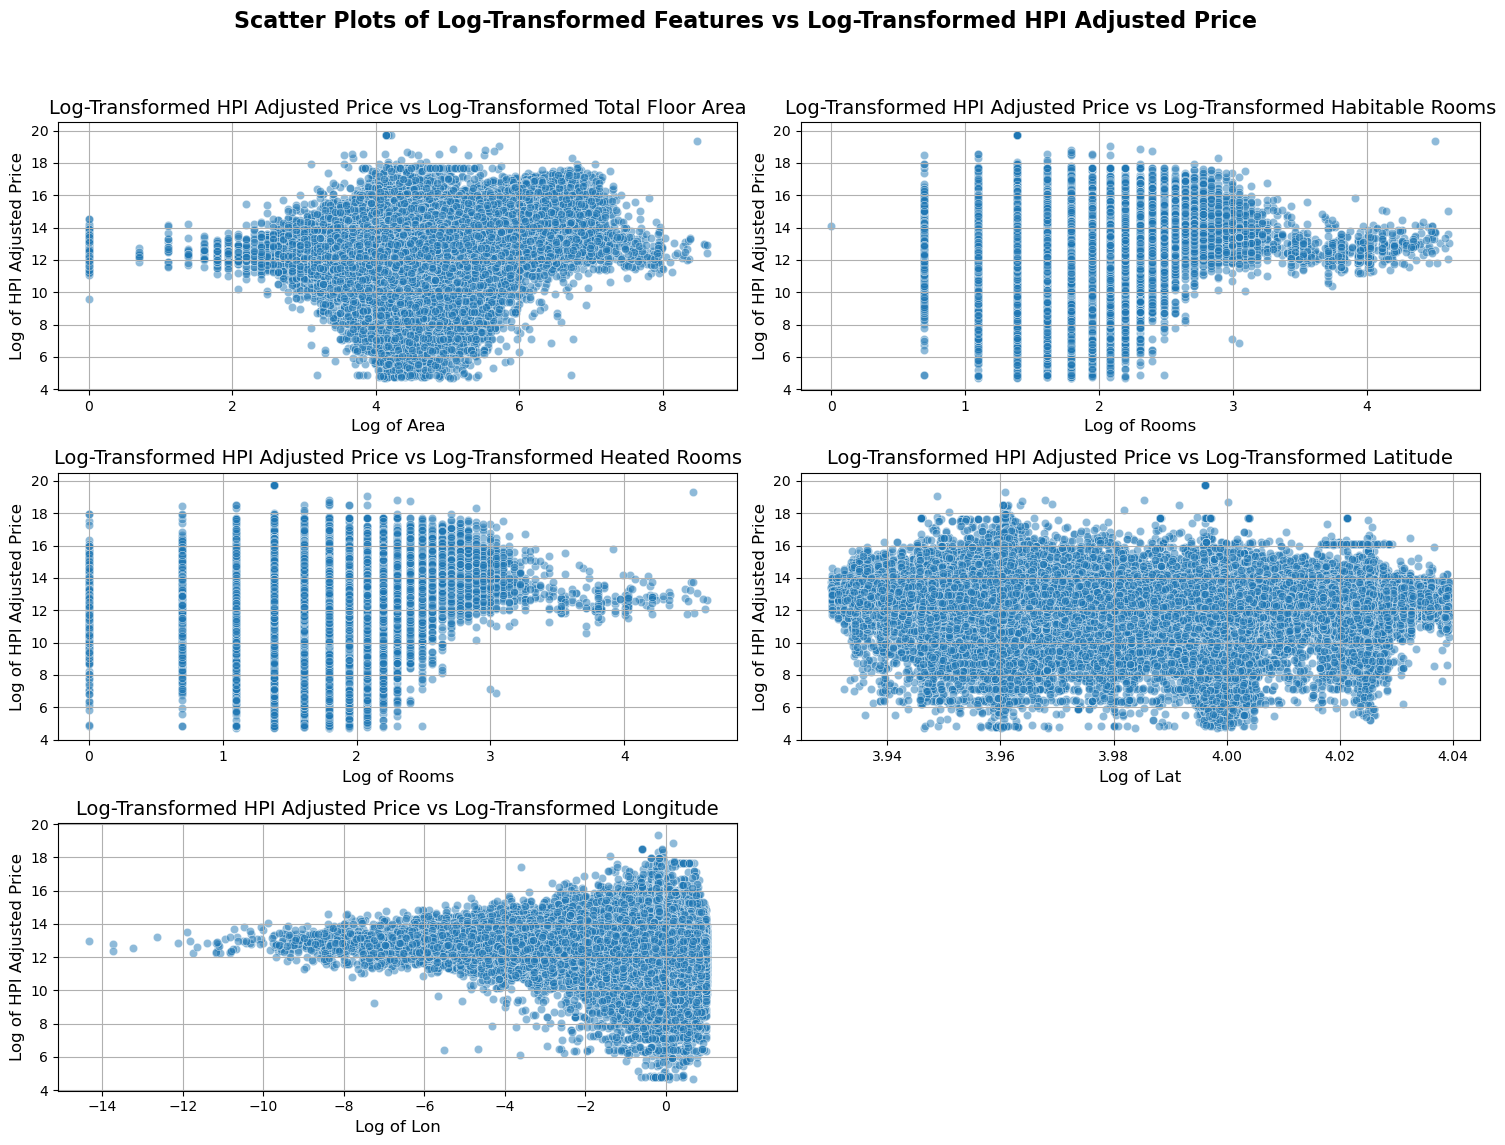

In [40]:
# Convert relevant columns to a Pandas DataFrame
pandas_df = df_filled.select("total_floor_area", "number_habitable_rooms", "number_heated_rooms", "lat", "lon", "hpi_adjusted_price").toPandas()

# Apply log transformation to each feature
pandas_df['log_total_floor_area'] = np.log(pandas_df['total_floor_area'] + 1)
pandas_df['log_number_habitable_rooms'] = np.log(pandas_df['number_habitable_rooms'] + 1)
pandas_df['log_number_heated_rooms'] = np.log(pandas_df['number_heated_rooms'] + 1)
pandas_df['log_lat'] = np.log(pandas_df['lat'] + 1)
pandas_df['log_lon'] = np.log(pandas_df['lon'] + 1)
pandas_df['log_hpi_adjusted_price'] = np.log(pandas_df['hpi_adjusted_price'] + 1)

# Set up the figure with a 3x2 layout
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Scatter Plots of Log-Transformed Features vs Log-Transformed HPI Adjusted Price', fontsize=16, weight='bold')

# List of data and titles
plot_data = [
    ('log_total_floor_area', 'Log-Transformed HPI Adjusted Price vs Log-Transformed Total Floor Area'),
    ('log_number_habitable_rooms', 'Log-Transformed HPI Adjusted Price vs Log-Transformed Habitable Rooms'),
    ('log_number_heated_rooms', 'Log-Transformed HPI Adjusted Price vs Log-Transformed Heated Rooms'),
    ('log_lat', 'Log-Transformed HPI Adjusted Price vs Log-Transformed Latitude'),
    ('log_lon', 'Log-Transformed HPI Adjusted Price vs Log-Transformed Longitude')
]

# Plot each subplot
for i, (x_col, title) in enumerate(plot_data):
    row, col = divmod(i, 2)
    sns.scatterplot(x=x_col, y='log_hpi_adjusted_price', data=pandas_df, alpha=0.5, ax=axes[row, col])
    axes[row, col].set_title(title, fontsize=14)
    axes[row, col].set_xlabel(f'Log of {x_col.split("_")[-1].replace("_", " ").title()}', fontsize=12)
    axes[row, col].set_ylabel('Log of HPI Adjusted Price', fontsize=12)
    axes[row, col].grid(True)

# Hide the last empty subplot
fig.delaxes(axes[2, 1])

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Feature Engineering of numerical columns

In [20]:
# Create gain features
df_filled = df_filled.withColumn("energy_efficiency_gain", col("potential_energy_efficiency") - col("current_energy_efficiency"))
df_filled = df_filled.withColumn("energy_consumption_gain", col("energy_consumption_potential") - col("energy_consumption_current"))


# Show resulting DataFrame with new gain features
df_filled.select("energy_efficiency_gain", "energy_consumption_gain").limit(5).toPandas()

energy_efficiency_gain  energy_consumption_gain
0                    14.0                   -116.0
1                    25.0                   -172.0
2                    17.0                   -140.0
3                    23.0                   -178.0
4                    34.0                   -168.0

In [21]:
#checking the correlation of the old features and the new feature

target_variable = 'hpi_adjusted_price'

# List of columns to calculate Spearman correlation with
columns_of_interest = [
    'potential_energy_efficiency', 'energy_efficiency_gain', 'current_energy_efficiency',
    'energy_consumption_potential', 'energy_consumption_gain', 
    'energy_consumption_current'
]

# Function to calculate Spearman correlation with the target variable
def calculate_spearman_correlation(df, target_col, columns):
    spearman_corr = []
    
    for col_name in columns:
        # Rank the columns
        df = df.withColumn(f'{col_name}_rank', rank().over(Window.orderBy(col(col_name).cast(DoubleType()))))
        df = df.withColumn(f'{target_col}_rank', rank().over(Window.orderBy(col(target_col).cast(DoubleType()))))
        
        # Calculate Pearson correlation of ranks (equivalent to Spearman correlation)
        corr = df.stat.corr(f'{col_name}_rank', f'{target_col}_rank')
        spearman_corr.append((col_name, corr))
        
        # Drop the rank columns to save space
        df = df.drop(f'{col_name}_rank').drop(f'{target_col}_rank')
    
    return spearman_corr

# Calculate Spearman correlation
spearman_correlations = calculate_spearman_correlation(df_filled, target_variable, columns_of_interest)

# Print the Spearman correlations
for col_name, corr in spearman_correlations:
    print(f"Spearman correlation between {target_variable} and {col_name}: {corr}")

Spearman correlation between hpi_adjusted_price and potential_energy_efficiency: -0.11939414719391644
Spearman correlation between hpi_adjusted_price and energy_efficiency_gain: -0.12619958042148366
Spearman correlation between hpi_adjusted_price and current_energy_efficiency: 0.025072742214445377
Spearman correlation between hpi_adjusted_price and energy_consumption_potential: -0.09464802368404845
Spearman correlation between hpi_adjusted_price and energy_consumption_gain: 0.19020045105210104
Spearman correlation between hpi_adjusted_price and energy_consumption_current: -0.22979049547016422


In [22]:
#dropping the least correlated columns
ncolumns_to_drop = [ 'potential_energy_efficiency', 'energy_consumption_potential']
df_filled = df_filled.drop(*ncolumns_to_drop)

### Dealing with categorical and boolean columns

In [23]:
# Identify categorical and Boolean columns
categorical_columns = [col_name for col_name, dtype in df_filled.dtypes if dtype == 'string']
boolean_columns = [col_name for col_name, dtype in df_filled.dtypes if dtype == 'boolean']

print("Categorical columns:")
print(categorical_columns)

print("Boolean columns:")
print(boolean_columns)

Categorical columns:
['current_energy_rating', 'potential_energy_rating', 'property_type', 'build_form', 'local_authority', 'constituency', 'county', 'transaction_type', 'energy_tariff', 'mains_gas_flag', 'flat_top_storey', 'main_heating_controls', 'glazed_type', 'glazed_area', 'hotwater_description', 'hot_water_energy_eff', 'hot_water_env_eff', 'floor_description', 'floor_energy_eff', 'floor_env_eff', 'windows_description', 'windows_energy_eff', 'windows_env_eff', 'walls_description', 'walls_energy_eff', 'walls_env_eff', 'secondheat_description', 'roof_description', 'roof_energy_eff', 'roof_env_eff', 'mainheat_description', 'mainheat_energy_eff', 'mainheat_env_eff', 'mainheatcont_description', 'mainheatc_energy_eff', 'mainheatc_env_eff', 'lighting_description', 'lighting_energy_eff', 'lighting_env_eff', 'main_fuel', 'solar_water_heating_flag', 'mechanical_ventilation', 'local_authority_label', 'constituency_label', 'construction_age_band', 'tenure', 'improvement_id', 'improvement_item

#### Cleaning and processing categoric and boolean columns

In [24]:
# Fill null values in categorical columns with "Unknown"
df_filled = df_filled.fillna("Unknown", subset=categorical_columns)

# Fill null values in Boolean columns with False (0)
df_filled = df_filled.fillna(False, subset=boolean_columns)

# Convert Boolean columns to integers (0 and 1)
for col_name in boolean_columns:
    df_filled = df_filled.withColumn(col_name, col(col_name).cast('integer'))


#### EDA of categoric and boolean columns

#### Bar Chart

univariate analysis of few most important property features

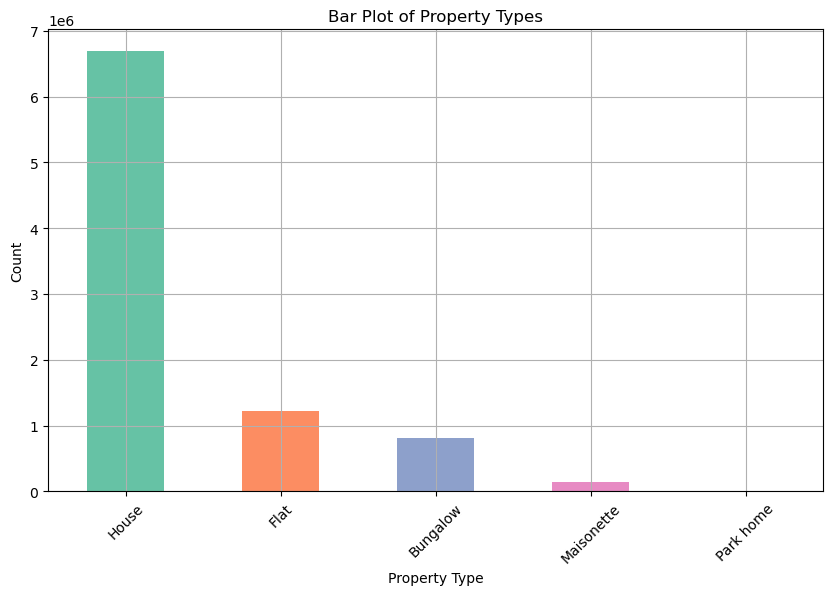

In [29]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("property_type").toPandas()

# Calculate the count of each property type
property_counts = pandas_df['property_type'].value_counts()

# Plot the bar plot for 'property_type'
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(property_counts))  
property_counts.plot(kind='bar', color=colors)
plt.title('Bar Plot of Property Types')
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

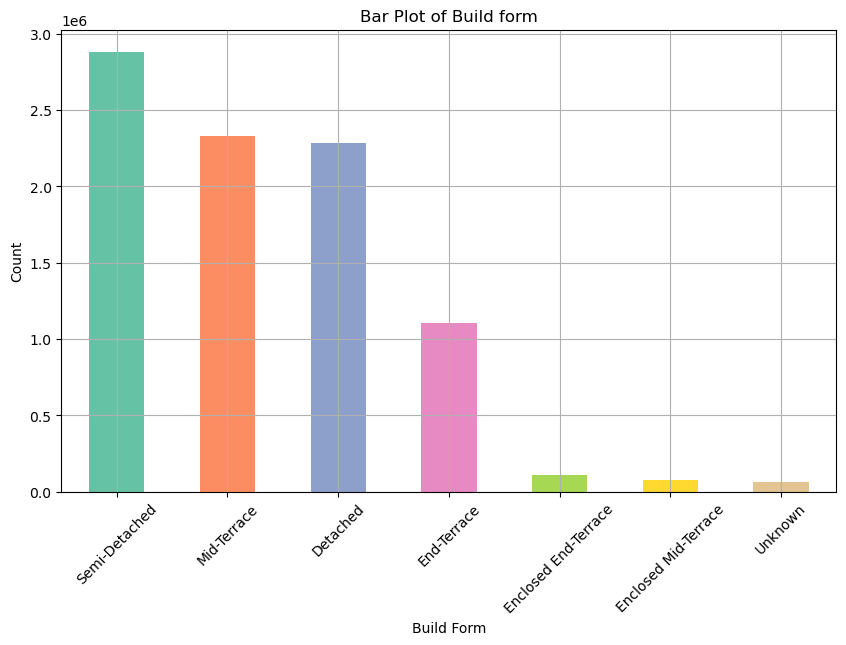

In [30]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("build_form").toPandas()

# Calculate the count of each property type
property_counts = pandas_df['build_form'].value_counts()

# Plot the bar plot for 'property_type'
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(property_counts))  
property_counts.plot(kind='bar', color=colors)
plt.title('Bar Plot of Build form')
plt.xlabel('Build Form')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

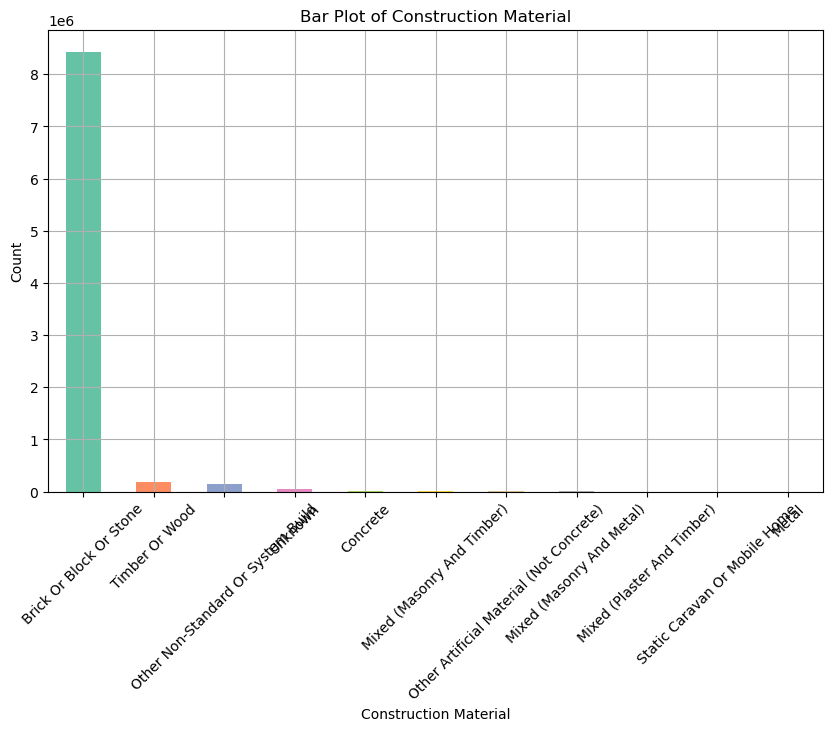

In [31]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("constructionmaterial").toPandas()

# Calculate the count of each property type
property_counts = pandas_df['constructionmaterial'].value_counts()

# Plot the bar plot for 'property_type'
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(property_counts))  
property_counts.plot(kind='bar', color=colors)
plt.title('Bar Plot of Construction Material')
plt.xlabel('Construction Material')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

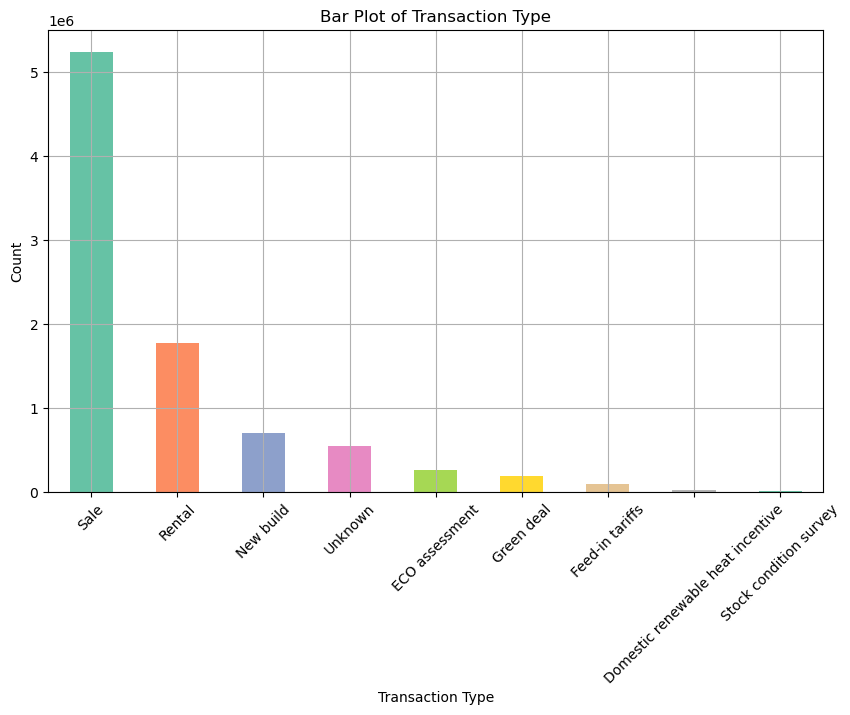

In [32]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("transaction_type").toPandas()

# Calculate the count of each property type
property_counts = pandas_df['transaction_type'].value_counts()

# Plot the bar plot for 'property_type'
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(property_counts))  
property_counts.plot(kind='bar', color=colors)
plt.title('Bar Plot of Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

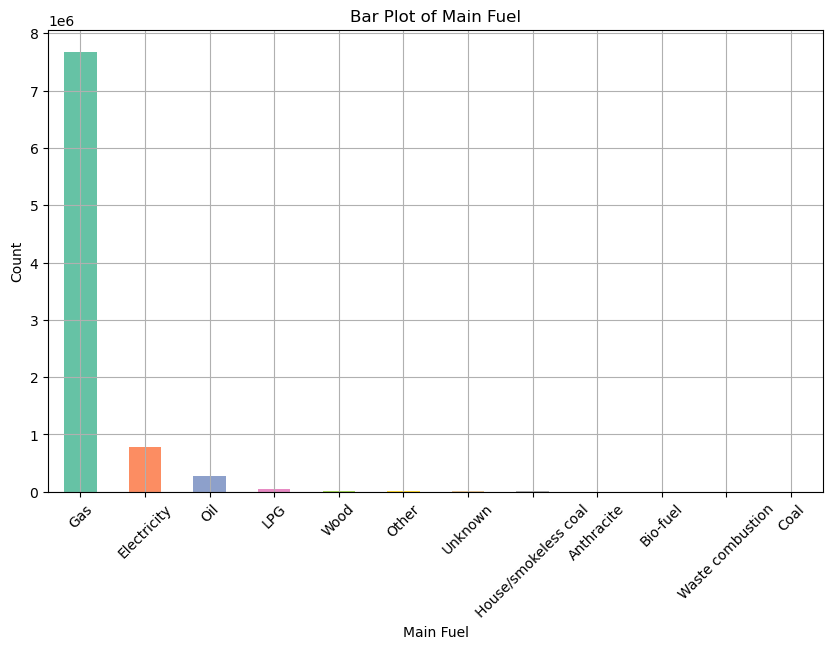

In [33]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("main_fuel").toPandas()

# Calculate the count of each property type
property_counts = pandas_df['main_fuel'].value_counts()

# Plot the bar plot for 'property_type'
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(property_counts))  
property_counts.plot(kind='bar', color=colors)
plt.title('Bar Plot of Main Fuel')
plt.xlabel('Main Fuel')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

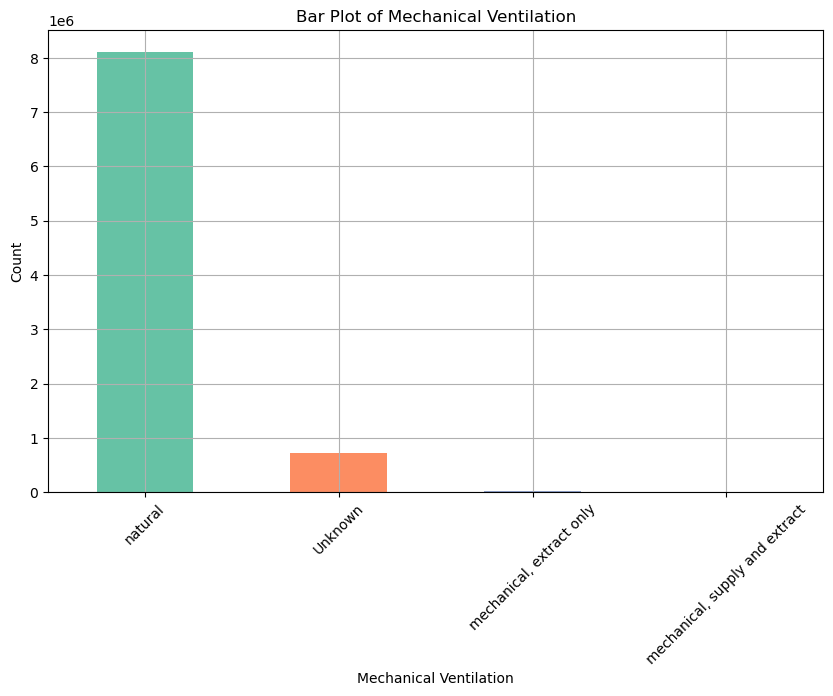

In [34]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("mechanical_ventilation").toPandas()

# Calculate the count of each property type
property_counts = pandas_df['mechanical_ventilation'].value_counts()

# Plot the bar plot for 'property_type'
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(property_counts))  
property_counts.plot(kind='bar', color=colors)
plt.title('Bar Plot of Mechanical Ventilation')
plt.xlabel('Mechanical Ventilation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

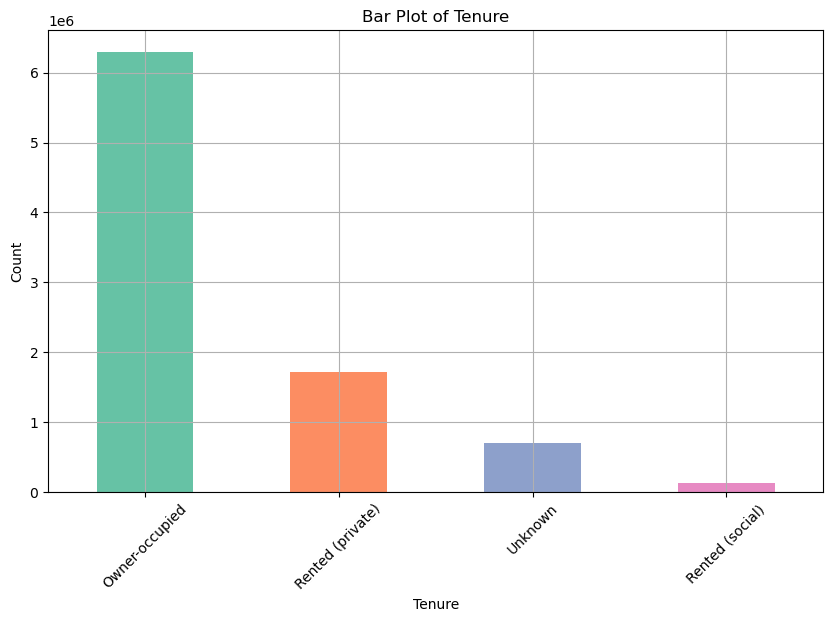

In [35]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("tenure").toPandas()

# Calculate the count of each property type
property_counts = pandas_df['tenure'].value_counts()

# Plot the bar plot for 'property_type'
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(property_counts))  
property_counts.plot(kind='bar', color=colors)
plt.title('Bar Plot of Tenure')
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

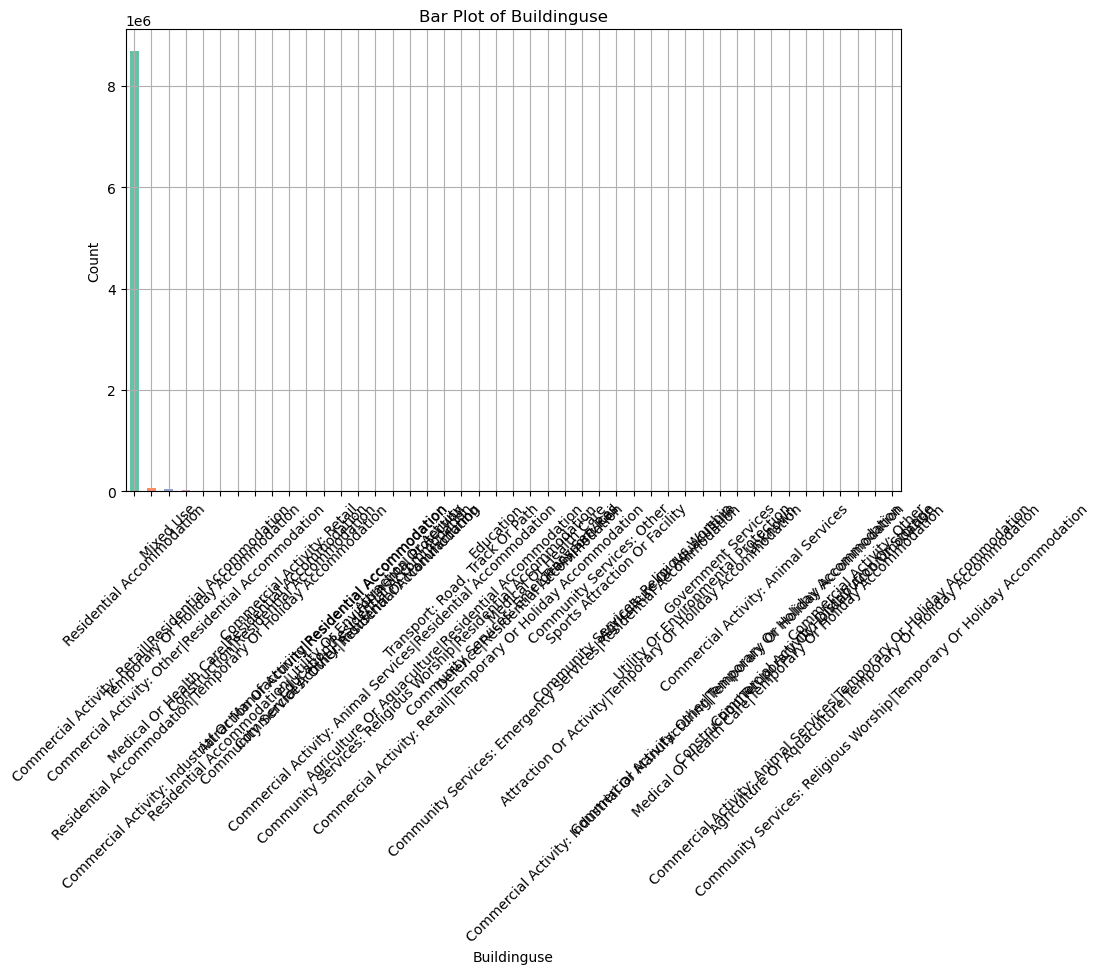

In [36]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("buildinguse").toPandas()

# Calculate the count of each property type
property_counts = pandas_df['buildinguse'].value_counts()

# Plot the bar plot for 'property_type'
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(property_counts))  
property_counts.plot(kind='bar', color=colors)
plt.title('Bar Plot of Buildinguse')
plt.xlabel('Buildinguse')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

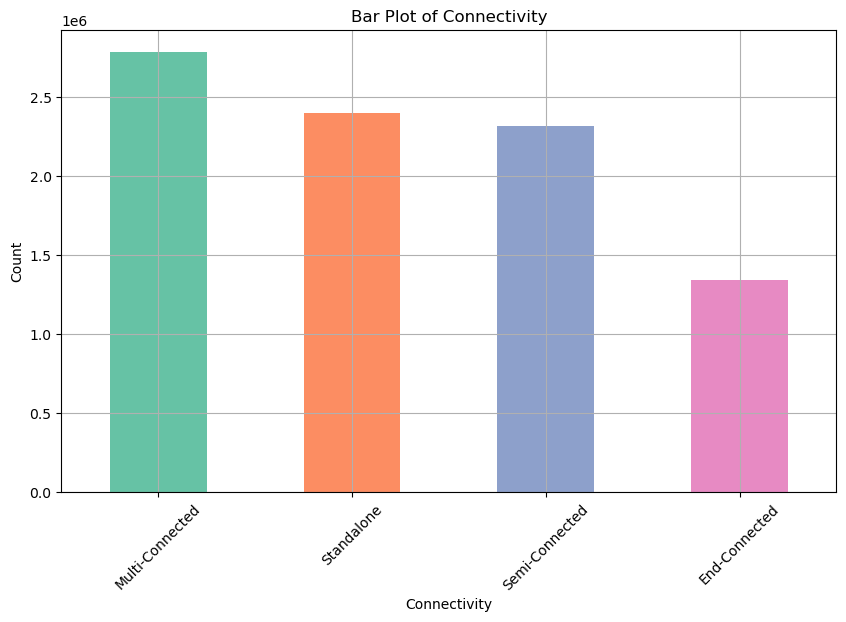

In [37]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("connectivity").toPandas()

# Calculate the count of each property type
property_counts = pandas_df['connectivity'].value_counts()

# Plot the bar plot for 'property_type'
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(property_counts))  
property_counts.plot(kind='bar', color=colors)
plt.title('Bar Plot of Connectivity')
plt.xlabel('Connectivity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

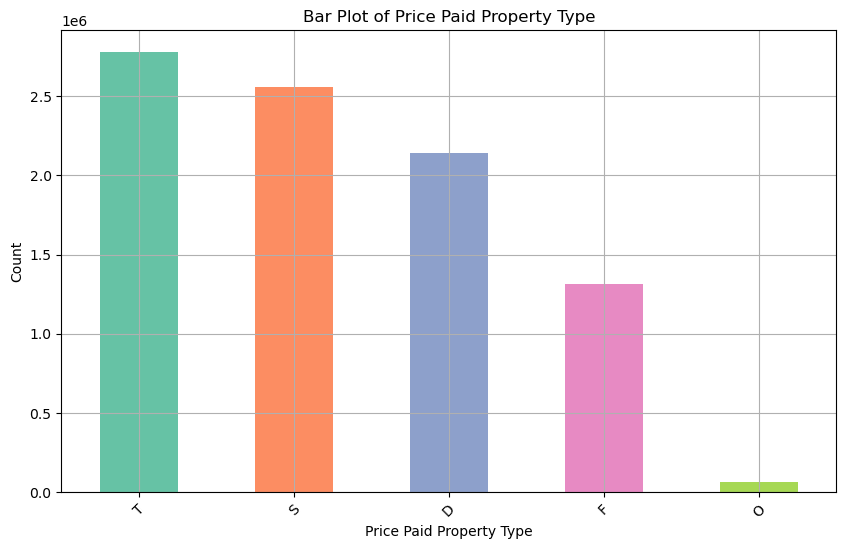

In [38]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("price_paid_property_type").toPandas()

# Calculate the count of each property type
property_counts = pandas_df['price_paid_property_type'].value_counts()

# Plot the bar plot for 'property_type'
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Set2", len(property_counts))  
property_counts.plot(kind='bar', color=colors)
plt.title('Bar Plot of Price Paid Property Type')
plt.xlabel('Price Paid Property Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Violin Plot

Bivariate analysis of few most important property features with target variable

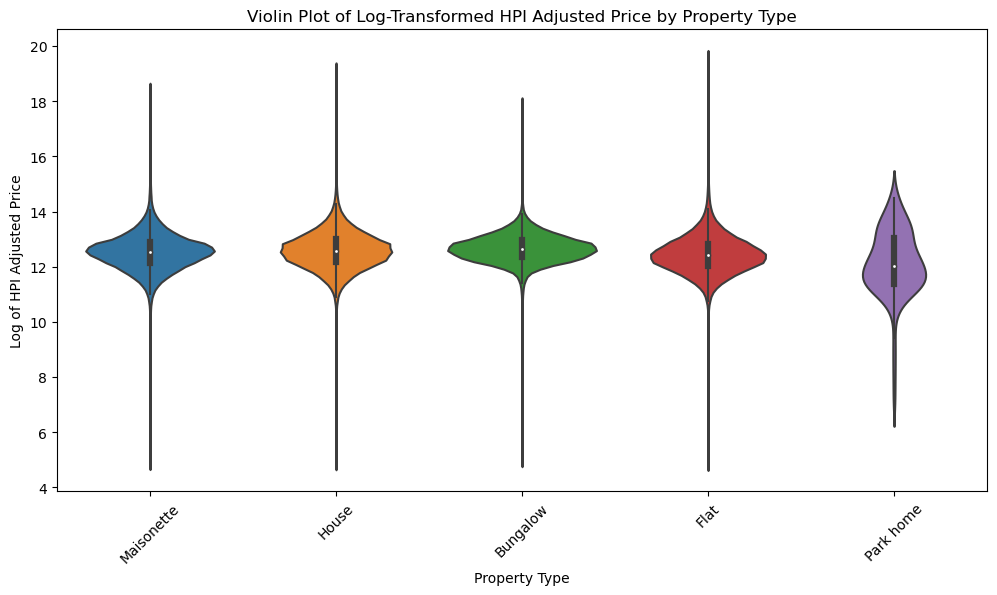

In [39]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("property_type", "hpi_adjusted_price").toPandas()

# Apply log transformation to house prices
pandas_df['log_hpi_adjusted_price'] = np.log(pandas_df['hpi_adjusted_price'] + 1)  # Adding 1 to avoid log(0)

# Plot the log-transformed data using a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='property_type', y='log_hpi_adjusted_price', data=pandas_df)
plt.title('Violin Plot of Log-Transformed HPI Adjusted Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Log of HPI Adjusted Price')
plt.xticks(rotation=45)
plt.show()

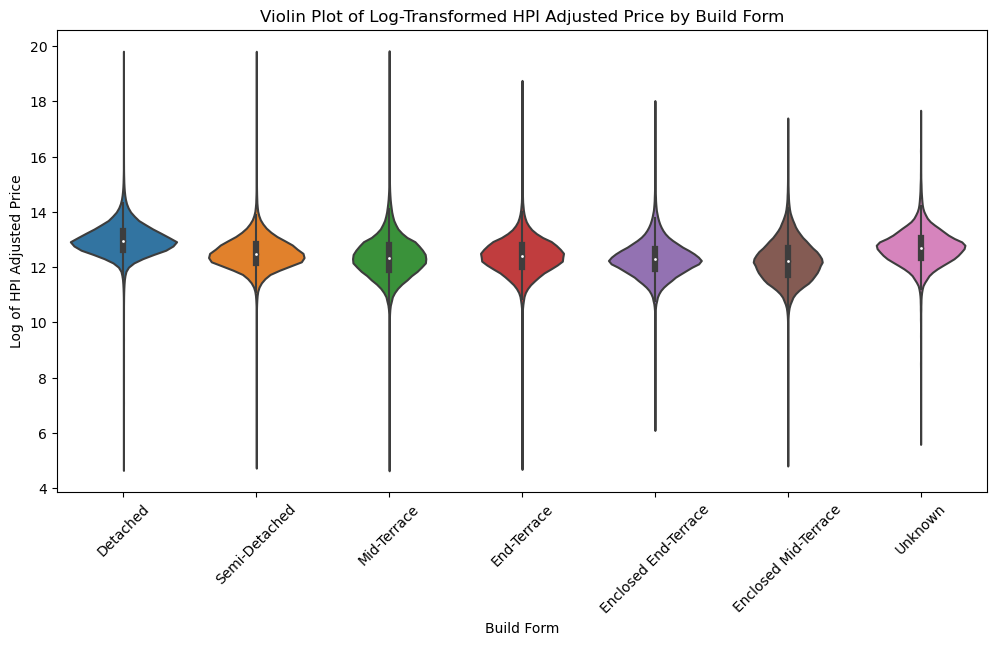

In [40]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("build_form", "hpi_adjusted_price").toPandas()

# Apply log transformation to house prices
pandas_df['log_hpi_adjusted_price'] = np.log(pandas_df['hpi_adjusted_price'] + 1)  # Adding 1 to avoid log(0)

# Plot the log-transformed data using a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='build_form', y='log_hpi_adjusted_price', data=pandas_df)
plt.title('Violin Plot of Log-Transformed HPI Adjusted Price by Build Form')
plt.xlabel('Build Form')
plt.ylabel('Log of HPI Adjusted Price')
plt.xticks(rotation=45)
plt.show()

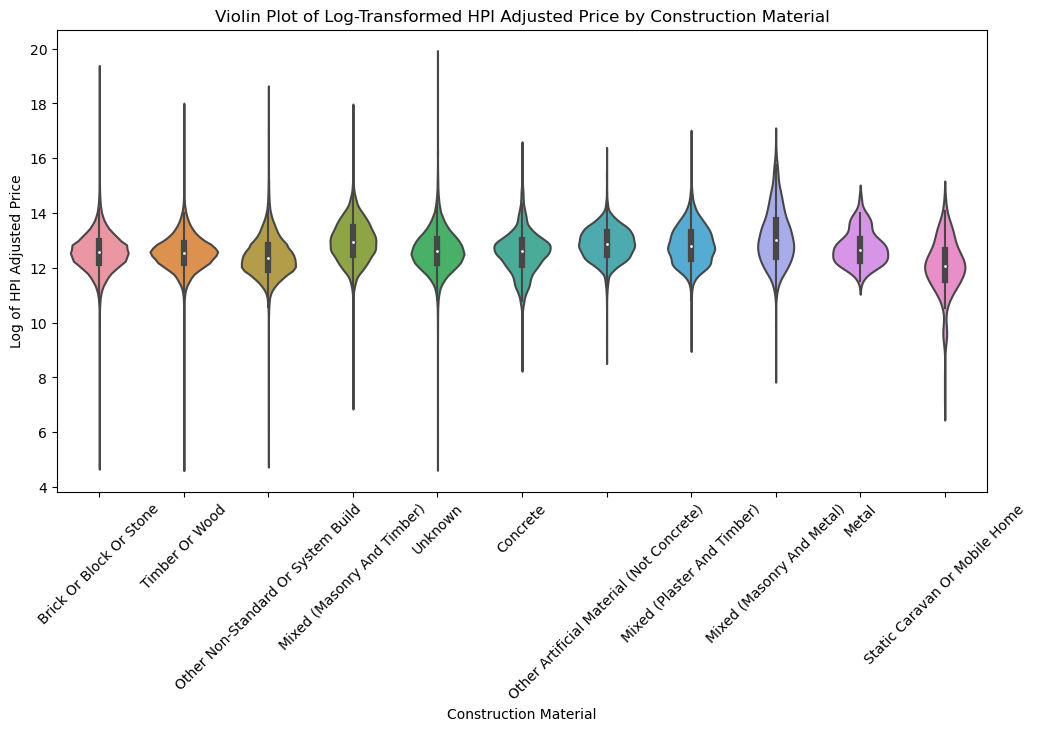

In [41]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("constructionmaterial", "hpi_adjusted_price").toPandas()

# Apply log transformation to house prices
pandas_df['log_hpi_adjusted_price'] = np.log(pandas_df['hpi_adjusted_price'] + 1)  # Adding 1 to avoid log(0)

# Plot the log-transformed data using a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='constructionmaterial', y='log_hpi_adjusted_price', data=pandas_df)
plt.title('Violin Plot of Log-Transformed HPI Adjusted Price by Construction Material')
plt.xlabel('Construction Material')
plt.ylabel('Log of HPI Adjusted Price')
plt.xticks(rotation=45)
plt.show()

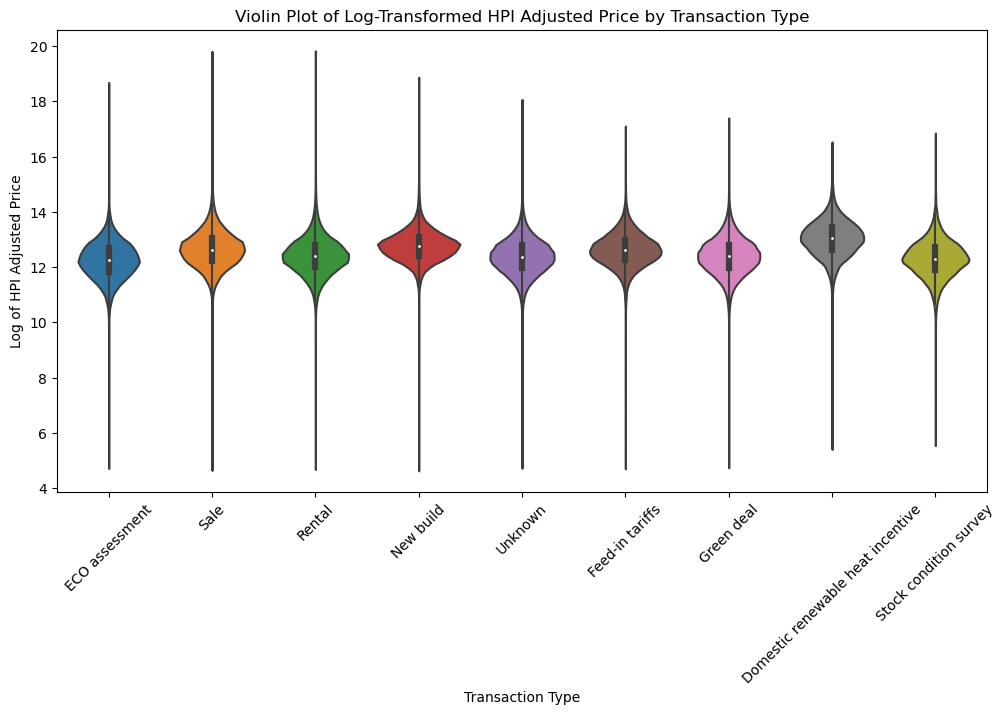

In [42]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("transaction_type", "hpi_adjusted_price").toPandas()

# Apply log transformation to house prices
pandas_df['log_hpi_adjusted_price'] = np.log(pandas_df['hpi_adjusted_price'] + 1)  # Adding 1 to avoid log(0)

# Plot the log-transformed data using a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='transaction_type', y='log_hpi_adjusted_price', data=pandas_df)
plt.title('Violin Plot of Log-Transformed HPI Adjusted Price by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Log of HPI Adjusted Price')
plt.xticks(rotation=45)
plt.show()

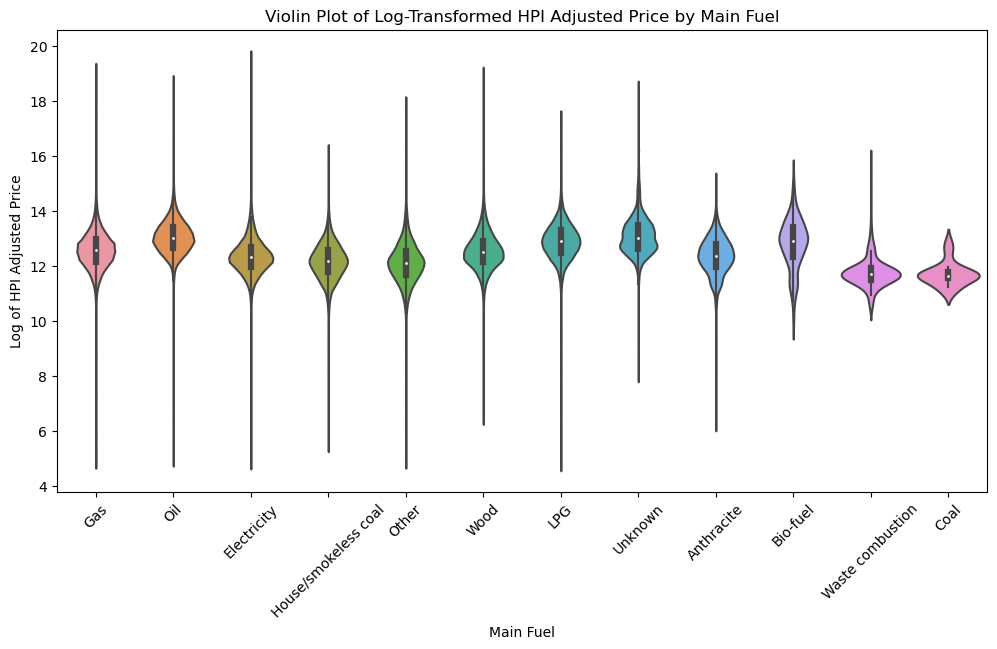

In [43]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("main_fuel", "hpi_adjusted_price").toPandas()

# Apply log transformation to house prices
pandas_df['log_hpi_adjusted_price'] = np.log(pandas_df['hpi_adjusted_price'] + 1)  # Adding 1 to avoid log(0)

# Plot the log-transformed data using a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='main_fuel', y='log_hpi_adjusted_price', data=pandas_df)
plt.title('Violin Plot of Log-Transformed HPI Adjusted Price by Main Fuel')
plt.xlabel('Main Fuel')
plt.ylabel('Log of HPI Adjusted Price')
plt.xticks(rotation=45)
plt.show()

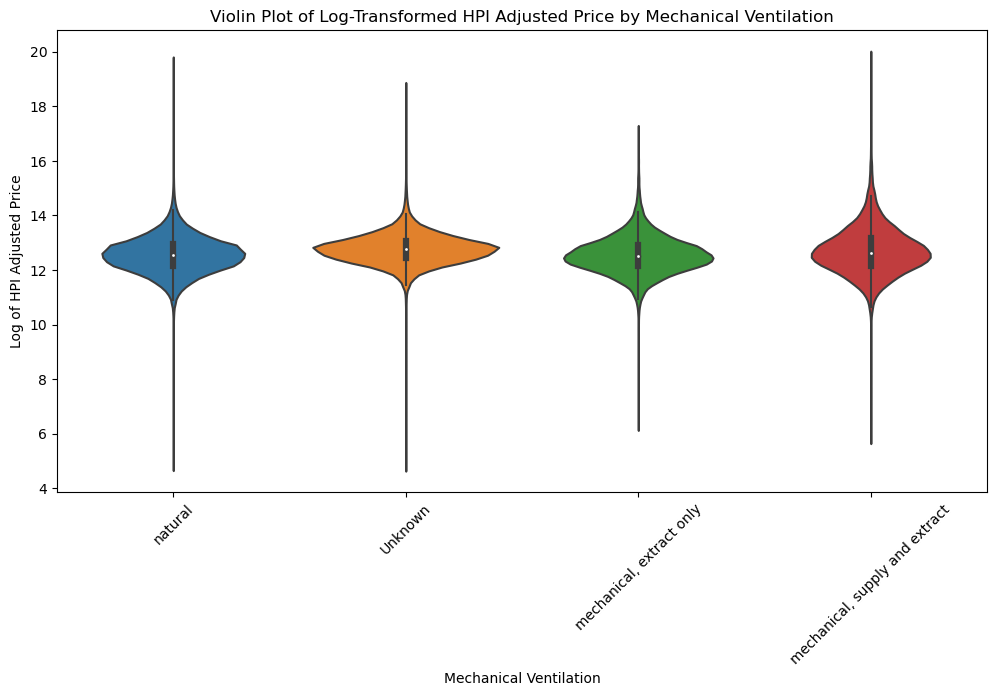

In [44]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("mechanical_ventilation", "hpi_adjusted_price").toPandas()

# Apply log transformation to house prices
pandas_df['log_hpi_adjusted_price'] = np.log(pandas_df['hpi_adjusted_price'] + 1)  # Adding 1 to avoid log(0)

# Plot the log-transformed data using a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='mechanical_ventilation', y='log_hpi_adjusted_price', data=pandas_df)
plt.title('Violin Plot of Log-Transformed HPI Adjusted Price by Mechanical Ventilation')
plt.xlabel('Mechanical Ventilation')
plt.ylabel('Log of HPI Adjusted Price')
plt.xticks(rotation=45)
plt.show()

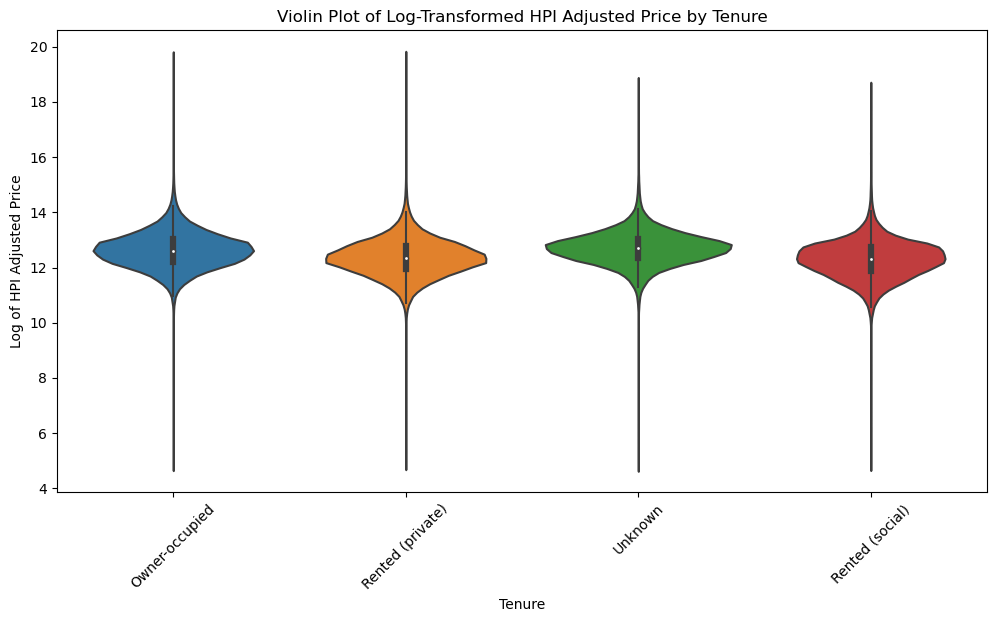

In [45]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("tenure", "hpi_adjusted_price").toPandas()

# Apply log transformation to house prices
pandas_df['log_hpi_adjusted_price'] = np.log(pandas_df['hpi_adjusted_price'] + 1)  # Adding 1 to avoid log(0)

# Plot the log-transformed data using a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='tenure', y='log_hpi_adjusted_price', data=pandas_df)
plt.title('Violin Plot of Log-Transformed HPI Adjusted Price by Tenure')
plt.xlabel('Tenure')
plt.ylabel('Log of HPI Adjusted Price')
plt.xticks(rotation=45)
plt.show()

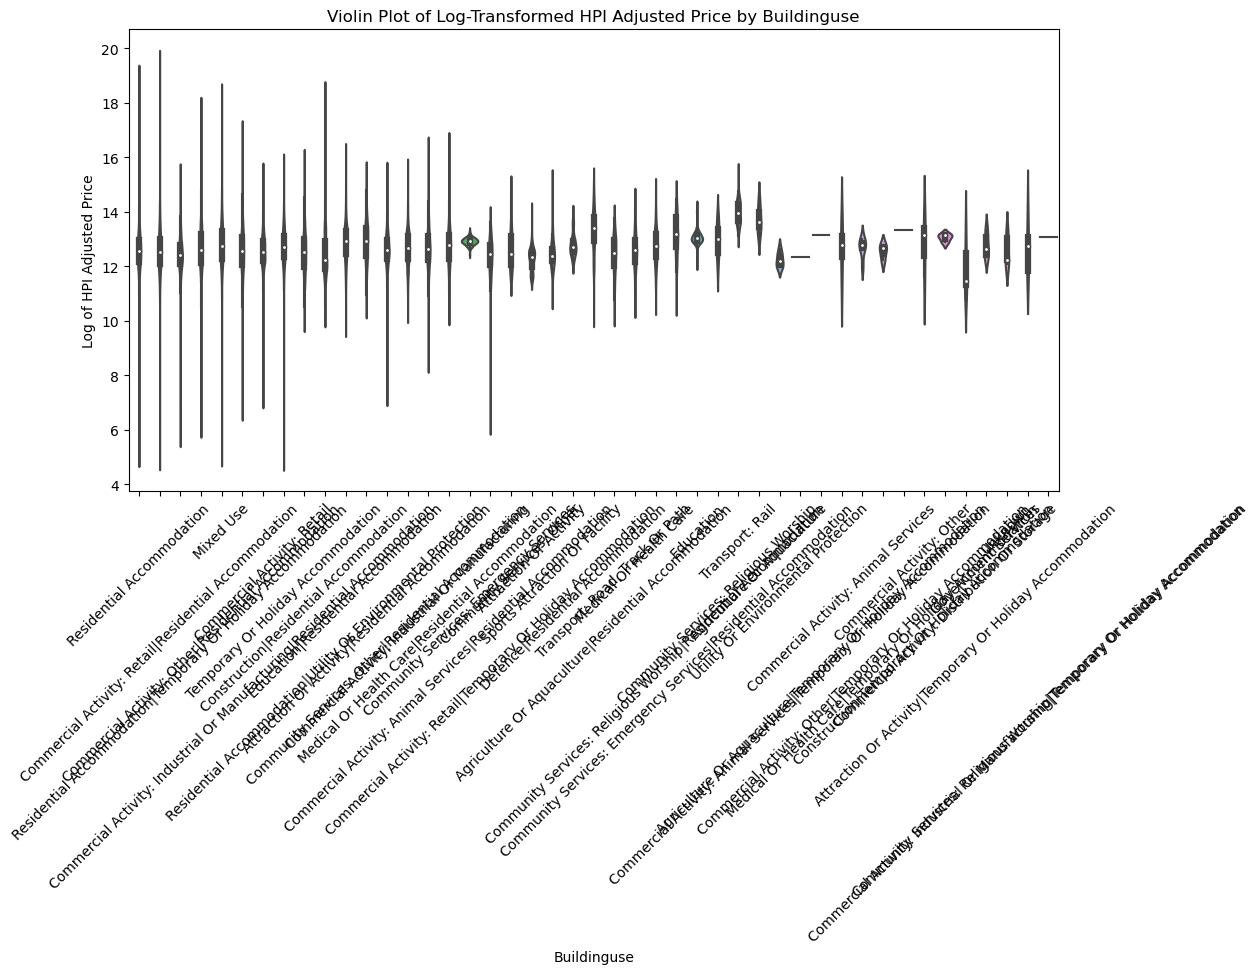

In [46]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("buildinguse", "hpi_adjusted_price").toPandas()

# Apply log transformation to house prices
pandas_df['log_hpi_adjusted_price'] = np.log(pandas_df['hpi_adjusted_price'] + 1)  # Adding 1 to avoid log(0)

# Plot the log-transformed data using a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='buildinguse', y='log_hpi_adjusted_price', data=pandas_df)
plt.title('Violin Plot of Log-Transformed HPI Adjusted Price by Buildinguse')
plt.xlabel('Buildinguse')
plt.ylabel('Log of HPI Adjusted Price')
plt.xticks(rotation=45)
plt.show()

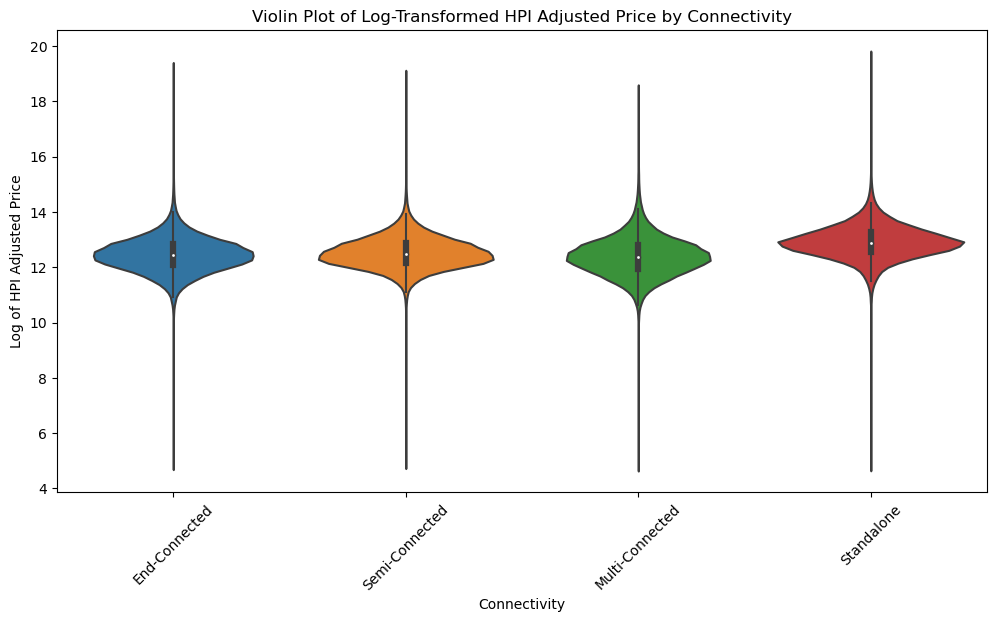

In [47]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("connectivity", "hpi_adjusted_price").toPandas()

# Apply log transformation to house prices
pandas_df['log_hpi_adjusted_price'] = np.log(pandas_df['hpi_adjusted_price'] + 1)  # Adding 1 to avoid log(0)

# Plot the log-transformed data using a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='connectivity', y='log_hpi_adjusted_price', data=pandas_df)
plt.title('Violin Plot of Log-Transformed HPI Adjusted Price by Connectivity')
plt.xlabel('Connectivity')
plt.ylabel('Log of HPI Adjusted Price')
plt.xticks(rotation=45)
plt.show()

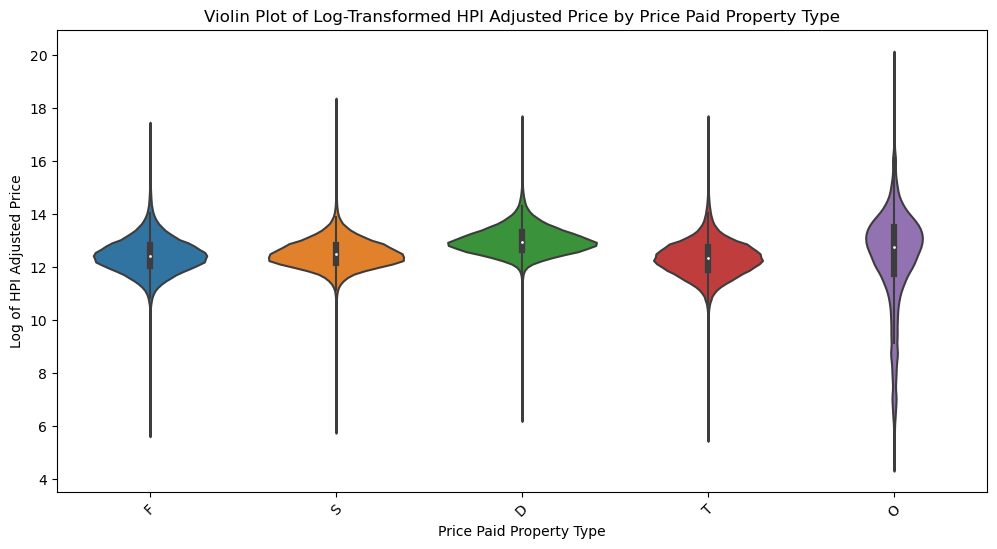

In [48]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("price_paid_property_type", "hpi_adjusted_price").toPandas()

# Apply log transformation to house prices
pandas_df['log_hpi_adjusted_price'] = np.log(pandas_df['hpi_adjusted_price'] + 1)  # Adding 1 to avoid log(0)

# Plot the log-transformed data using a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='price_paid_property_type', y='log_hpi_adjusted_price', data=pandas_df)
plt.title('Violin Plot of Log-Transformed HPI Adjusted Price by Price Paid Property Type')
plt.xlabel('Price Paid Property Type')
plt.ylabel('Log of HPI Adjusted Price')
plt.xticks(rotation=45)
plt.show()

#### Feature Engineering of categorical columns

Encoding needed categorical columns

In [25]:
# Define the columns to encode
columns_to_encode = ['current_energy_rating','potential_energy_rating']  

# Create the encoding dictionary 
encoding_map = {"A": 7, "B": 6, "C": 5, "D": 4, "E": 3, "F": 2, "G":1}  

# Create a function to perform the encoding
def encode_energy_eff(df, col_name):
    mapping_expr = when(col(col_name) == "A", 7) \
        .when(col(col_name) == "B", 6) \
        .when(col(col_name) == "C", 5) \
        .when(col(col_name) == "D", 4) \
        .when(col(col_name) == "E", 3) \
        .when(col(col_name) == "F", 2) \
        .when(col(col_name) == "G", 1)

    new_col_name = col_name + "_encoded"  # Name the new encoded column
    return df.withColumn(new_col_name, mapping_expr)

# Loop through the columns and apply the encoding function
for column in columns_to_encode:
    df_filled = encode_energy_eff(df_filled, column)

# Show the first 5 rows of the encoded columns (along with the original for comparison)
df_filled.select(
    *[item for tup in [(col(c), col(f"{c}_encoded")) for c in columns_to_encode] for item in tup]
).limit(5).toPandas()

current_energy_rating  current_energy_rating_encoded  \
0                     E                              3   
1                     E                              3   
2                     D                              4   
3                     D                              4   
4                     E                              3   

  potential_energy_rating  potential_energy_rating_encoded  
0                       D                                4  
1                       C                                5  
2                       C                                5  
3                       B                                6  
4                       C                                5

In [26]:
# Define the columns to encode
columns_to_encode = ["hot_water_energy_eff","hot_water_env_eff", "floor_env_eff", "windows_energy_eff","windows_env_eff","walls_energy_eff",
                    "walls_env_eff","roof_energy_eff","roof_env_eff","mainheat_energy_eff","mainheat_env_eff",
                    "mainheatc_energy_eff","mainheatc_env_eff","lighting_env_eff",'lighting_env_eff',"floor_energy_eff","lighting_energy_eff"]  # Add more as needed

# Create the encoding dictionary 
encoding_map = {"Very Poor": 1, "Poor": 2, "Average": 3, "Good": 4, "Very Good": 5, "N/A": 0}  

# Create a function to perform the encoding
def encode_energy_eff(df, col_name):
    mapping_expr = when(col(col_name) == "Very Poor", 1) \
        .when(col(col_name) == "Poor", 2) \
        .when(col(col_name) == "Average", 3) \
        .when(col(col_name) == "Good", 4) \
        .when(col(col_name) == "Very Good", 5) \
        .otherwise(0)  # For "N/A"

    new_col_name = col_name + "_encoded"  # Name the new encoded column
    return df.withColumn(new_col_name, mapping_expr)

# Loop through the columns and apply the encoding function
for column in columns_to_encode:
    df_filled = encode_energy_eff(df_filled, column)

# Show the first 5 rows of the encoded columns (along with the original for comparison)
df_filled.select(
    *[item for tup in [(col(c), col(f"{c}_encoded")) for c in columns_to_encode] for item in tup]
).limit(5).toPandas()

hot_water_energy_eff  hot_water_energy_eff_encoded hot_water_env_eff  \
0                 Good                             4              Good   
1                 Good                             4              Good   
2                 Poor                             2           Average   
3                 Good                             4              Good   
4              Average                             3           Average   

   hot_water_env_eff_encoded floor_env_eff  floor_env_eff_encoded  \
0                          4           N/A                      0   
1                          4           N/A                      0   
2                          3           N/A                      0   
3                          4           N/A                      0   
4                          3           N/A                      0   

  windows_energy_eff  windows_energy_eff_encoded windows_env_eff  \
0            Average                           3         Average   
1            Average                           3         Average   
2            Average                           3         Average   
3            Average                           3         Average   
4          Very Poor                           1       Very Poor   

   windows_env_eff_encoded walls_energy_eff  walls_energy_eff_encoded  \
0                        3             Poor                         2   
1                        3             Poor                         2   
2                        3             Good                         4   
3                        3          Average                         3   
4                        1             Good                         4   

  walls_env_eff  walls_env_eff_encoded roof_energy_eff  \
0          Poor                      2       Very Poor   
1          Poor                      2            Good   
2          Good                      4         Average   
3       Average                      3            Good   
4          Good                      4       Very Poor   

   roof_energy_eff_encoded roof_env_eff  roof_env_eff_encoded  \
0                        1    Very Poor                     1   
1                        4         Good                     4   
2                        3      Average                     3   
3                        4         Good                     4   
4                        1    Very Poor                     1   

  mainheat_energy_eff  mainheat_energy_eff_encoded mainheat_env_eff  \
0                Good                            4             Good   
1                Good                            4             Good   
2             Average                            3             Good   
3                Good                            4             Good   
4             Average                            3             Good   

   mainheat_env_eff_encoded mainheatc_energy_eff  \
0                         4            Very Poor   
1                         4                 Good   
2                         4              Average   
3                         4            Very Poor   
4                         4                 Good   

   mainheatc_energy_eff_encoded mainheatc_env_eff  mainheatc_env_eff_encoded  \
0                             1         Very Poor                          1   
1                             4              Good                          4   
2                             3           Average                          3   
3                             1         Very Poor                          1   
4                             4              Good                          4   

  lighting_env_eff  lighting_env_eff_encoded lighting_env_eff  \
0        Very Poor                         1        Very Poor   
1        Very Poor                         1        Very Poor   
2             Poor                         2             Poor   
3          Average                         3          Average   
4       

In [27]:
# Define the columns to encode
columns_to_encode = ["flat_top_storey","mains_gas_flag","solar_water_heating_flag"]  # Add more as needed

# Create the encoding dictionary 
encoding_map = {"false": 0, "true": 1,  "Unknown": 0}  # Include "Unknown"

# Create a function to perform the encoding
def encode_energy_eff(df, col_name):
    mapping_expr = when(col(col_name) == "false", 0) \
        .when(col(col_name) == "true", 1) \
        .when(col(col_name) == "Unknown", 0)

    new_col_name = col_name + "_encoded"  # Name the new encoded column
    return df.withColumn(new_col_name, mapping_expr)

# Loop through the columns and apply the encoding function
for column in columns_to_encode:
    df_filled = encode_energy_eff(df_filled, column)

# Show the first 5 rows of the encoded columns (along with the original for comparison)
df_filled.select(
    *[item for tup in [(col(c), col(f"{c}_encoded")) for c in columns_to_encode] for item in tup]
).limit(5).toPandas()

flat_top_storey  flat_top_storey_encoded mains_gas_flag  \
0            true                        1           true   
1           false                        0           true   
2           false                        0           true   
3           false                        0           true   
4           false                        0          false   

   mains_gas_flag_encoded solar_water_heating_flag  \
0                       1                    false   
1                       1                    false   
2                       1                    false   
3                       1                    false   
4                       0                    false   

   solar_water_heating_flag_encoded  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0

In [28]:
# Standardize descriptions 
df_filled = df_filled.withColumn("lighting_description", regexp_replace(col("lighting_description"), "[^a-zA-Z0-9\s]", ""))

# Create binary feature 
df_filled = df_filled.withColumn("has_lowenergy_lighting", when(col("lighting_description").rlike("No"), 0).otherwise(1))

In [29]:
# Create a list of keywords indicating heating presence
heating_keywords = ["heater", "heating", "boiler", "heat pump", "radiator", "underfloor heating"]

# Create the "has_heating" column
has_heating_expr = reduce(
    or_, 
    [col("mainheat_description").rlike(f"(?i){keyword}") for keyword in heating_keywords]
)

df_filled = df_filled.withColumn("has_heating", when(has_heating_expr, 1).otherwise(0))

In [30]:
#feature engineering few columns based on the bar chart analysis of categorical columns
df_filled = df_filled.withColumn("is_brickorblockorstone", when(col("constructionmaterial") == "Brick Or Block Or Stone", 1).otherwise(0))
df_filled = df_filled.withColumn("is_sale", when(col("transaction_type") == "Sale", 1).otherwise(0))
df_filled = df_filled.withColumn("is_ventilationnatural", when(col("mechanical_ventilation") == "natural", 1).otherwise(0))
df_filled = df_filled.withColumn("is_buildinguseresidential", when(col("buildinguse") == "Residential Accommodation", 1).otherwise(0))


In [31]:
# Create a list of keywords indicating insulation presence
insulation_keywords = ["insulated", "limited insulation"]

# Create the "has_floorinsulated" column
has_insulate_expr = reduce(
    or_, 
    [col("floor_description").rlike(f"(?i){keyword}") for keyword in insulation_keywords]
)

df_filled = df_filled.withColumn("has_floorinsulated", when(has_insulate_expr, 1).otherwise(0))

In [32]:
# Create a list of keywords indicating glazing presence
glaze_keywords = ["High performance glazing"]

# Create the "has_eff_windowglaze" column
has_glaze_expr = reduce(
    or_, 
    [col("windows_description").rlike(f"(?i){keyword}") for keyword in glaze_keywords]
)

df_filled = df_filled.withColumn("has_eff_windowglaze", when(has_glaze_expr, 1).otherwise(0))


In [33]:
# Create a list of keywords indicating insulation presence
insulation_keywords = ["insulated", "internal insulation","external insulation","additional insulation"]

# Create the "has_wallsinsulated" column
has_insulate_expr = reduce(
    or_, 
    [col("walls_description").rlike(f"(?i){keyword}") for keyword in insulation_keywords]
)

df_filled = df_filled.withColumn("has_wallsinsulated", when(has_insulate_expr, 1).otherwise(0))

In [34]:
# Create a list of keywords indicating heating presence
mainheatc_keywords = ["Programmer and room thermostat(s)", "Programmer, room thermostat and TRVs","Programmer and TRVs","programmer and/or TRVs"]

# Create the "has_improved_heating" column
has_heatc_expr = reduce(
    or_, 
    [col("mainheatcont_description").rlike(f"(?i){keyword}") for keyword in mainheatc_keywords]
)

df_filled = df_filled.withColumn("has_improved_heating", when(has_heatc_expr, 1).otherwise(0))

#### EDA and Statistical tests of energy features

In [33]:
# Convert the Spark DataFrame to a Pandas DataFrame
columns_to_select = [
    'hpi_adjusted_price', 'solar_water_heating_flag_encoded',  
    'has_floorinsulated', 'has_eff_windowglaze', 'has_wallsinsulated', 'has_improved_heating'
]
pandas_df = df_filled.select(columns_to_select).toPandas()

# Define a list of energy features
retrofit_features = [
    'solar_water_heating_flag_encoded',  'has_floorinsulated', 
    'has_eff_windowglaze', 'has_wallsinsulated', 'has_improved_heating'
]

# Calculate and print descriptive statistics for each energy feature
for feature in retrofit_features:
    stats = pandas_df.groupby(feature)['hpi_adjusted_price'].describe()
    print(f'Descriptive statistics for {feature}:')
    print(stats)
    print('\n')


Descriptive statistics for solar_water_heating_flag_encoded:
                                      count           mean            std  \
solar_water_heating_flag_encoded                                            
0                                 8824263.0  369114.789350  585801.739899   
1                                   30014.0  564673.773639  474070.836059   

                                    min       25%       50%       75%  \
solar_water_heating_flag_encoded                                        
0                                 109.0  190164.0  286203.0  430631.0   
1                                 164.0  315784.0  460367.0  680167.0   

                                          max  
solar_water_heating_flag_encoded               
0                                 379831209.0  
1                                  24858454.0  


Descriptive statistics for has_floorinsulated:
                        count           mean            std    min       25%  \
has_floorinsulat

In [34]:
# Define a list of energy features
retrofit_features = [
    'solar_water_heating_flag_encoded',  'has_floorinsulated', 
    'has_eff_windowglaze', 'has_wallsinsulated', 'has_improved_heating'
]

# Perform t-test for each energy feature
for feature in retrofit_features:
    prices_with_feature = pandas_df[pandas_df[feature] == True]['hpi_adjusted_price']
    prices_without_feature = pandas_df[pandas_df[feature] == False]['hpi_adjusted_price']
    
    t_stat, p_value = ttest_ind(prices_with_feature, prices_without_feature, equal_var=False)
    print(f"T-test result for {feature}: t-statistic = {t_stat}, p-value = {p_value}")


T-test result for solar_water_heating_flag_encoded: t-statistic = 71.280647600497, p-value = 0.0
T-test result for has_floorinsulated: t-statistic = 48.578261589994554, p-value = 0.0
T-test result for has_eff_windowglaze: t-statistic = 80.27543092342506, p-value = 0.0
T-test result for has_wallsinsulated: t-statistic = 4.712380477934939, p-value = 2.4485364459952086e-06
T-test result for has_improved_heating: t-statistic = 17.93921075306042, p-value = 5.860111105621126e-72


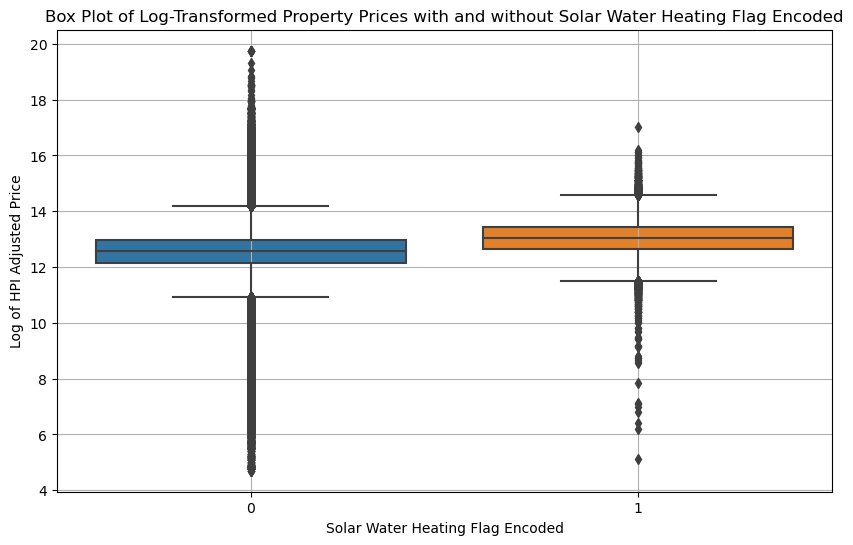

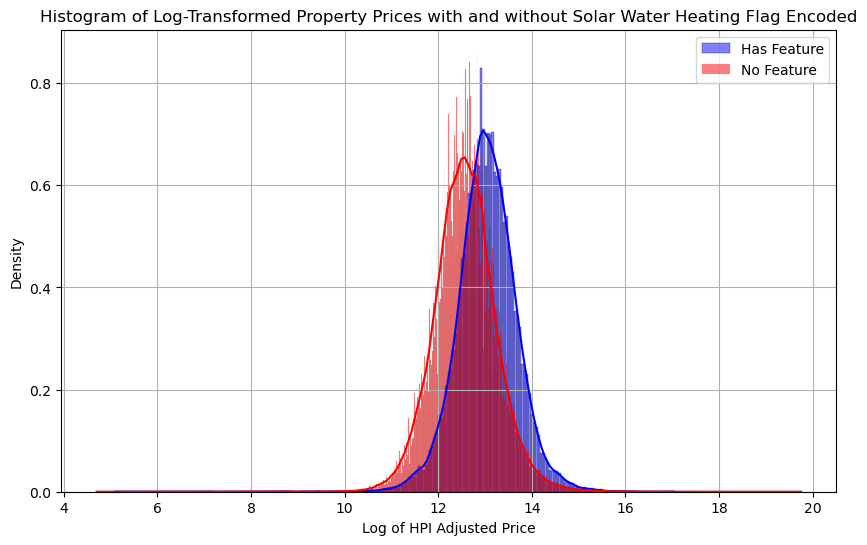

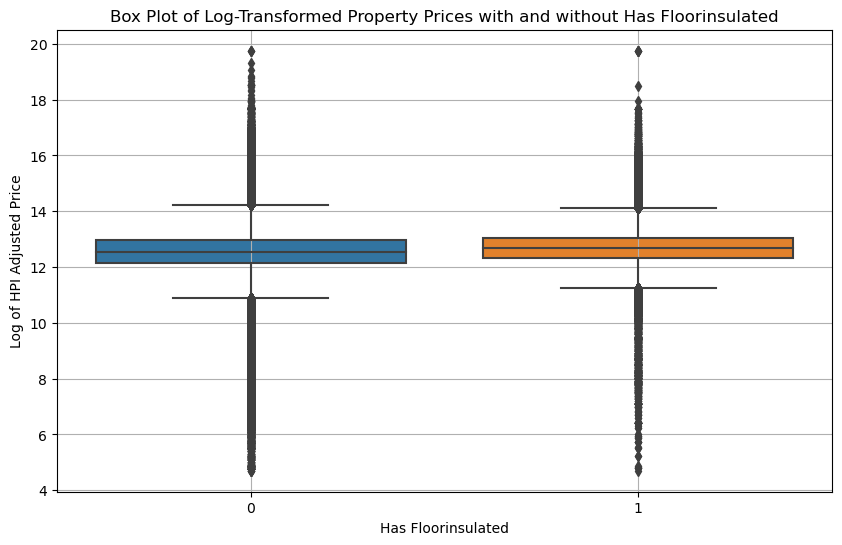

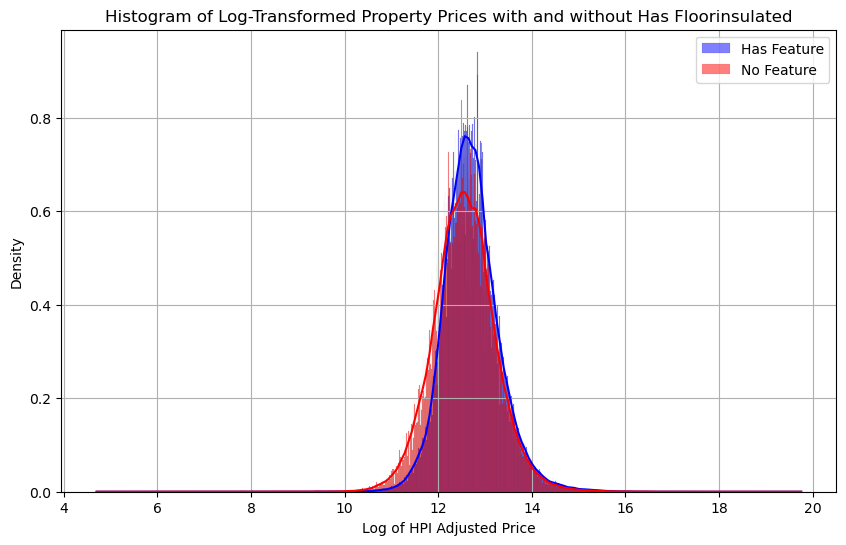

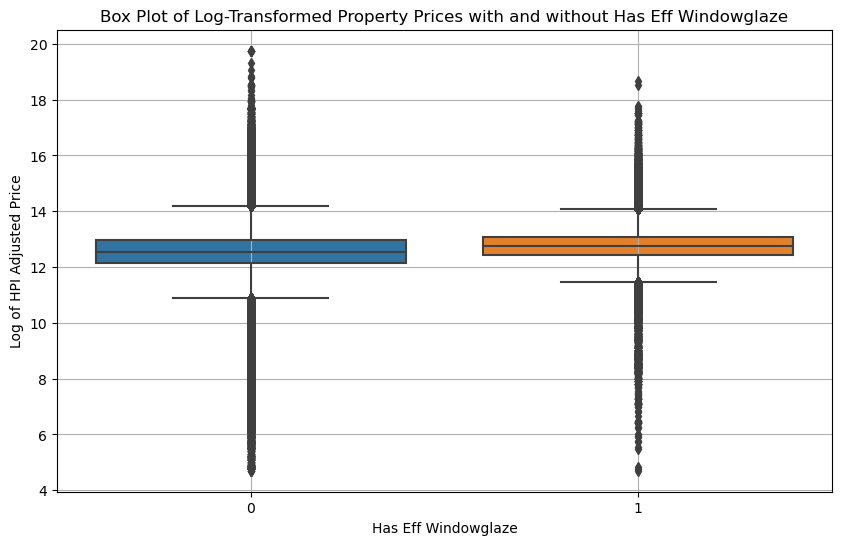

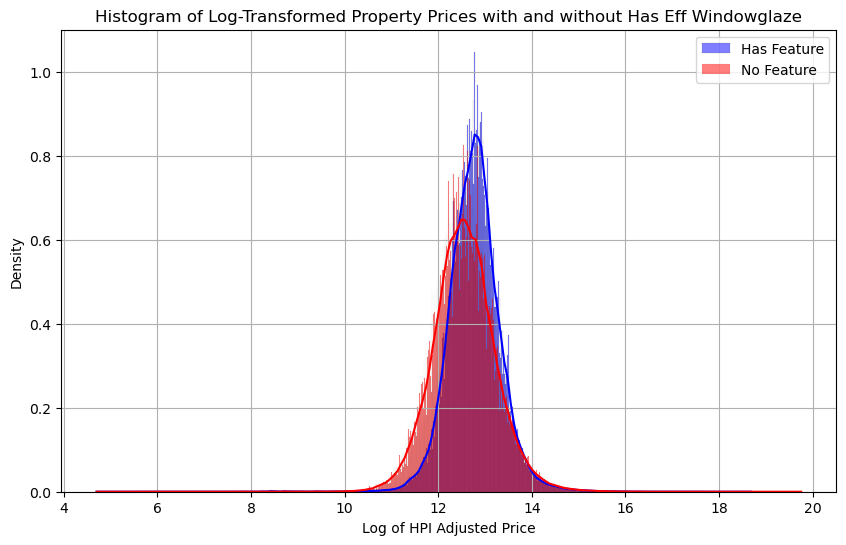

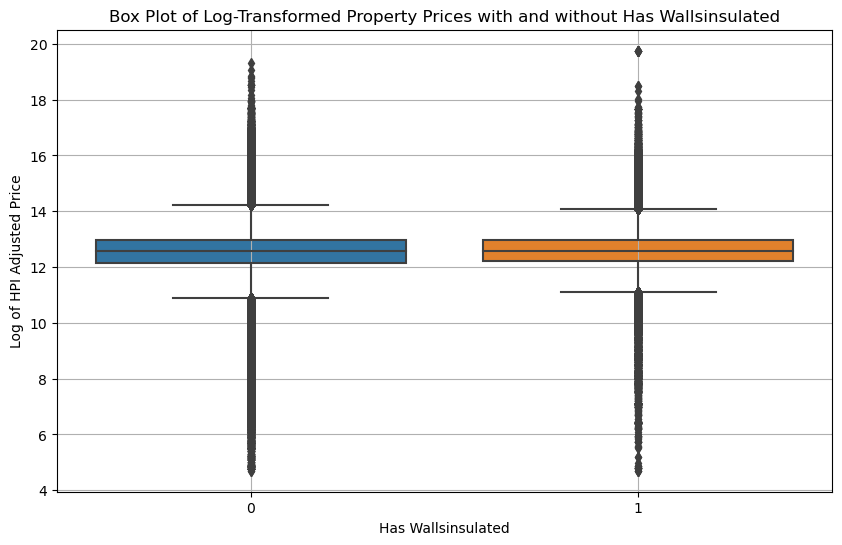

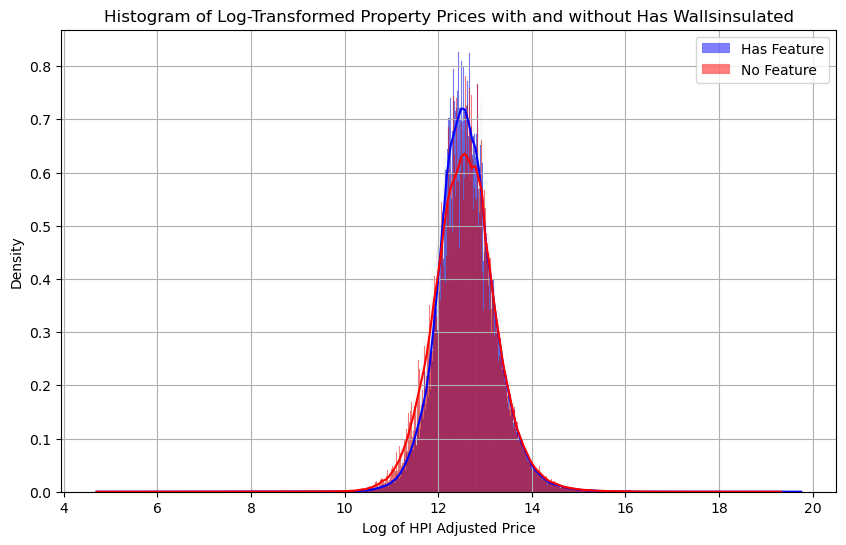

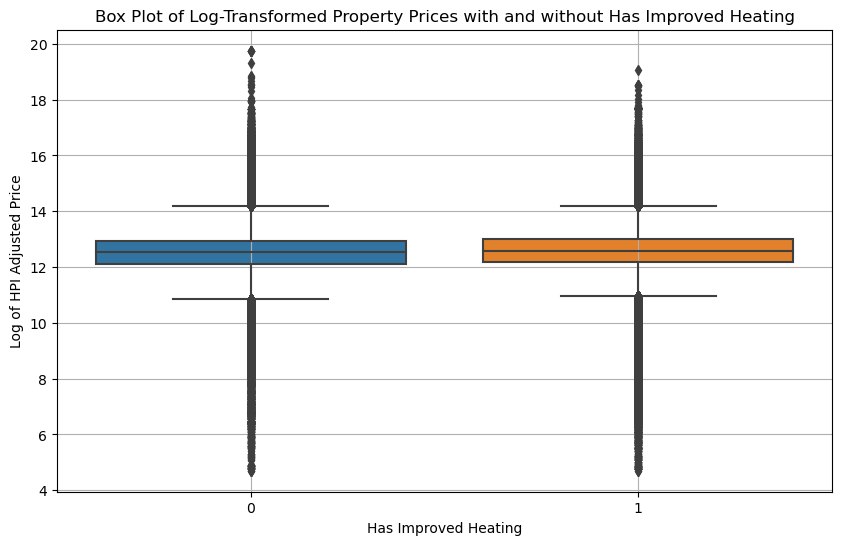

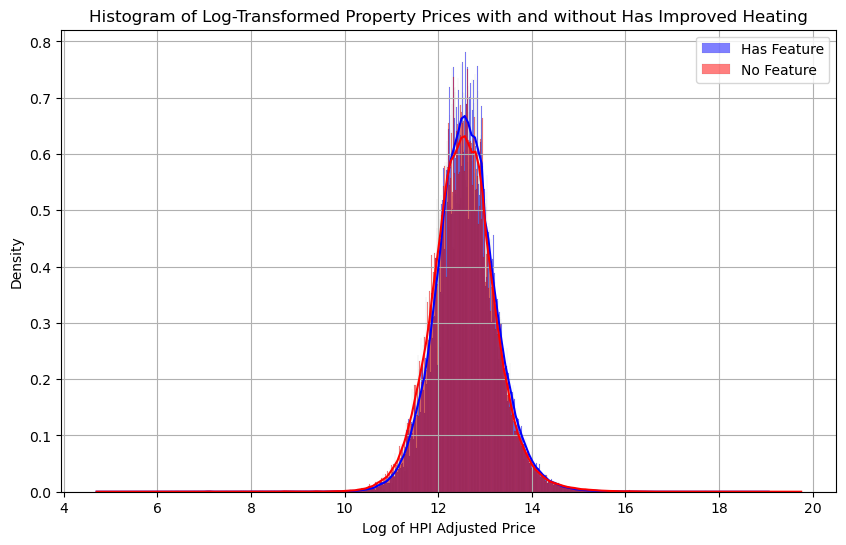

In [35]:
# Apply log transformation to hpi_adjusted_price
pandas_df['log_hpi_adjusted_price'] = np.log1p(pandas_df['hpi_adjusted_price'])  # log1p is used to handle zero values

# Define a list of energy features
retrofit_features = [
    'solar_water_heating_flag_encoded', 'has_floorinsulated', 
    'has_eff_windowglaze', 'has_wallsinsulated', 'has_improved_heating'
]

# Generate box plots and histograms for each energy feature
for feature in retrofit_features:
    # Box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='log_hpi_adjusted_price', data=pandas_df)
    plt.title(f'Box Plot of Log-Transformed Property Prices with and without {feature.replace("_", " ").title()}')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Log of HPI Adjusted Price')
    plt.grid(True)
    plt.show()

    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(pandas_df[pandas_df[feature] == True]['log_hpi_adjusted_price'], color='blue', label='Has Feature', kde=True, stat="density")
    sns.histplot(pandas_df[pandas_df[feature] == False]['log_hpi_adjusted_price'], color='red', label='No Feature', kde=True, stat="density")
    plt.title(f'Histogram of Log-Transformed Property Prices with and without {feature.replace("_", " ").title()}')
    plt.xlabel('Log of HPI Adjusted Price')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()


In [36]:
# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select("wind_turbine_count", "hpi_adjusted_price").toPandas()

# Descriptive statistics for property prices based on different ranges of wind turbine counts
wind_turbine_bins = pd.cut(pandas_df['wind_turbine_count'], bins=[0, 1, 2, 3, 4, 5, 10, 20, np.inf], right=False)
wind_turbine_stats = pandas_df.groupby(wind_turbine_bins)['hpi_adjusted_price'].describe()
print(wind_turbine_stats)


                        count           mean            std       min  \
wind_turbine_count                                                      
[0.0, 1.0)          8257565.0  366475.217161  591050.642882     109.0   
[1.0, 2.0)           596697.0  415479.098759  501404.098253     109.0   
[2.0, 3.0)                7.0  300945.428571  258922.912968  118758.0   
[3.0, 4.0)                5.0  698987.200000  306341.458390  175916.0   
[4.0, 5.0)                2.0  144325.500000   82501.683695   85988.0   
[5.0, 10.0)               1.0  148466.000000            NaN  148466.0   
[10.0, 20.0)              0.0            NaN            NaN       NaN   
[20.0, inf)               0.0            NaN            NaN       NaN   

                          25%       50%        75%          max  
wind_turbine_count                                               
[0.0, 1.0)          187010.00  282413.0  426145.00  379831209.0  
[1.0, 2.0)          249180.00  349379.0  479847.00  146172445.0  
[2.0,

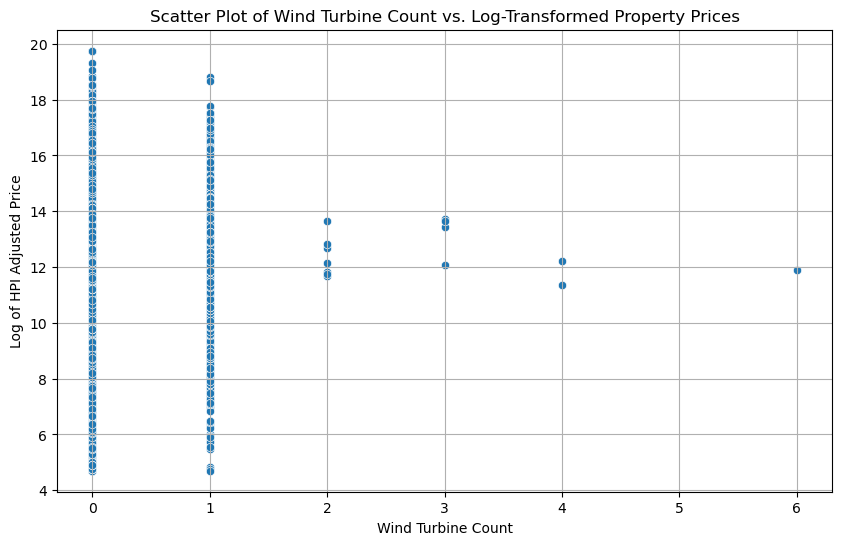

In [37]:
# Apply log transformation to hpi_adjusted_price
pandas_df['log_hpi_adjusted_price'] = np.log1p(pandas_df['hpi_adjusted_price']) 

# Scatter plot of wind turbine count vs. log-transformed property prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_turbine_count', y='log_hpi_adjusted_price', data=pandas_df)
plt.title('Scatter Plot of Wind Turbine Count vs. Log-Transformed Property Prices')
plt.xlabel('Wind Turbine Count')
plt.ylabel('Log of HPI Adjusted Price')
plt.grid(True)
plt.show()



In [38]:
# Compute the Spearman correlation between wind turbine count and log-transformed property prices
spearman_corr = pandas_df[['wind_turbine_count', 'log_hpi_adjusted_price']].corr(method='spearman')
print(f"Spearman correlation between wind turbine count and log-transformed property prices: {spearman_corr.loc['wind_turbine_count', 'log_hpi_adjusted_price']}")


Spearman correlation between wind turbine count and log-transformed property prices: 0.08875806825348022


In [39]:
# Assuming df is your PySpark DataFrame
columns_to_test = [
    'potential_energy_rating', 'current_energy_rating', 'hot_water_energy_eff', 
    'floor_energy_eff', 'windows_energy_eff', 'walls_energy_eff', 
    'roof_energy_eff', 'mainheat_energy_eff', 'mainheatc_energy_eff', 
    'lighting_energy_eff'
]

# Convert relevant columns to Pandas
pandas_df = df_filled.select(columns_to_test + ['hpi_adjusted_price']).toPandas()

def perform_tests(df, target_variable, columns):
    for column in columns:
        unique_values = df[column].dropna().unique()
        
        # Prepare data for ANOVA and Kruskal-Wallis tests
        groups = [df[df[column] == value][target_variable].dropna() for value in unique_values]

        # Perform ANOVA test
        try:
            anova_result = stats.f_oneway(*groups)
            print(f'ANOVA test result for {column}: F={anova_result.statistic}, p-value={anova_result.pvalue}')
        except Exception as e:
            print(f'ANOVA test for {column} failed: {e}')

        # Perform Kruskal-Wallis test
        try:
            kruskal_result = stats.kruskal(*groups)
            print(f'Kruskal-Wallis test result for {column}: H={kruskal_result.statistic}, p-value={kruskal_result.pvalue}')
        except Exception as e:
            print(f'Kruskal-Wallis test for {column} failed: {e}')

# Perform tests
perform_tests(pandas_df, 'hpi_adjusted_price', columns_to_test)

ANOVA test result for potential_energy_rating: F=8878.73673467984, p-value=0.0
Kruskal-Wallis test result for potential_energy_rating: H=136120.35222849768, p-value=0.0
ANOVA test result for current_energy_rating: F=2722.4066628343026, p-value=0.0
Kruskal-Wallis test result for current_energy_rating: H=84538.83306643745, p-value=0.0
ANOVA test result for hot_water_energy_eff: F=1784.372873528351, p-value=0.0
Kruskal-Wallis test result for hot_water_energy_eff: H=74596.62759637783, p-value=0.0
ANOVA test result for floor_energy_eff: F=1051.8160364387215, p-value=0.0
Kruskal-Wallis test result for floor_energy_eff: H=87010.09111717742, p-value=0.0
ANOVA test result for windows_energy_eff: F=22427.70258296653, p-value=0.0
Kruskal-Wallis test result for windows_energy_eff: H=250276.939346528, p-value=0.0
ANOVA test result for walls_energy_eff: F=7733.047870633484, p-value=0.0
Kruskal-Wallis test result for walls_energy_eff: H=106266.19268839248, p-value=0.0
ANOVA test result for roof_energ

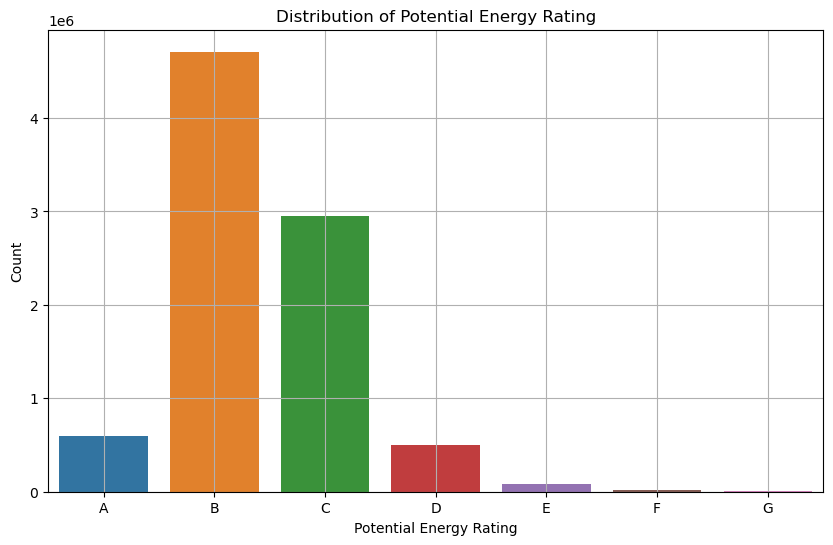

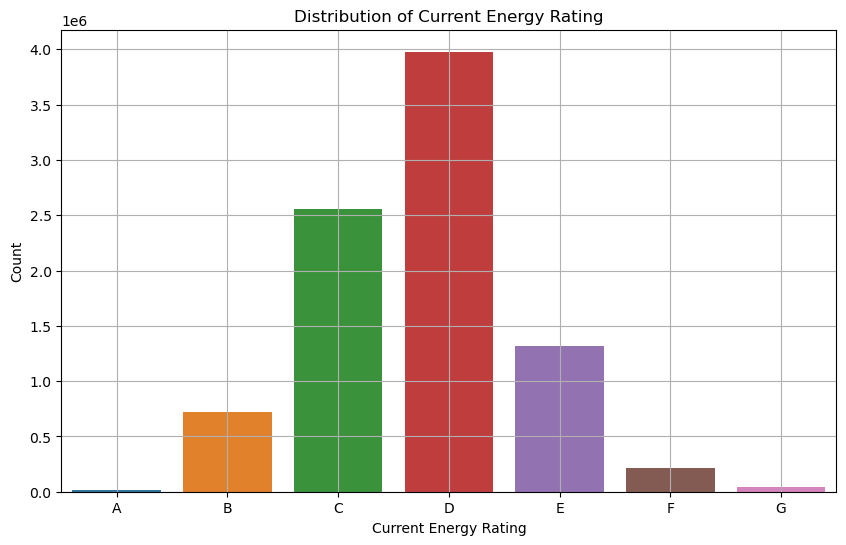

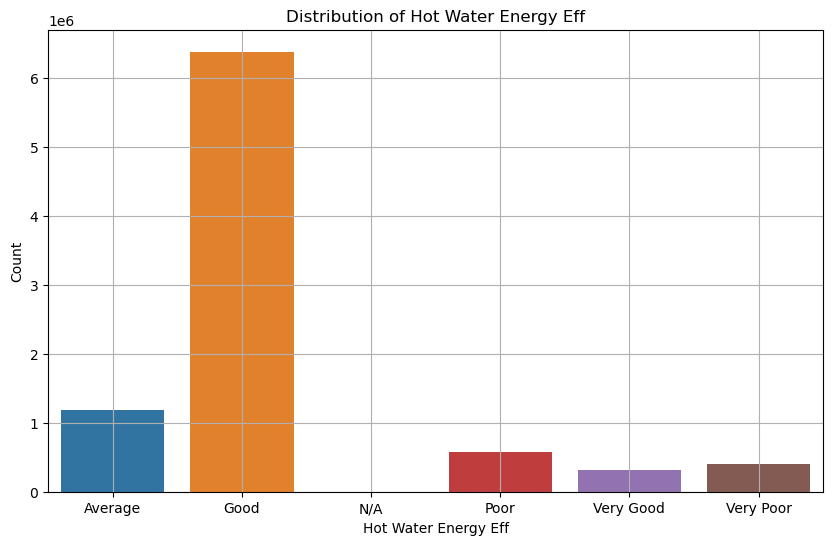

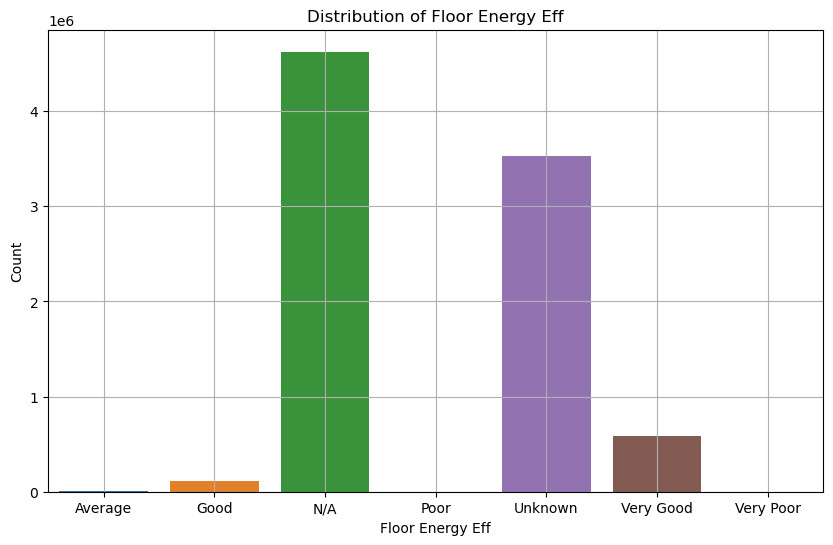

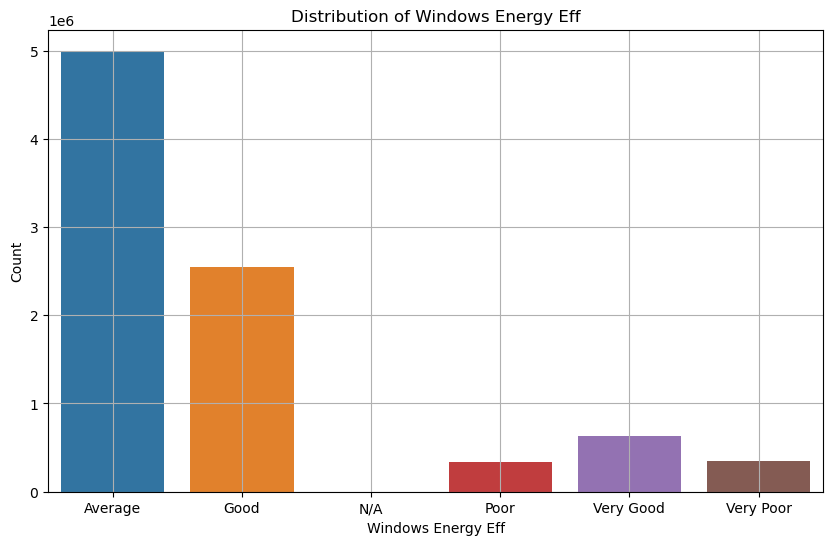

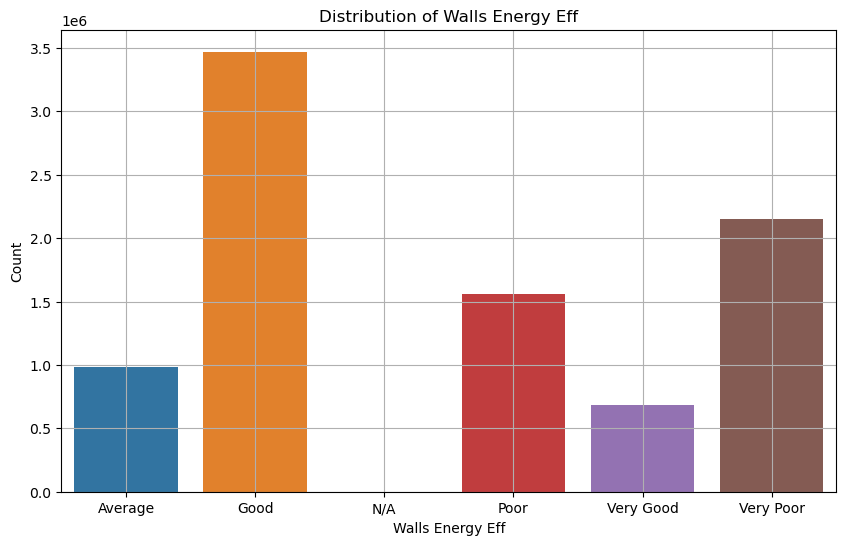

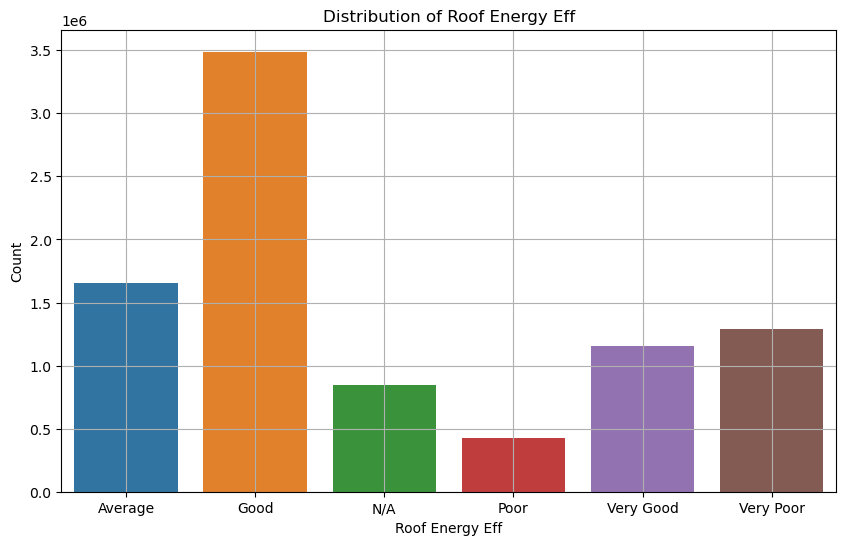

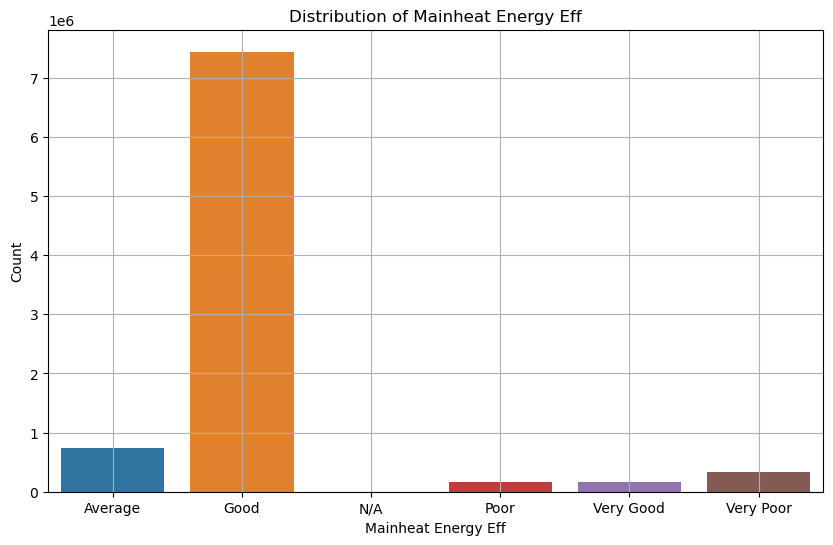

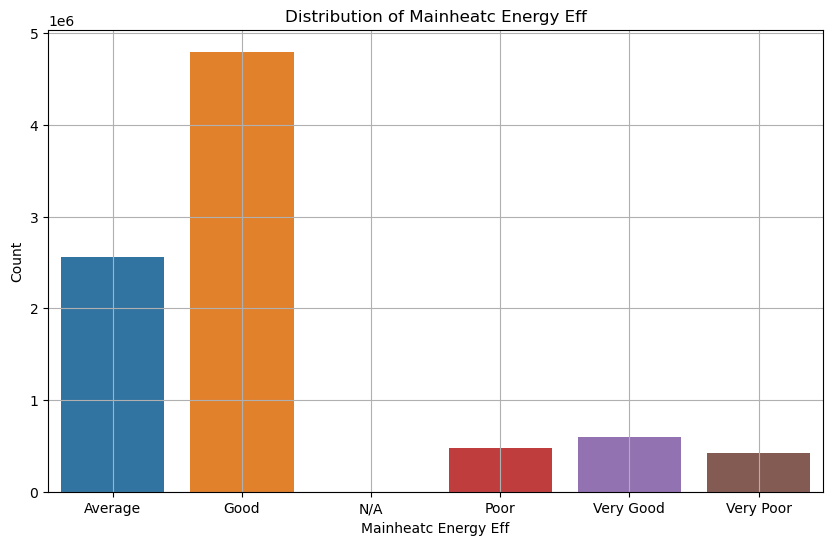

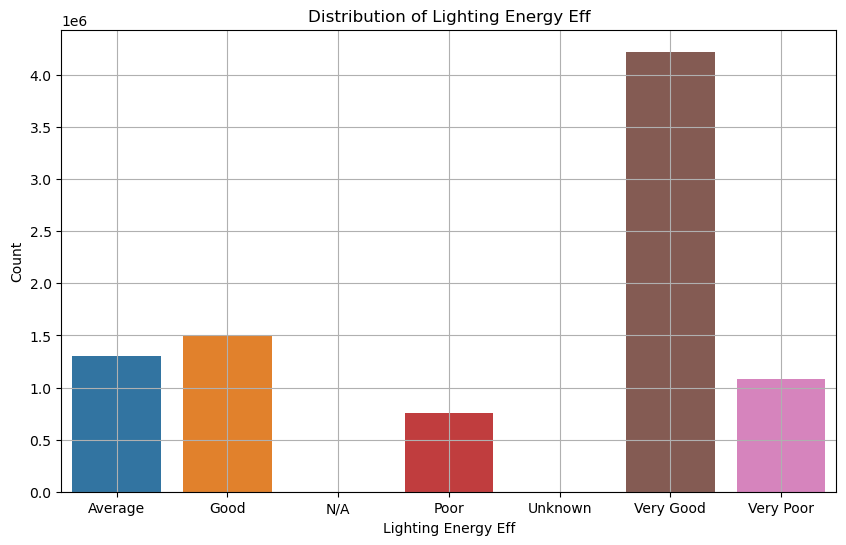

In [40]:
# Define the list of features to plot
features = [
    'potential_energy_rating', 'current_energy_rating', 'hot_water_energy_eff',
    'floor_energy_eff', 'windows_energy_eff', 'walls_energy_eff',
    'roof_energy_eff', 'mainheat_energy_eff', 'mainheatc_energy_eff',
    'lighting_energy_eff'
]

# Convert the Spark DataFrame to a Pandas DataFrame
pandas_df = df_filled.select(features).toPandas()

# Define a function to create count plots
def plot_distribution(df, feature):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, data=df, order=sorted(df[feature].unique()))
    plt.title(f'Distribution of {feature.replace("_", " ").title()}')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

# Create distribution plots for each feature
for feature in features:
    plot_distribution(pandas_df, feature)

#### Retrofit Feature Engineering

Here, we are creating new features from the column 'improvement_id_text' which describes the retrofit improvemnts made to each property.

In [35]:
def contains_solar_water_heating(my_list):
      return 1 if "Solar water heating" in my_list else 0
    
df_filled = df_filled.withColumn("is_solarwaterheating", F.udf(contains_solar_water_heating)(F.col("improvement_id_text")))

# Create a new column where 0 values in `solar_water_heating_flag_encoded` are replaced with 1 if `is_solarwaterheating` is 1
df_filled = df_filled.withColumn("combined_solar_water_heating", F.when(F.col("is_solarwaterheating") == 1, 1).otherwise(F.col("solar_water_heating_flag_encoded")))

# Drop the original columns if not needed
df_filled = df_filled.drop("is_solarwaterheating", "solar_water_heating_flag_encoded")

In [36]:
def contains_floor_insulation(my_list):
    return 1 if any(item in ["Solid floor insulation", "Floor insulation","Suspended floor insulation"] for item in my_list) else 0
    
df_filled = df_filled.withColumn("is_floorins", F.udf(contains_floor_insulation)(F.col("improvement_id_text")))

# Create a new column where 0 values in `has_floorinsulated` are replaced with 1 if `is_floorins` is 1
df_filled = df_filled.withColumn("combined_floor_insulation", F.when(F.col("is_floorins") == 1, 1).otherwise(F.col("has_floorinsulated")))

# Drop the original columns if not needed
df_filled = df_filled.drop("is_floorins", "has_floorinsulated")

In [37]:
def contains_walls_insulation(my_list):
    return 1 if any(item in ["50 mm internal or external wall insulation", "Cavity wall insulation"] for item in my_list) else 0
    
df_filled = df_filled.withColumn("is_wallsins", F.udf(contains_walls_insulation)(F.col("improvement_id_text")))

# Create a new column where 0 values in `has_wallsinsulated` are replaced with 1 if `is_wallsins` is 1
df_filled = df_filled.withColumn("combined_walls_insulation", F.when(F.col("is_wallsins") == 1, 1).otherwise(F.col("has_wallsinsulated")))

# Drop the original columns if not needed
df_filled = df_filled.drop("is_wallsins", "has_wallsinsulated")

In [38]:
# Function to check if "Solar photovoltaic panels, 2.5 kWp" is in the list
def contains_solar_panel(my_list):
      return 1 if "Solar photovoltaic panels, 2.5 kWp" in my_list else 0

# Apply the function to the "improvement_id_text" column to create a new column "is_solar_panel"
df_filled = df_filled.withColumn("is_solar_panel", F.udf(contains_solar_panel)(F.col("improvement_id_text")).cast("integer"))


#### Dropping all  columns not needed for modelling

In [39]:
dccolumns_to_drop = [ 'property_type', 'build_form', 
                     'local_authority', 'constituency','county', 'transaction_type', 'energy_tariff',
                     'mains_gas_flag', 'flat_top_storey', 'main_heating_controls', 'glazed_type', 'glazed_area',
                     'hotwater_description', 'hot_water_env_eff', 'floor_description',
                      'floor_env_eff', 'windows_description', 'windows_env_eff', 'walls_description',  'walls_env_eff', 
                     'secondheat_description', 'roof_description',  'roof_env_eff', 
                     'mainheat_description',  'mainheat_env_eff', 'mainheatcont_description',
                      'mainheatc_env_eff', 'lighting_description', 'current_energy_rating', 'potential_energy_rating',
                     'lighting_env_eff', 'main_fuel', 'solar_water_heating_flag', 'mechanical_ventilation', 
                     'local_authority_label', 'constituency_label', 'construction_age_band', 'tenure',
                     'improvement_id', 'improvement_item_id', 'improvement_id_text', 'min_indicative_cost',
                     'max_indicative_cost', 'lsoa11cd', 'price_paid_property_type', 'buildinguse', 'connectivity',
                     'constructionmaterial', 'lsoa11nm','potential_energy_rating', 'current_energy_rating', 'hot_water_energy_eff', 
                    'floor_energy_eff', 'windows_energy_eff', 'walls_energy_eff',
                     'roof_energy_eff', 'mainheat_energy_eff', 'mainheatc_energy_eff', 'lighting_energy_eff'
]
df_filled = df_filled.drop(*dccolumns_to_drop)


### Dealing with Temporal variables

#### Feature Engineering of additional temporal features

In [40]:
# Add a temporary ID column to each DataFrame to distinguish rows after the union
df = df.withColumn("temp_id", monotonically_increasing_id())
hdf = hdf.withColumn("temp_id", monotonically_increasing_id())

# Perform the union (vertical join)
df_combined = df.unionByName(hdf)

# Drop the temporary ID column
df_combined = df_combined.drop("temp_id")

# Drop duplicates based on all columns
df_combined = df_combined.dropDuplicates()



In [41]:
# Extract year from the 'date_of_transfer' column
df_combined = df_combined.withColumn('year', year(col('date_of_transfer')))

# Get the CPI for the base year (e.g., 2024)
base_year_hpi = hpi_df.filter(col('year') == 2024).select('average_hpi').first()[0]

# Join property data with CPI data on 'sale_year'
df_combined = df_combined.join(hpi_df, on='year', how='left')

# Adjust the prices by multiplying with the inflation factor
df_combined = df_combined.withColumn('hpi_adjusted_price',  round((col('price') / col("average_hpi"))* base_year_hpi).cast('int'))



In [42]:
# Aggregate statistics on the full dataset (with multiple sales per property)
historical_agg = df_combined.groupBy("uprn").agg(
    # Count the number of sales
    count("*").alias("num_sales"),

    # Price volatility (standard deviation)
    stddev("price").alias("price_volatility"),

    # Minimum and maximum sale dates (for calculating time range)
    min("date_of_transfer").alias("earliest_sale_date"),
    max("date_of_transfer").alias("latest_sale_date")
)

# Calculate additional time-based features
historical_agg = historical_agg.withColumn(
    # Total time range of sales (in days)
    "sale_date_range", datediff(col("latest_sale_date"), col("earliest_sale_date"))
)

# Calculate years since last sale
historical_agg = historical_agg.withColumn(
    "years_since_last_sale", round(datediff(current_date(), col("latest_sale_date")) / 365.25)
)


# Join the aggregated features back to the deduplicated dataset
df_joined = df_filled.join(historical_agg, on="uprn", how="left")




In [43]:
df_joined = df_joined.fillna(0, subset=["price_volatility"])

In [50]:
df_joined.limit(5).toPandas()

uprn  current_energy_efficiency inspection_date lodgement_date  \
0   10000035241                       56.0      2017-10-05     2017-10-05   
1   10000861921                       75.0      2013-06-06     2013-06-06   
2  100010156079                       72.0      2023-09-26     2023-09-27   
3  100010742509                       69.0      2022-09-27     2022-09-28   
4  100010894246                       55.0      2015-01-30     2015-01-30   

   environment_impact_current  environment_impact_potential  \
0                        51.0                          75.0   
1                        78.0                          97.0   
2                        71.0                          87.0   
3                        64.0                          80.0   
4                        49.0                          76.0   

   energy_consumption_current  co2_emissions_current  \
0                       224.0                    4.8   
1                       147.0                    1.5   
2                       202.0                    2.5   
3                       216.0                    3.9   
4                       351.0                    4.6   

   co2_emiss_curr_per_floor_area  co2_emissions_potential  \
0                           55.0                      2.2   
1                           28.0                      0.1   
2                           36.0                      1.1   
3                           38.0                      2.1   
4                           62.0                      2.2   

   lighting_cost_current  lighting_cost_potential  heating_cost_current  \
0                   93.0                     64.0                 550.0   
1                   49.0                     35.0                 271.0   
2                  114.0                    114.0                1010.0   
3                   85.0                     85.0                 655.0   
4                   93.0                     49.0                 846.0   

   heating_cost_potential  hot_water_cost_current  hot_water_cost_potential  \
0                   422.0                   159.0                      76.0   
1                   255.0                    89.0                      51.0   
2                   845.0                   216.0                     142.0   
3                   527.0                    98.0                      71.0   
4                   608.0                   103.0                      70.0   

   total_floor_area  multi_glaze_proportion  extension_count  \
0              87.0                   100.0              1.0   
1              54.0                   100.0              0.0   
2              70.0                   100.0              0.0   
3             103.0                   100.0              1.0   
4              75.0                   100.0              1.0   

   number_habitable_rooms  number_heated_rooms  low_energy_lighting  \
0                     4.0                  4.0                 54.0   
1                     4.0                  4.0                 62.0   
2                     5.0                  5.0                100.0   
3                     5.0                  5.0                100.0   
4                     4.0                  4.0                  8.0   

   number_open_fireplaces  wind_turbine_count  photo_supply  \
0                     0.0                 0.0           1.0   
1                     0.0                 0.0           0.0   
2                     0.0                 0.0           0.0   
3                     0.0                 0.0           0.0   
4                     0.0                 0.0           1.0   

   lodgement_datetime  fixed_lighting_outlets_count  min_cost  mid_cost  \
0 2017-10-05 19:28:06                          13.0   14945.0   18712.5   
1 2013-06-06 20:26:26                          16.0   11230.0   14865.0   
2 2023-09-27 11:09:12                           9.0   11600.0   14725.0   
3 2022-09-28 09:49:33                          1

#### EDA of Temporal variables

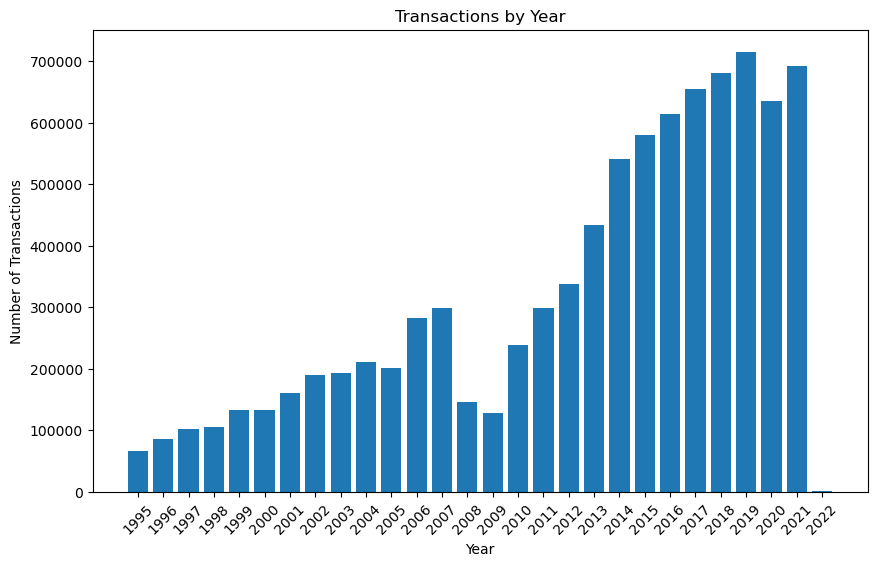

In [51]:
# Extract Year from `date_of_transfer`
transactions_by_year = df_joined.withColumn('year', year('date_of_transfer'))

# Aggregate by Year and Count Transactions
transactions_by_year_agg = transactions_by_year.groupBy('year').agg(count('*').alias('num_transactions'))

# Convert to Pandas for Plotting
transactions_pandas = transactions_by_year_agg.orderBy('year').toPandas()

# Plotting (Bar Chart)
plt.figure(figsize=(10, 6))
plt.bar(transactions_pandas['year'], transactions_pandas['num_transactions'])
plt.xlabel('Year')
plt.ylabel('Number of Transactions')
plt.title('Transactions by Year')
plt.xticks(transactions_pandas['year'], rotation=45)
plt.show()


In [52]:
# Aggregate the number of sales by region (using lat and lon)
sales_agg = df_joined.groupBy("lat", "lon").agg(
    psum("num_sales").alias("total_sales")
)

# Collect the aggregated data to find the regions with most and least sales
sales_agg_pd = sales_agg.toPandas()

# Find the region with the most sales
max_sales_region = sales_agg_pd.loc[sales_agg_pd["total_sales"].idxmax()]

# Find the region with the least sales
min_sales_region = sales_agg_pd.loc[sales_agg_pd["total_sales"].idxmin()]

print(f"Region with most sales: {max_sales_region}")
print(f"Region with least sales: {min_sales_region}")


Region with most sales: lat             51.515751
lon             -0.164975
total_sales    671.000000
Name: 3938705, dtype: float64
Region with least sales: lat            54.938599
lon            -1.545839
total_sales     1.000000
Name: 4, dtype: float64


In [53]:
# Create a map centered around the average location
map_center = [sales_agg_pd["lat"].mean(), sales_agg_pd["lon"].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Add a marker for the region with the most sales
folium.Marker(
    location=[max_sales_region["lat"], max_sales_region["lon"]],
    popup=f"Most Sales: {max_sales_region['total_sales']}",
    icon=folium.Icon(color="green")
).add_to(m)

# Add a marker for the region with the least sales
folium.Marker(
    location=[min_sales_region["lat"], min_sales_region["lon"]],
    popup=f"Least Sales: {min_sales_region['total_sales']}",
    icon=folium.Icon(color="red")
).add_to(m)

# Display the map
m


In [54]:
# Aggregate the number of properties by region (using lat and lon)
properties_agg = df_joined.groupBy("lat", "lon").agg(
    countDistinct("uprn").alias("total_properties")
)

# Collect the aggregated data to find the regions with most and least properties
properties_agg_pd = properties_agg.toPandas()

# Find the region with the most properties
max_properties_region = properties_agg_pd.loc[properties_agg_pd["total_properties"].idxmax()]

# Find the region with the least properties
min_properties_region = properties_agg_pd.loc[properties_agg_pd["total_properties"].idxmin()]

print(f"Region with most properties: {max_properties_region}")
print(f"Region with least properties: {min_properties_region}")


Region with most properties: lat                  52.477489
lon                  -1.902227
total_properties    408.000000
Name: 2995599, dtype: float64
Region with least properties: lat                 51.893444
lon                 -0.370025
total_properties     1.000000
Name: 0, dtype: float64


In [55]:
# Create a map centered around the average location
map_center = [properties_agg_pd["lat"].mean(), properties_agg_pd["lon"].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Add a marker for the region with the most properties
folium.Marker(
    location=[max_properties_region["lat"], max_properties_region["lon"]],
    popup=f"Most Properties: {max_properties_region['total_properties']}",
    icon=folium.Icon(color="green")
).add_to(m)

# Add a marker for the region with the least properties
folium.Marker(
    location=[min_properties_region["lat"], min_properties_region["lon"]],
    popup=f"Least Properties: {min_properties_region['total_properties']}",
    icon=folium.Icon(color="red")
).add_to(m)

# Display the map
m


#### Dropping the unnecessary columns for modelling

In [44]:
ddcolumns_to_drop = ["date_of_transfer","inspection_date","lodgement_date","lodgement_datetime"]
df_joined = df_joined.drop(*ddcolumns_to_drop)

fcolumns_to_drop = ["earliest_sale_date","latest_sale_date","year","average_hpi","price"]
df_joined = df_joined.drop(*fcolumns_to_drop)

# Data Transformation and Splitting

In [45]:
# Identify the target variable
target_column = "hpi_adjusted_price"

# Log Transformation of the target variable
df_joined = df_joined.withColumn("log_price", log(col(target_column)))

# Define the features columns, excluding the target, log_price, and uprn
features_columns = [col for col in df_joined.columns if col not in [target_column, "uprn", "log_price"]]

# Assemble features into a feature vector (excluding uprn and log_price)
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Define the pipeline
pipeline = Pipeline(stages=[assembler, scaler])

# Fit and transform the data
model = pipeline.fit(df_joined)
df_transformed = model.transform(df_joined)

# Select the necessary columns including uprn, scaled_features, and log_price
df_final = df_transformed.select("uprn", "scaled_features", "log_price")

# Show the transformed dataframe
df_final.limit(5).toPandas()


uprn                                    scaled_features  log_price
0  100000000052  [5.192356323376432, 4.272221858161597, 8.59489...  11.796765
1  100000000406  [5.192356323376432, 4.913055136885837, 7.55595...  13.240690
2  100000000625  [5.439611386394358, 4.5570366487057035, 7.5559...  12.391751
3  100000000693  [5.686866449412283, 4.62824034634173, 7.555954...  12.299253
4  100000000713  [4.9451012603585065, 3.7737959747094107, 7.461...  12.069244

In [45]:
#dataset for merging with the final full predictions for uprn 
dd = df_final.select("uprn","log_price").toPandas()
dd.to_csv("merge.csv",index = False)

In [46]:
# Split the data into training, validation, and test sets
train_data, val_data, test_data = df_final.randomSplit([0.7, 0.15, 0.15], seed=42)

# Show the number of rows in each set
print(f"Training Data Count: {train_data.count()}")
print(f"Validation Data Count: {val_data.count()}")
print(f"Test Data Count: {test_data.count()}")

Training Data Count: 6197066


Validation Data Count: 1326535


Test Data Count: 1330676


# Model Training

Training the data on all 4 models

In [46]:
# Dictionary containing regression models
models = {
    'LinearRegression': LinearRegression(featuresCol="scaled_features", labelCol="log_price"),
    'RandomForestRegressor': RandomForestRegressor(featuresCol="scaled_features", labelCol="log_price",
                                                   featureSubsetStrategy='sqrt', seed =42),
    'GBTRegressor': GBTRegressor(featuresCol="scaled_features", labelCol="log_price",seed =42),
    'DecisiontreeRegressor': DecisionTreeRegressor(featuresCol="scaled_features", labelCol="log_price", seed =42)
    
    
}    

# Dictionary containing hyperparameter grids for each model
params = {
    'LinearRegression': ParamGridBuilder() \
        .addGrid(models['LinearRegression'].regParam, [0.01, 0.1]) \
        .addGrid(models['LinearRegression'].elasticNetParam, [0.0, 0.5]) \
        .build(),
    'RandomForestRegressor': ParamGridBuilder() \
        .addGrid(models['RandomForestRegressor'].numTrees, [10, 20]) \
        .addGrid(models['RandomForestRegressor'].maxDepth, [15, 10]) \
        .build(),
    'GBTRegressor': ParamGridBuilder() \
        .addGrid(models['GBTRegressor'].maxDepth, [5,10]) \
        .addGrid(models['GBTRegressor'].stepSize, [0.1,0.3]) \
        .build(),
    'DecisiontreeRegressor': ParamGridBuilder() \
        .addGrid(models['DecisiontreeRegressor'].maxDepth, [10, 15]) \
        .addGrid(models['DecisiontreeRegressor'].minInstancesPerNode, [2, 4, 6]) \
        .build()

    
}

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")


#### Linear Regression

In [47]:
# Define the Linear Regression model
linear_regressor = models['LinearRegression']

# Define the hyperparameter grid for Linear Regression
param_grid_lr = params['LinearRegression']

# Define the CrossValidator
crossval_lr = CrossValidator(estimator=linear_regressor,
                          estimatorParamMaps=param_grid_lr,
                          evaluator=evaluator,
                          numFolds=5)  # 5-fold cross-validation

# Fit the CrossValidator on the training data
cv_model_lr = crossval_lr.fit(train_data)

# Get the best model
best_model_lr = cv_model_lr.bestModel

# Make predictions on the validation data
val_predictions_lr = best_model_lr.transform(val_data)

# Evaluate the predictions
rmse_lr = evaluator.evaluate(val_predictions_lr, {evaluator.metricName: "rmse"})
mae_lr = evaluator.evaluate(val_predictions_lr, {evaluator.metricName: "mae"})
r2_lr = evaluator.evaluate(val_predictions_lr, {evaluator.metricName: "r2"})

# Print the evaluation metrics
print(f"Root Mean Squared Error (RMSE) on validation data: {rmse_lr}")
print(f"Mean Absolute Error (MAE) on validation data: {mae_lr}")
print(f"R-squared (R2) on validation data: {r2_lr}")

# Print the best parameters
print("Best parameters for Linear Regression model:")
for param, value in best_model_lr.extractParamMap().items():
    print(f"{param.name}: {value}")


Root Mean Squared Error (RMSE) on validation data: 0.34575602293371405
Mean Absolute Error (MAE) on validation data: 0.23296317515439607
R-squared (R2) on validation data: 0.736043536000778
Best parameters for Linear Regression model:
aggregationDepth: 2
elasticNetParam: 0.0
epsilon: 1.35
featuresCol: scaled_features
fitIntercept: True
labelCol: log_price
loss: squaredError
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
regParam: 0.01
solver: auto
standardization: True
tol: 1e-06


Residual Analysis

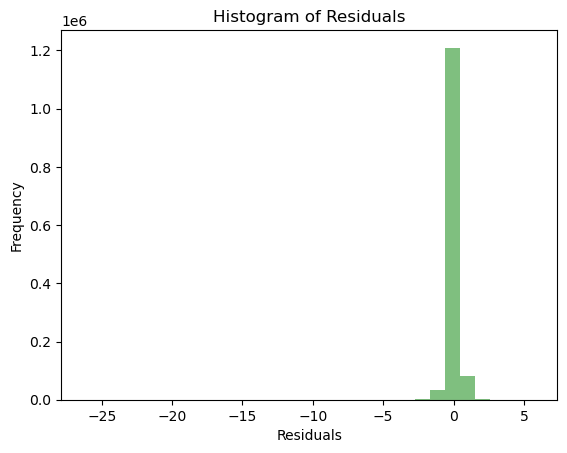

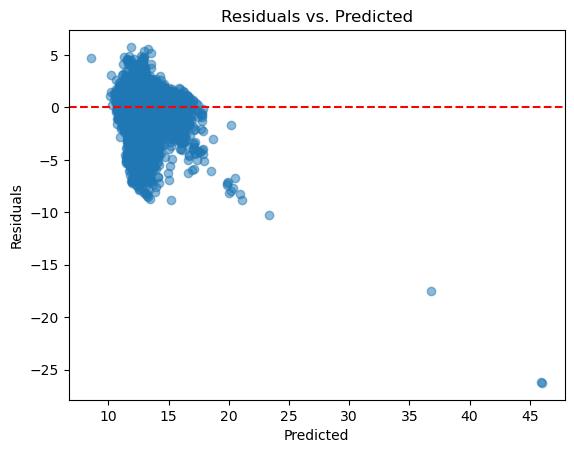

In [49]:
# Add a column for residuals to the DataFrame
residuals = val_predictions_lr.withColumn("residuals", col("log_price") - col("prediction"))

residuals_pd = residuals.select("residuals","prediction").toPandas()


# Plotting histogram of residuals
plt.hist(residuals_pd['residuals'], bins=30, alpha=0.5, color='g')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of predicted vs residuals
plt.scatter(residuals_pd['prediction'], residuals_pd['residuals'], alpha=0.5)
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()



Feature Importance

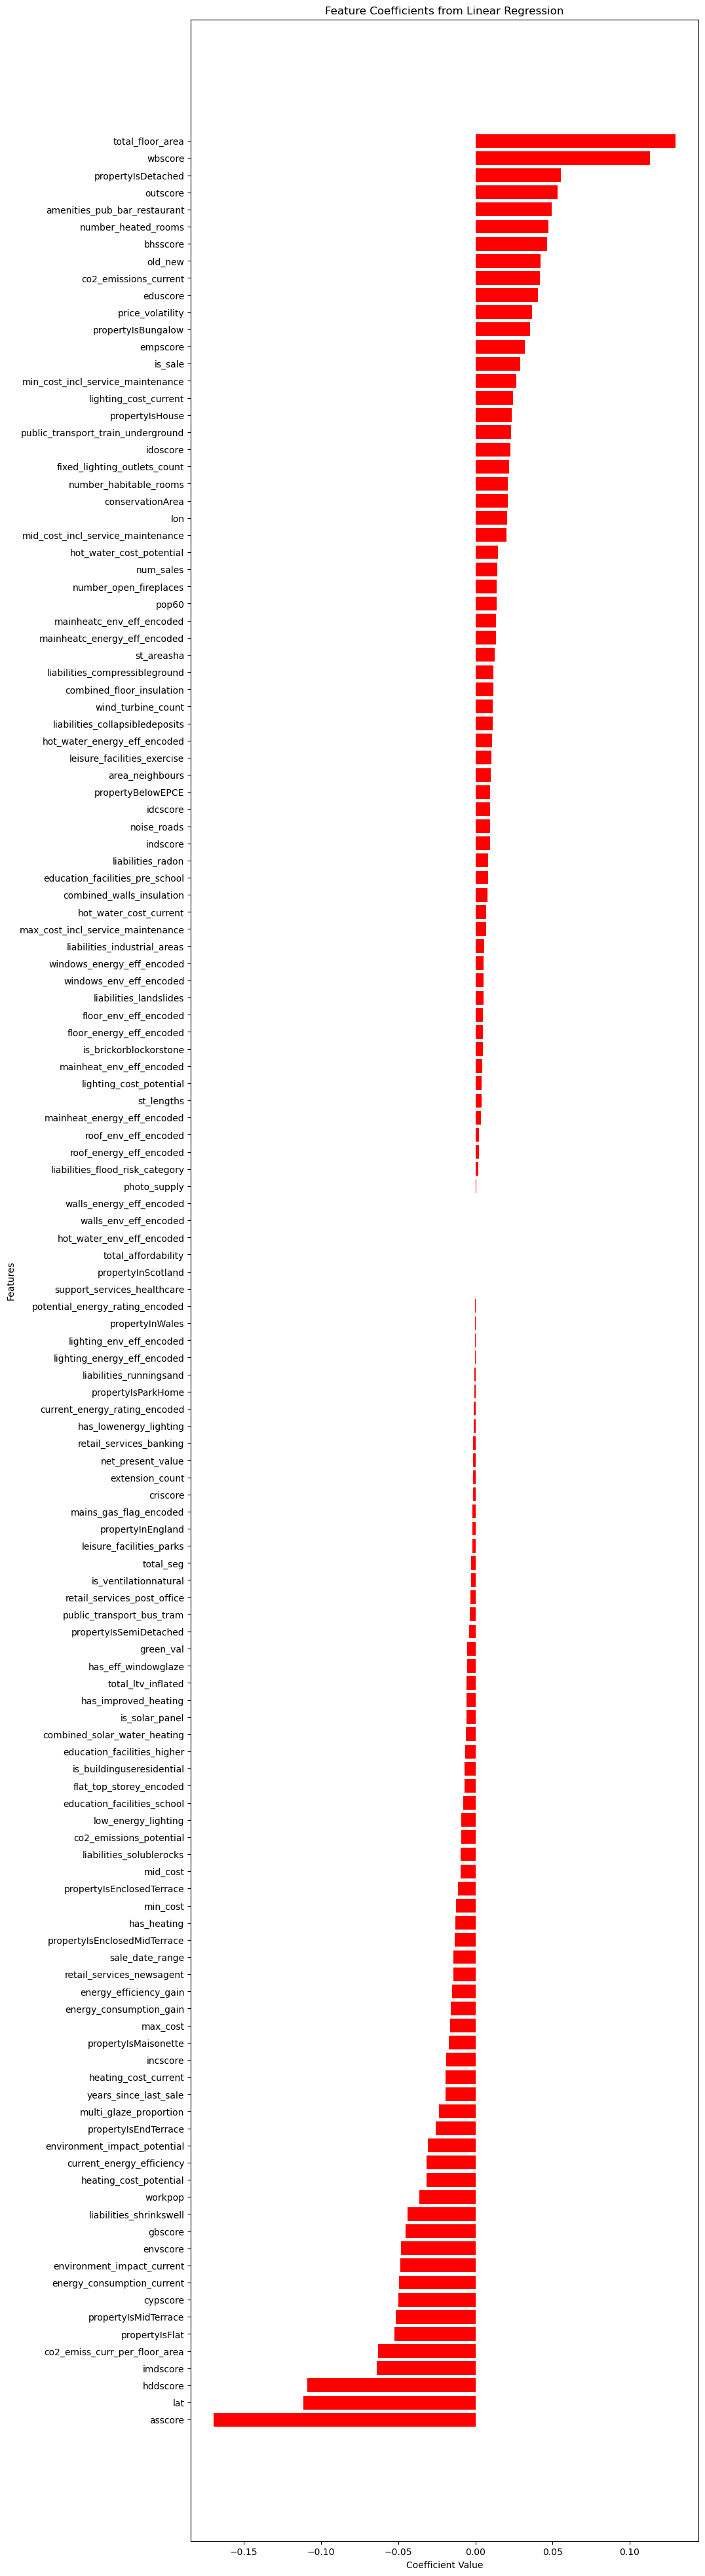

In [50]:
# Assuming best_model_lr is a LinearRegressionModel
coefficients = best_model_lr.coefficients
features = assembler.getInputCols()

# Creating a DataFrame with feature names and their coefficients
coef_df = pd.DataFrame(list(zip(features, coefficients)), columns=["Feature", "Coefficient"])
coef_df.sort_values(by="Coefficient", ascending=False, inplace=True)


plt.figure(figsize=(10, 50))  # Set the figure size
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='red')  # Create horizontal bar chart
plt.xlabel('Coefficient Value')  # Label on x-axis
plt.ylabel('Features')  # Label on y-axis
plt.title('Feature Coefficients from Linear Regression')  # Title of the plot
plt.gca().invert_yaxis()  # Invert y axis so that the largest bar is on top
plt.show()  # Display the plot


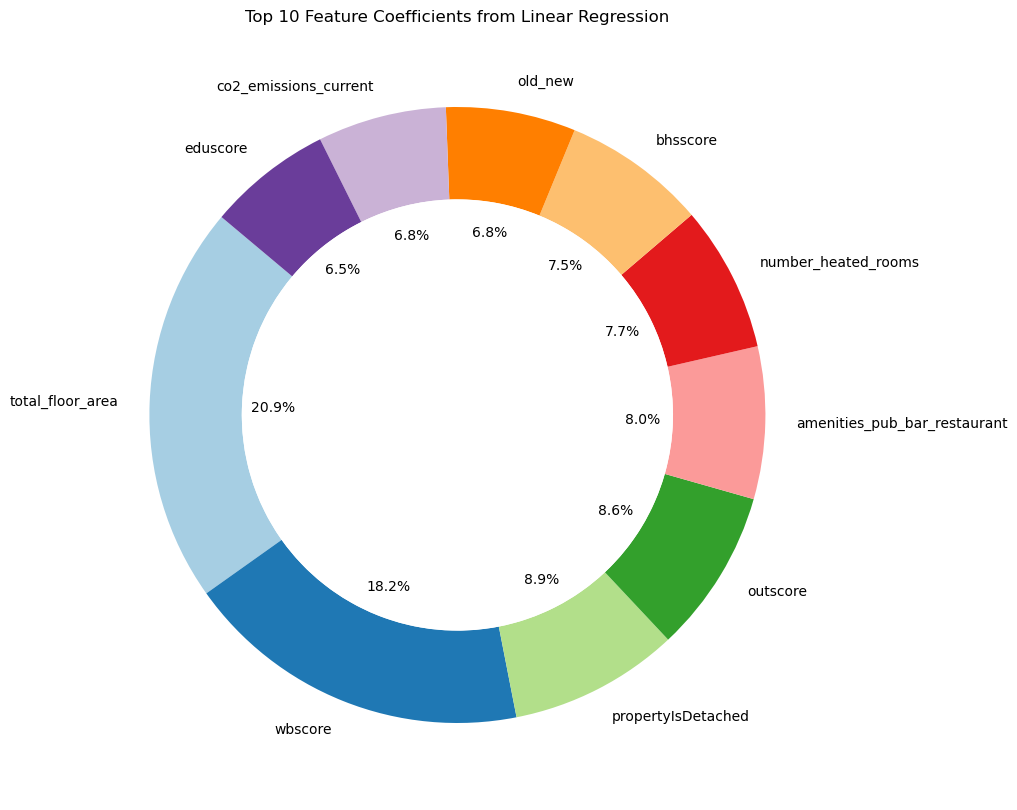

In [51]:
coefficients = best_model_lr.coefficients
features = assembler.getInputCols()

# Creating a DataFrame with feature names and their coefficients
coef_df = pd.DataFrame(list(zip(features, coefficients)), columns=["Feature", "Coefficient"])
coef_df.sort_values(by="Coefficient", ascending=False, inplace=True)

# Select the top 10 features
top_10_features = coef_df.head(10)

# Plotting a pie chart for the top 10 features
plt.figure(figsize=(10, 10))  # Set the figure size
plt.pie(top_10_features['Coefficient'], labels=top_10_features['Feature'], autopct='%1.1f%%',
        startangle=140, colors=plt.cm.Paired.colors, wedgeprops=dict(width=0.3))  # Draw pie chart with ring

# Equal aspect ratio ensures that the pie is drawn as a circle.
plt.gca().set_aspect('equal')

# Draw a circle in the center to create a ring
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.title('Top 10 Feature Coefficients from Linear Regression')  # Title of the plot
plt.show()  # Display the plot


In [54]:
# Convert log values back to the original range
val_predictions_lr = val_predictions_lr.withColumn("hpi_adjusted_price", exp(col("log_price")))
val_predictions_lr = val_predictions_lr.withColumn("predicted_price", round(exp(col("prediction"))).cast('int'))

predicted_df = val_predictions_lr.select("hpi_adjusted_price", "predicted_price").limit(10).toPandas()
print(predicted_df)

   hpi_adjusted_price  predicted_price
0            289888.0           192588
1            128976.0            96732
2            667893.0           611555
3           1759885.0          1693709
4           1208648.0           519316
5             70538.0           111636
6            283855.0           202902
7            109399.0           172040
8           1053081.0          1036971
9            467525.0           466072


#### Decision Tree

In [47]:
# Define the DecisiontreeRegressor model
decision_tree_regressor = models['DecisiontreeRegressor']

# Define the hyperparameter grid for decisiontreeRegressor
param_grid_dt = params['DecisiontreeRegressor']

# Define the CrossValidator for Decision Tree Regressor
crossval_dt = CrossValidator(estimator=decision_tree_regressor,
                             estimatorParamMaps=param_grid_dt,
                             evaluator=evaluator,
                             numFolds=5)  # 5-fold cross-validation

# Fit the CrossValidator on the training data
cv_model_dt = crossval_dt.fit(train_data)

# Get the best model
best_model_dt = cv_model_dt.bestModel

# Make predictions on the validation data
val_predictions_dt = best_model_dt.transform(val_data)

# Evaluate the predictions
rmse_dt = evaluator.evaluate(val_predictions_dt, {evaluator.metricName: "rmse"})
mae_dt = evaluator.evaluate(val_predictions_dt, {evaluator.metricName: "mae"})
r2_dt = evaluator.evaluate(val_predictions_dt, {evaluator.metricName: "r2"})

# Print the evaluation metrics
print(f"Root Mean Squared Error (RMSE) on validation data: {rmse_dt}")
print(f"Mean Absolute Error (MAE) on validation data: {mae_dt}")
print(f"R-squared (R2) on validation data: {r2_dt}")

# Print the best parameters
print("Best parameters for Decision Tree Regressor model:")
for param, value in best_model_dt.extractParamMap().items():
    if hasattr(param, "name"):  # Check if param has 'name' attribute
        print(f"{param.name}: {value}")


Root Mean Squared Error (RMSE) on validation data: 0.31221489709365985
Mean Absolute Error (MAE) on validation data: 0.19963451683050157
R-squared (R2) on validation data: 0.7847713725231342
Best parameters for Decision Tree Regressor model:
cacheNodeIds: False
checkpointInterval: 10
featuresCol: scaled_features
impurity: variance
labelCol: log_price
leafCol: 
maxBins: 32
maxDepth: 15
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 6
minWeightFractionPerNode: 0.0
predictionCol: prediction
seed: 42


Residual Analysis

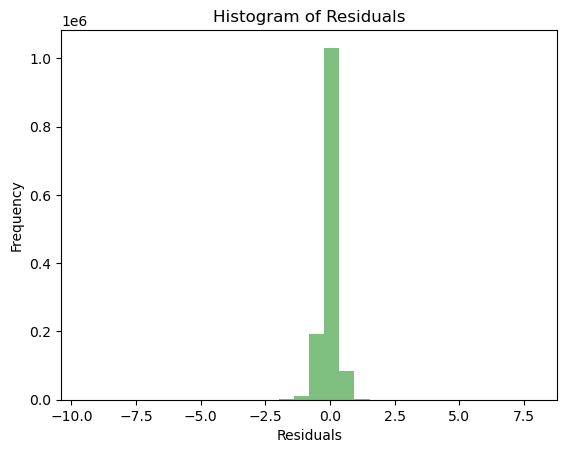

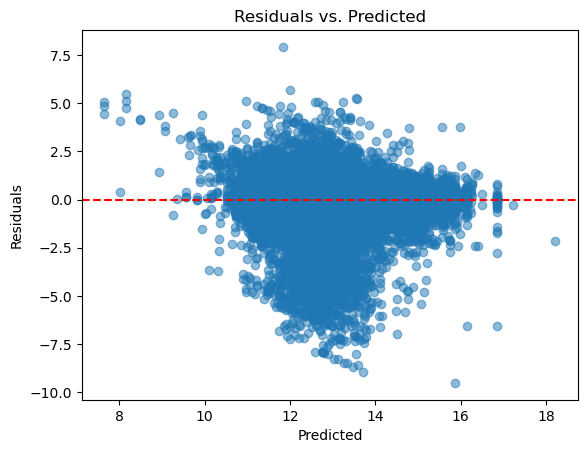

In [49]:
# Add a column for residuals to the DataFrame
residuals = val_predictions_dt.withColumn("residuals", col("log_price") - col("prediction"))

residuals_pd = residuals.select("residuals","prediction").toPandas()


# Plotting histogram of residuals
plt.hist(residuals_pd['residuals'], bins=30, alpha=0.5, color='g')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of predicted vs residuals
plt.scatter(residuals_pd['prediction'], residuals_pd['residuals'], alpha=0.5)
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()



Feature Importance

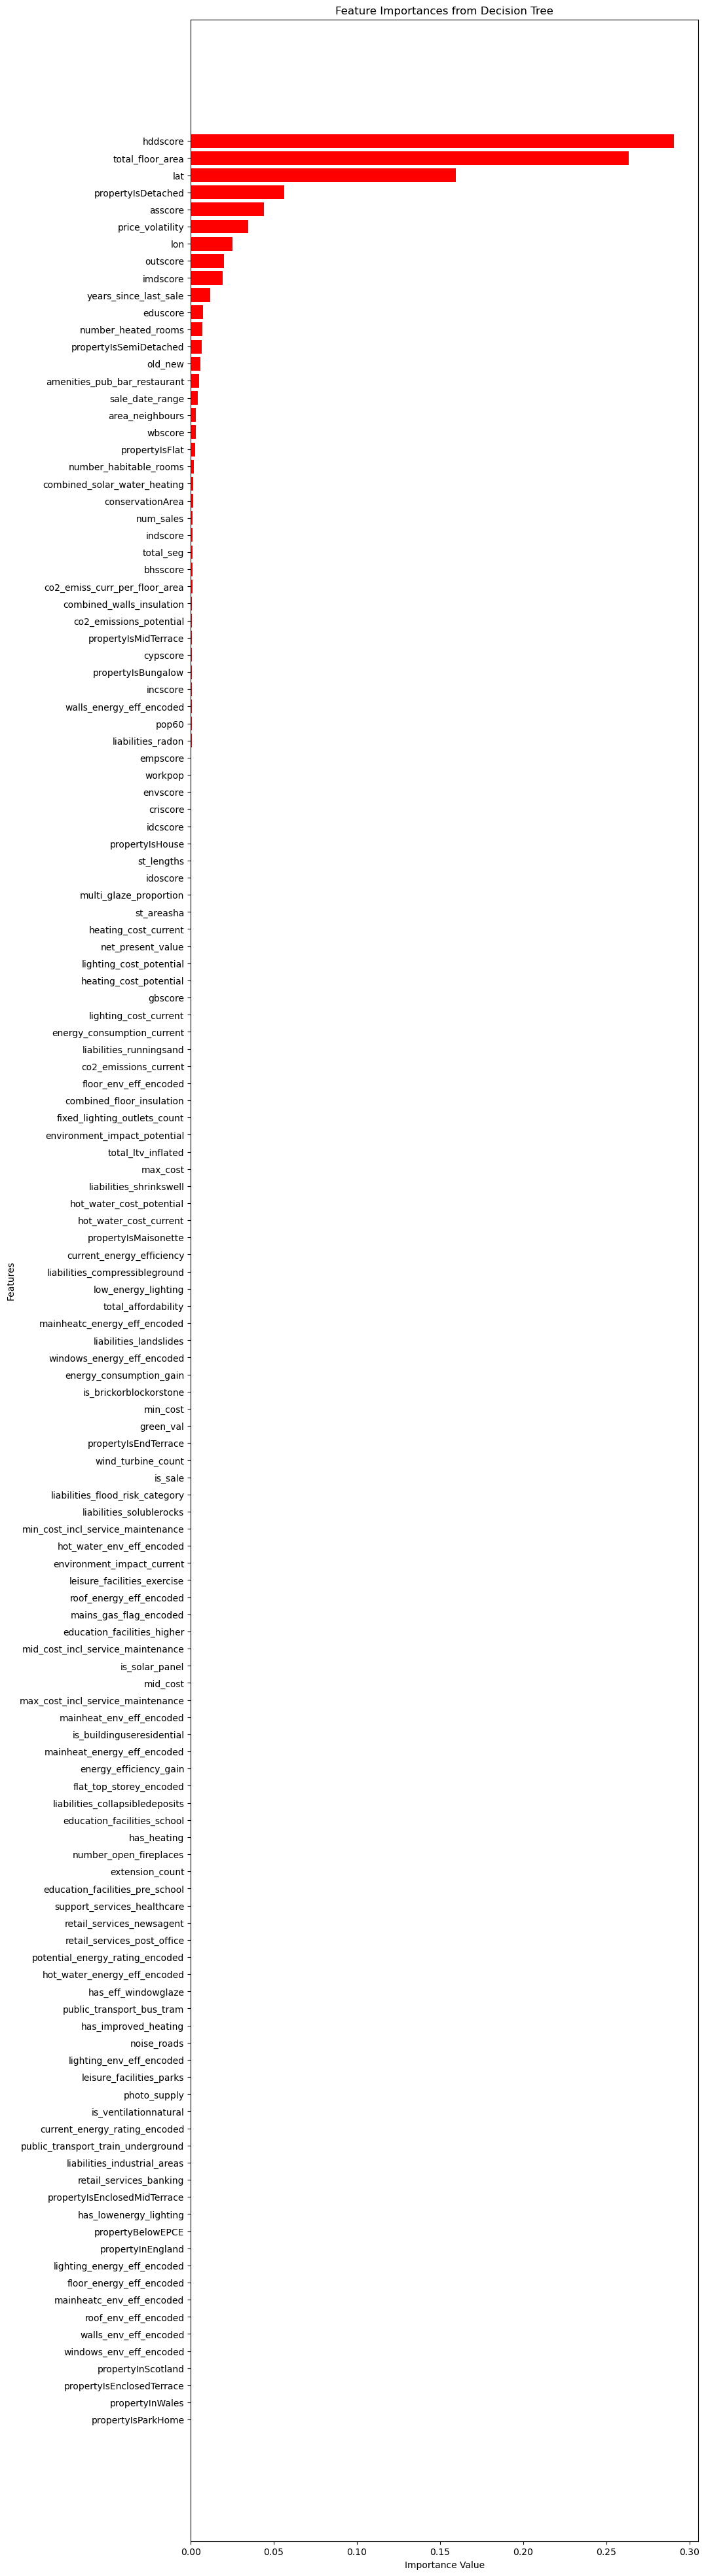

In [50]:
feature_importances = best_model_dt.featureImportances  # Get feature importances from the model
features = assembler.getInputCols()  # Get the feature names

# Creating a DataFrame with feature names and their importance
importance_df = pd.DataFrame(list(zip(features, feature_importances)), columns=["Feature", "Importance"])
importance_df.sort_values(by="Importance", ascending=False, inplace=True)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 50))  # Set the figure size
plt.barh(importance_df['Feature'], importance_df['Importance'], color='red')  # Create horizontal bar chart
plt.xlabel('Importance Value')  # Label on x-axis
plt.ylabel('Features')  # Label on y-axis
plt.title('Feature Importances from Decision Tree')  # Title of the plot
plt.gca().invert_yaxis()  # Invert y axis so that the largest bar is on top
plt.show()  # Display the plot


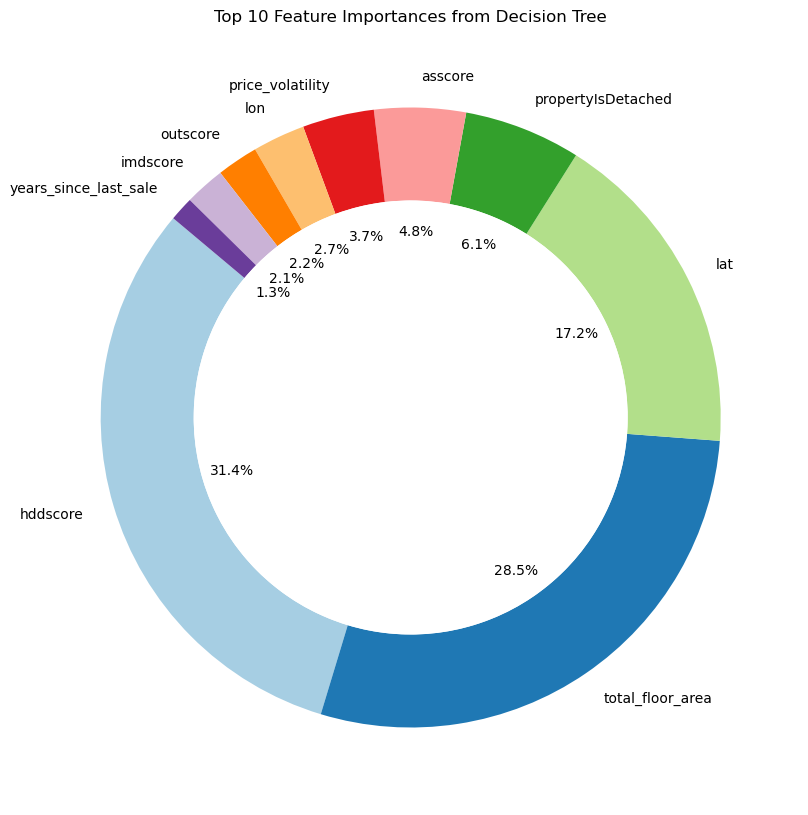

In [51]:
feature_importances = best_model_dt.featureImportances  # Get feature importances from the model
features = assembler.getInputCols()  # Get the feature names

# Creating a DataFrame with feature names and their importance
importance_df = pd.DataFrame(list(zip(features, feature_importances)), columns=["Feature", "Importance"])
importance_df.sort_values(by="Importance", ascending=False, inplace=True)

# Select the top 10 features
top_10_features = importance_df.head(10)

# Plotting a pie chart for the top 10 features
plt.figure(figsize=(10, 15))  # Set the figure size
plt.pie(top_10_features['Importance'], labels=top_10_features['Feature'], autopct='%1.1f%%',
        startangle=140, colors=plt.cm.Paired.colors, wedgeprops=dict(width=0.3))  # Draw pie chart with ring

# Equal aspect ratio ensures that the pie is drawn as a circle.
plt.gca().set_aspect('equal')

# Draw a circle in the center to create a ring
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.title('Top 10 Feature Importances from Decision Tree')  # Title of the plot
plt.show()  # Display the plot


In [54]:
# Convert log values back to the original range
val_predictions_dt = val_predictions_dt.withColumn("hpi_adjusted_price", exp(col("log_price")))
val_predictions_dt = val_predictions_dt.withColumn("predicted_price", round(exp(col("prediction"))).cast('int'))

predicted_df = val_predictions_dt.select("hpi_adjusted_price", "predicted_price").limit(10).toPandas()
print(predicted_df)

   hpi_adjusted_price  predicted_price
0            289888.0           322576
1            128976.0           112665
2            667893.0           935496
3           1759885.0          1607548
4           1208648.0          1481449
5             70538.0           105072
6            283855.0           696883
7            109399.0           238222
8           1053081.0          1264000
9            467525.0           385264


#### Random Forest

In [47]:
# Define the RandomForestRegressor model
random_forest_regressor = models['RandomForestRegressor']

# Define the hyperparameter grid for RandomForestRegressor
param_grid_rf = params['RandomForestRegressor']

# Define the CrossValidator for RandomForestRegressor
crossval_rf = CrossValidator(estimator=random_forest_regressor,
                             estimatorParamMaps=param_grid_rf,
                             evaluator=evaluator,
                             numFolds=5)  # 5-fold cross-validation

# Fit the CrossValidator on the training data
cv_model_rf = crossval_rf.fit(train_data)

# Get the best model
best_model_rf = cv_model_rf.bestModel

# Make predictions on the validation data
val_predictions_rf = best_model_rf.transform(val_data)

# Evaluate the predictions
rmse_rf = evaluator.evaluate(val_predictions_rf, {evaluator.metricName: "rmse"})
mae_rf = evaluator.evaluate(val_predictions_rf, {evaluator.metricName: "mae"})
r2_rf = evaluator.evaluate(val_predictions_rf, {evaluator.metricName: "r2"})

# Print the evaluation metrics
print(f"Root Mean Squared Error (RMSE) on validation data: {rmse_rf}")
print(f"Mean Absolute Error (MAE) on validation data: {mae_rf}")
print(f"R-squared (R2) on validation data: {r2_rf}")

# Print the best parameters
print("Best parameters for Random Forest Regressor model:")
for param, value in best_model_rf.extractParamMap().items():
    print(f"{param.name}: {value}")


Root Mean Squared Error (RMSE) on validation data: 0.3077871819711648
Mean Absolute Error (MAE) on validation data: 0.1990260764872143
R-squared (R2) on validation data: 0.7910419563628341
Best parameters for Random Forest Regressor model:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: sqrt
featuresCol: scaled_features
impurity: variance
labelCol: log_price
leafCol: 
maxBins: 32
maxDepth: 15
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 20
predictionCol: prediction
seed: 42
subsamplingRate: 1.0


Residual Analysis

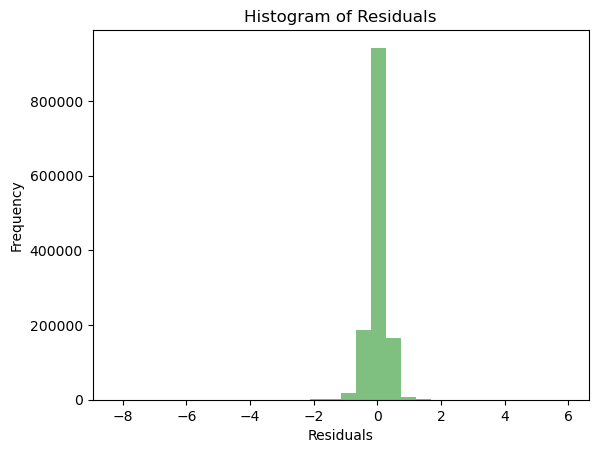

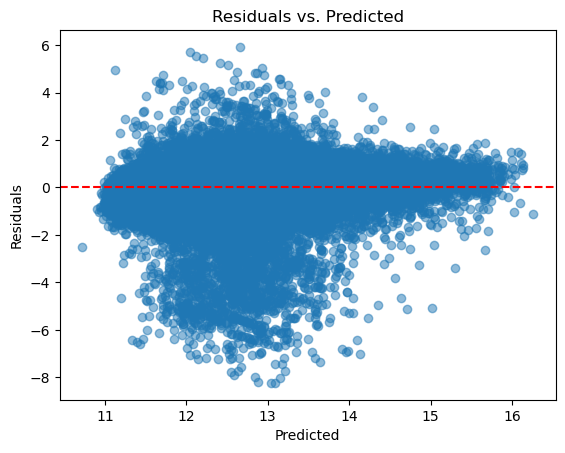

In [49]:
# Add a column for residuals to the DataFrame
residuals = val_predictions_rf.withColumn("residuals", col("log_price") - col("prediction"))

residuals_pd = residuals.select("residuals","prediction").toPandas()


# Plotting histogram of residuals
plt.hist(residuals_pd['residuals'], bins=30, alpha=0.5, color='g')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of predicted vs residuals
plt.scatter(residuals_pd['prediction'], residuals_pd['residuals'], alpha=0.5)
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()



Feature Importance

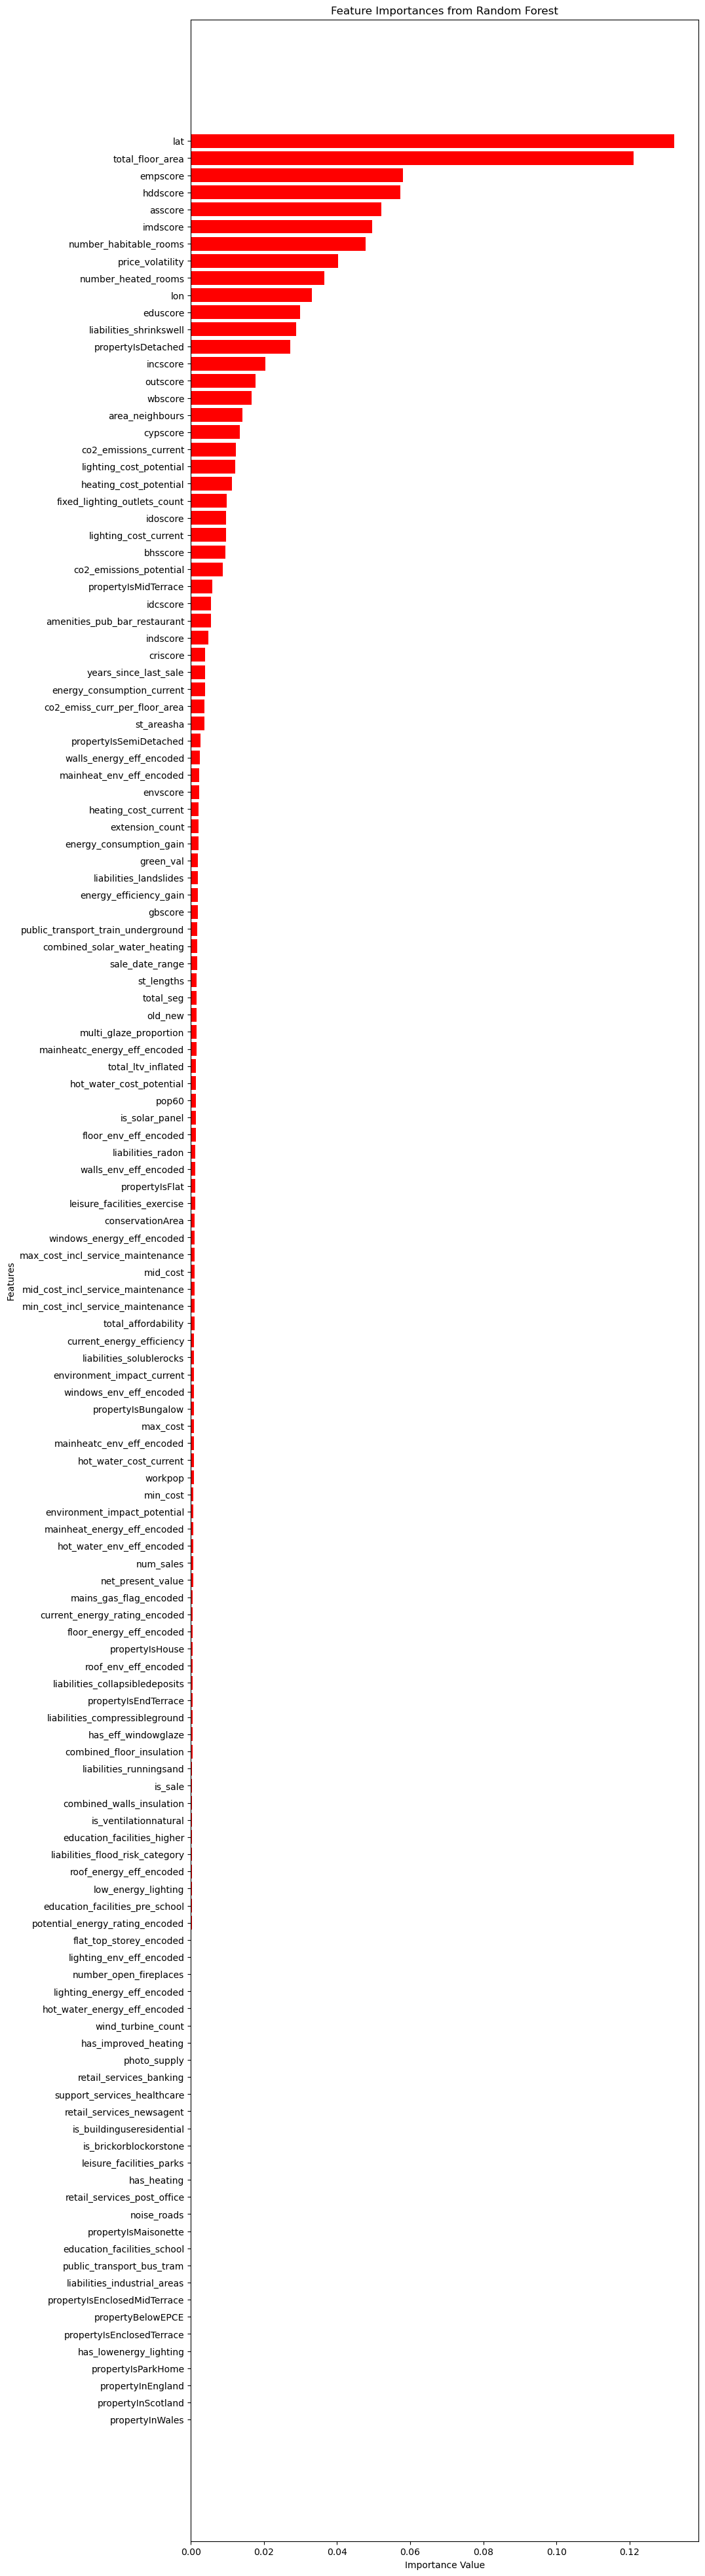

In [50]:
feature_importances = best_model_rf.featureImportances  # Get feature importances from the model
features = assembler.getInputCols()  # Get the feature names

# Creating a DataFrame with feature names and their importance
importance_df = pd.DataFrame(list(zip(features, feature_importances)), columns=["Feature", "Importance"])
importance_df.sort_values(by="Importance", ascending=False, inplace=True)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 50))  # Set the figure size
plt.barh(importance_df['Feature'], importance_df['Importance'], color='red')  # Create horizontal bar chart
plt.xlabel('Importance Value')  # Label on x-axis
plt.ylabel('Features')  # Label on y-axis
plt.title('Feature Importances from Random Forest')  # Title of the plot
plt.gca().invert_yaxis()  # Invert y axis so that the largest bar is on top
plt.show()  # Display the plot


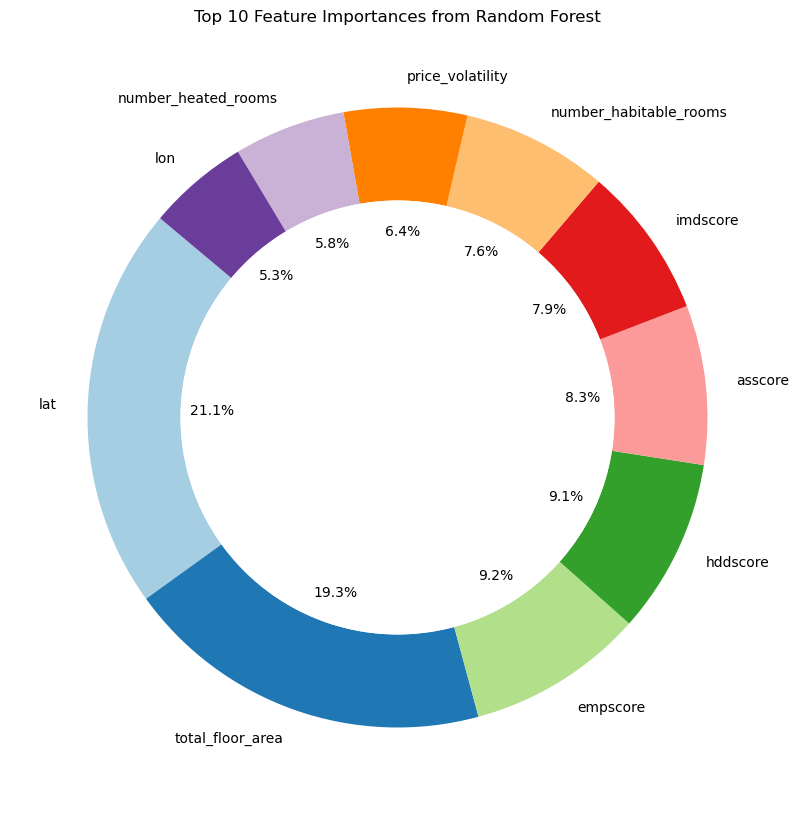

In [52]:
feature_importances = best_model_rf.featureImportances  # Get feature importances from the model
features = assembler.getInputCols()  # Get the feature names

# Creating a DataFrame with feature names and their importance
importance_df = pd.DataFrame(list(zip(features, feature_importances)), columns=["Feature", "Importance"])
importance_df.sort_values(by="Importance", ascending=False, inplace=True)

# Select the top 10 features
top_10_features = importance_df.head(10)

# Plotting a pie chart for the top 10 features
plt.figure(figsize=(10, 15))  # Set the figure size
plt.pie(top_10_features['Importance'], labels=top_10_features['Feature'], autopct='%1.1f%%',
        startangle=140, colors=plt.cm.Paired.colors, wedgeprops=dict(width=0.3))  # Draw pie chart with ring

# Equal aspect ratio ensures that the pie is drawn as a circle.
plt.gca().set_aspect('equal')

# Draw a circle in the center to create a ring
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.title('Top 10 Feature Importances from Random Forest')  # Title of the plot
plt.show()  # Display the plot


In [55]:
# Convert log values back to the original range
val_predictions_rf = val_predictions_rf.withColumn("hpi_adjusted_price", exp(col("log_price")))
val_predictions_rf = val_predictions_rf.withColumn("predicted_price", round(exp(col("prediction"))).cast('int'))

predicted_df = val_predictions_rf.select("hpi_adjusted_price", "predicted_price").limit(10).toPandas()
print(predicted_df)

   hpi_adjusted_price  predicted_price
0            145630.0           191777
1            650144.0           378422
2            645012.0           415582
3            484474.0           516998
4            233385.0           323435
5            210616.0           300145
6            620593.0           434337
7            194971.0           196134
8            303865.0           263432
9            257806.0           274250


#### Gradient Boosting

In [47]:
# Define the GBTRegressor model
gbt_regressor = models['GBTRegressor']

param_grid_gbt = params['GBTRegressor']

# Define the CrossValidator for GBTRegressor
crossval_gbt = CrossValidator(estimator=gbt_regressor,
                              estimatorParamMaps=param_grid_gbt,
                              evaluator=evaluator,
                              numFolds=5)  

# Fit the CrossValidator on the training data
cv_model_gbt = crossval_gbt.fit(train_data)

# Get the best model
best_model_gbt = cv_model_gbt.bestModel

# Make predictions on the validation data
val_predictions_gbt = best_model_gbt.transform(val_data)

# Evaluate the predictions
rmse_gbt = evaluator.evaluate(val_predictions_gbt, {evaluator.metricName: "rmse"})
mae_gbt = evaluator.evaluate(val_predictions_gbt, {evaluator.metricName: "mae"})
r2_gbt = evaluator.evaluate(val_predictions_gbt, {evaluator.metricName: "r2"})

# Print the evaluation metrics
print(f"Root Mean Squared Error (RMSE) on validation data: {rmse_gbt}")
print(f"Mean Absolute Error (MAE) on validation data: {mae_gbt}")
print(f"R-squared (R2) on validation data: {r2_gbt}")

# Print the best parameters
print("Best parameters for GBTRegressor model:")
for param, value in best_model_gbt.extractParamMap().items():
    print(f"{param.name}: {value}")


Root Mean Squared Error (RMSE) on validation data: 0.28580289753505994
Mean Absolute Error (MAE) on validation data: 0.17902761724766
R-squared (R2) on validation data: 0.8197057120459458
Best parameters for GBTRegressor model:
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: scaled_features
impurity: variance
labelCol: log_price
leafCol: 
lossType: squared
maxBins: 32
maxDepth: 10
maxIter: 20
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
predictionCol: prediction
seed: 42
stepSize: 0.3
subsamplingRate: 1.0
validationTol: 0.01


Residual Analysis

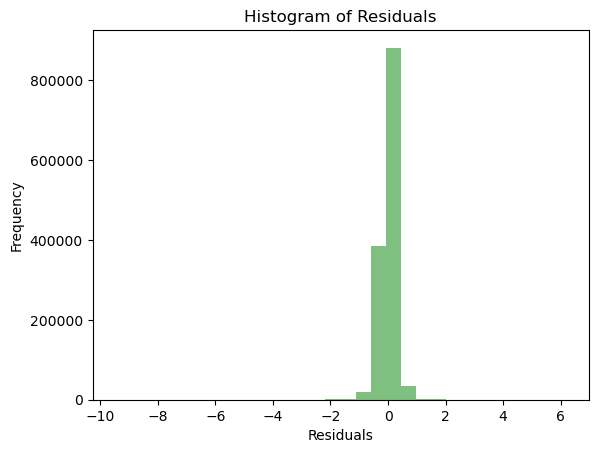

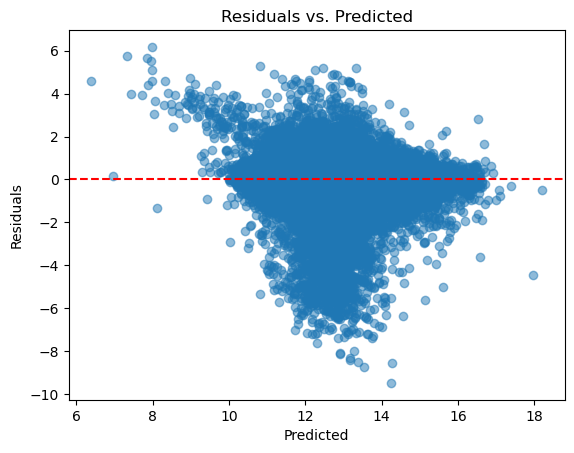

In [49]:
# Add a column for residuals to the DataFrame
residuals = val_predictions_gbt.withColumn("residuals", col("log_price") - col("prediction"))

residuals_pd = residuals.select("residuals","prediction").toPandas()


# Plotting histogram of residuals
plt.hist(residuals_pd['residuals'], bins=30, alpha=0.5, color='g')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of predicted vs residuals
plt.scatter(residuals_pd['prediction'], residuals_pd['residuals'], alpha=0.5)
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()



Feature Importance

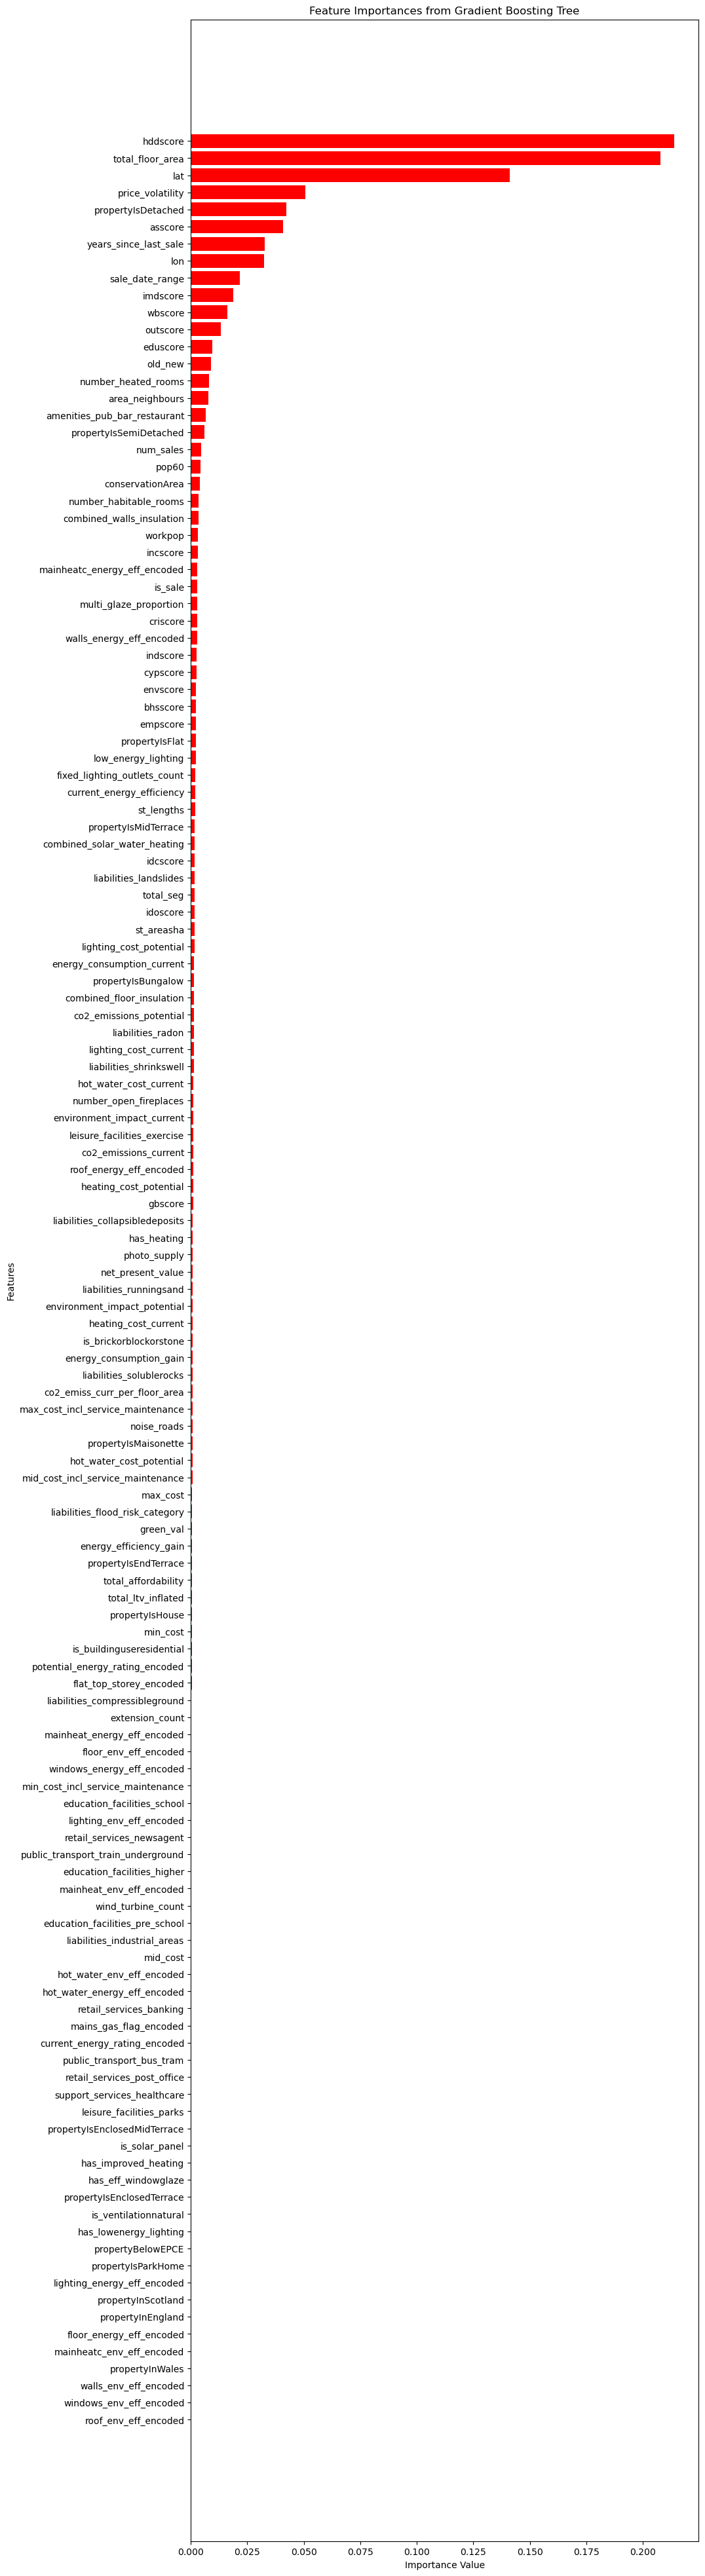

In [48]:
feature_importances = best_model_gbt.featureImportances  # Get feature importances from the model
features = assembler.getInputCols()  # Get the feature names

# Creating a DataFrame with feature names and their importance
importance_df = pd.DataFrame(list(zip(features, feature_importances)), columns=["Feature", "Importance"])
importance_df.sort_values(by="Importance", ascending=False, inplace=True)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 50))  # Set the figure size
plt.barh(importance_df['Feature'], importance_df['Importance'], color='red')  # Create horizontal bar chart
plt.xlabel('Importance Value')  # Label on x-axis
plt.ylabel('Features')  # Label on y-axis
plt.title('Feature Importances from Gradient Boosting Tree')  # Title of the plot
plt.gca().invert_yaxis()  # Invert y axis so that the largest bar is on top
plt.show()  # Display the plot


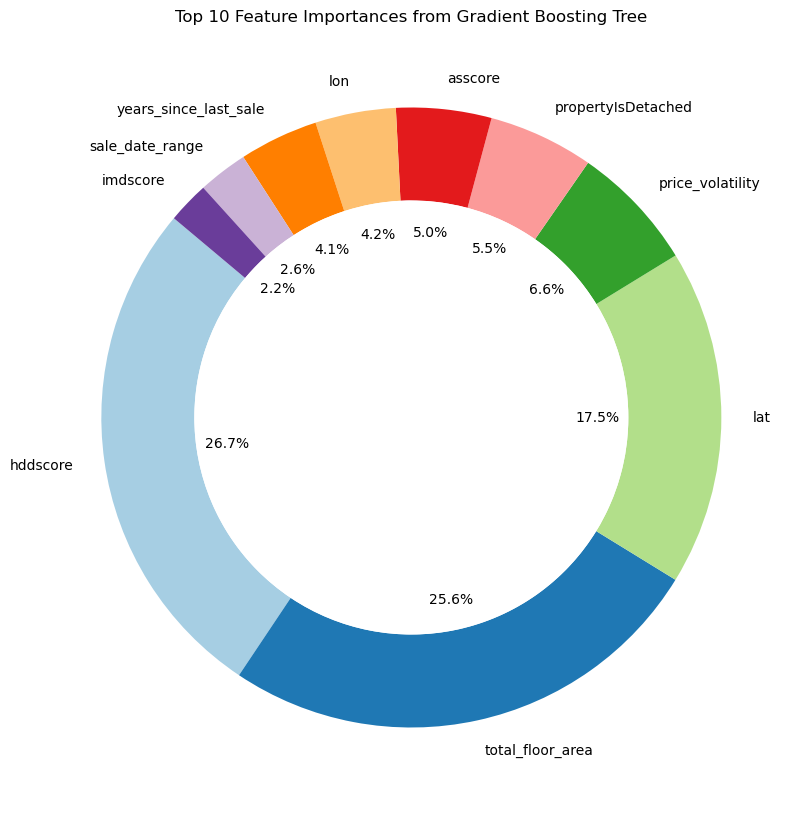

In [51]:
feature_importances = best_model_gbt.featureImportances  # Get feature importances from the model
features = assembler.getInputCols()  # Get the feature names

# Creating a DataFrame with feature names and their importance
importance_df = pd.DataFrame(list(zip(features, feature_importances)), columns=["Feature", "Importance"])
importance_df.sort_values(by="Importance", ascending=False, inplace=True)

# Select the top 10 features
top_10_features = importance_df.head(10)

# Plotting a pie chart for the top 10 features
plt.figure(figsize=(10, 15))  # Set the figure size
plt.pie(top_10_features['Importance'], labels=top_10_features['Feature'], autopct='%1.1f%%',
        startangle=140, colors=plt.cm.Paired.colors, wedgeprops=dict(width=0.3))  # Draw pie chart with ring

# Equal aspect ratio ensures that the pie is drawn as a circle.
plt.gca().set_aspect('equal')

# Draw a circle in the center to create a ring
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

plt.title('Top 10 Feature Importances from Gradient Boosting Tree')  # Title of the plot
plt.show()  # Display the plot


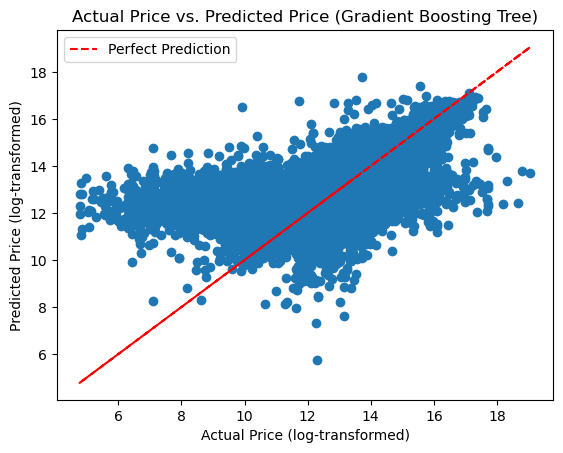

In [49]:
predicted_df = val_predictions_gbt.select("log_price", "prediction").toPandas()

# Separate actual price and predicted price columns
actual_price = predicted_df["log_price"]
predicted_price = predicted_df["prediction"]

# Create the plot
plt.scatter(actual_price, predicted_price)

# Add labels and title
plt.xlabel("Actual Price (log-transformed)")
plt.ylabel("Predicted Price (log-transformed)")
plt.title("Actual Price vs. Predicted Price (Gradient Boosting Tree)")

# Add a diagonal line for perfect prediction 
plt.plot(actual_price, actual_price, color='red', linestyle='--', label='Perfect Prediction')

# Add legend 
plt.legend()

# Show the plot
plt.show()

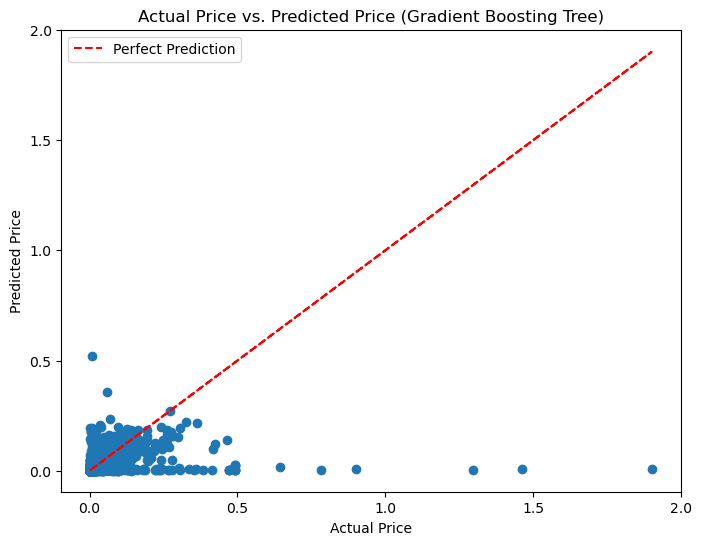

In [53]:
# Convert log values back to the original range
val_predictions_gbt = val_predictions_gbt.withColumn("hpi_adjusted_price", exp(col("log_price")))
val_predictions_gbt = val_predictions_gbt.withColumn("predicted_price", round(exp(col("prediction"))).cast('int'))

predicted_df = val_predictions_gbt.select("hpi_adjusted_price", "predicted_price").toPandas()

# Separate actual price and predicted price columns
actual_price = predicted_df["hpi_adjusted_price"]
predicted_price = predicted_df["predicted_price"]

# Create the plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(actual_price, predicted_price)

# Add labels and title
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs. Predicted Price (Gradient Boosting Tree)")

# Add a diagonal line for perfect prediction 
plt.plot(actual_price, actual_price, color='red', linestyle='--', label='Perfect Prediction')

# Set custom ticks on the x and y axes
plt.xticks(ticks=[0, 0.5e8, 1.0e8, 1.5e8, 2.0e8], labels=['0.0', '0.5', '1.0', '1.5', '2.0'])
plt.yticks(ticks=[0, 0.5e8, 1.0e8, 1.5e8, 2.0e8], labels=['0.0', '0.5', '1.0', '1.5', '2.0'])

# Add legend 
plt.legend()

# Show the plot
plt.show()

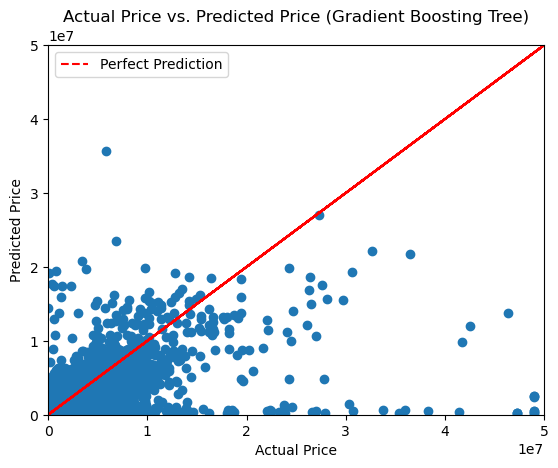

In [51]:
# Create the plot
plt.scatter(actual_price, predicted_price)

# Add labels and title
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs. Predicted Price (Gradient Boosting Tree)")

# Add a diagonal line for perfect prediction 
plt.plot(actual_price, actual_price, color='red', linestyle='--', label='Perfect Prediction')

# Set the limits for x and y axes to zoom in on the 0 to 0.5 region
plt.xlim(0, 0.5e8)  #  (here it zooms to 0 to 50 million)
plt.ylim(0, 0.5e8)  # (here it zooms to 0 to 50 million)

# Add legend 
plt.legend()

# Show the plot
plt.show()


In [54]:
# Convert log values back to the original range
val_predictions_gbt = val_predictions_gbt.withColumn("hpi_adjusted_price", exp(col("log_price")))
val_predictions_gbt = val_predictions_gbt.withColumn("predicted_price", round(exp(col("prediction"))).cast('int'))

predicted_df = val_predictions_gbt.select("hpi_adjusted_price", "predicted_price").limit(10).toPandas()
print(predicted_df)

   hpi_adjusted_price  predicted_price
0            405153.0           321984
1            144692.0           109485
2            750343.0           694405
3            165732.0           218246
4            405153.0           416266
5            450245.0           589373
6            150327.0           266864
7            291835.0           271494
8             91814.0            89364
9            537647.0           176013


### Final Model Validation on Test Data

In [55]:
# Make predictions on the test data
test_predictions_gbt = best_model_gbt.transform(test_data)

# Evaluate the predictions on the test data
rmse_gbt_test = evaluator.evaluate(test_predictions_gbt, {evaluator.metricName: "rmse"})
mae_gbt_test = evaluator.evaluate(test_predictions_gbt, {evaluator.metricName: "mae"})
r2_gbt_test = evaluator.evaluate(test_predictions_gbt, {evaluator.metricName: "r2"})

# Print the evaluation metrics for the test data
print(f"Root Mean Squared Error (RMSE) on test data: {rmse_gbt_test}")
print(f"Mean Absolute Error (MAE) on test data: {mae_gbt_test}")
print(f"R-squared (R2) on test data: {r2_gbt_test}")


Root Mean Squared Error (RMSE) on test data: 0.2876173917204457
Mean Absolute Error (MAE) on test data: 0.1789172751911183
R-squared (R2) on test data: 0.8176483386235751


### Final Predictions

In [48]:
# Make predictions on the entire data
full_predictions = best_model_gbt.transform(df_final)


In [49]:
predicted_df = full_predictions.limit(10).toPandas()
print(predicted_df)

           uprn                                    scaled_features  log_price  \
0  100000000052  [5.192356323376432, 4.272221858161597, 8.59489...  11.796765   
1  100000000406  [5.192356323376432, 4.913055136885837, 7.55595...  13.240690   
2  100000000625  [5.439611386394358, 4.5570366487057035, 7.5559...  12.391751   
3  100000000693  [5.686866449412283, 4.62824034634173, 7.555954...  12.299253   
4  100000000713  [4.9451012603585065, 3.7737959747094107, 7.461...  12.069244   
5  100000001064  [5.357193032055049, 4.485832951069677, 7.17815...  11.938030   
6  100000001111  [4.368172779983348, 2.2073146267168253, 5.8558...  11.177942   
7  100000001889  [3.956081008286805, 3.2041663936211977, 8.0282...  12.113513   
8  100000001912  [4.862682906019198, 3.9874070676174904, 6.5170...  11.672490   
9   10000000229  [3.3791525279116463, 2.5633331148969583, 5.761...  14.191409   

   prediction  
0   11.797866  
1   13.203938  
2   12.124071  
3   12.435915  
4   12.228906  
5   11.72469

In [50]:
d_full = full_predictions.select("uprn","log_price", "prediction").toPandas()
d_full.to_csv("predictions.csv", index=False)